In [1]:
# Masters Thesis willem

import pypsa
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
import glob
from dtw import *
import itertools

plt.style.use ("bmh")
from pprint import *
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()
#logger.setLevel(logging.CRITICAL)


    
#from sklearn_extra.cluster import KMedoids

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters 
    of the operative network.
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
        np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
        n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)
    
    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False
    
    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    links_dc_i = n.links.index[n.links.carrier == 'DC']
    n.links.loc[links_dc_i, 'p_nom'] = \
        n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
    n.links.loc[links_dc_i, 'p_nom_extendable'] = False
    
    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False
    
    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False
    return n

def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)
    
    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0)/network.lines.s_nom)
    max_loading = (network.lines_t.p0/network.lines.s_nom).max(axis = 0)
    print(max_loading)

    #In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    #At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    #it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    #to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)

def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist() 
                                    if network.storage_units.loc[name]["carrier"] == "battery"])
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    network.mremove("Store", [name for name in network.stores.index.tolist()
                             if "BESS" in name])
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                           if "BESS" in name])
    
def add_BESS_loadflexibility(network, network_year, flex_potential = 10000, c_rate = 0.25, flex_share = 0.1):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node. 
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)
    
    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads. 
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization 
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis = 0)
    
    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = network.buses.index.tolist()[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # determin flexibility at bus
        df_loads_bus = df_loads[df_loads["bus"] == bus_name]
        
        ################
        
        
        # TODO: ÄNDERN DER maximalen energie: Die speicherbare energie soll abhängig vom mittelwert der last 
        # über den GESAMTEN zeitraum sein, nicht nur vom mittelwert des aktuellen (1 day) networks!
        
        
        ################
        
        if not df_loads_bus.empty:
            p_flex = df_loads_bus.p_mean * flex_share
        else:
            p_flex = 0
            
        print("p_flex = " + str(p_flex))

        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # add store
        network.add("Store", name = "BESS_{}".format(i),
                    bus = battery_bus,
                    e_nom = p_flex / c_rate,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = False,
                    p_set = p_flex,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
        # discharge link
        network.add("Link",
                    name = "BESS_{}_discharger".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "BESS_{}_charger".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = p_flex,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
    network.name = str(network.name) + " BESS loadflexibility"
        
def add_BESS(network):
    '''
    Adds static battery storages (fixed capacity) to the base network
    Removes previously added batteries (links and stores) from the network
    
    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    
    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # discharge link
        network.add("Link",
                    name = "Battery_{}_dCH".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "Battery_{}_CH".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = False,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # add store
        network.add("Store", name = "BESS_{}".format(i),    
                    bus = battery_bus,
                    e_nom = 200,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = 100,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)
    network.name = str(network.name) + " BESS"
    
        
def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])


def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)
    
    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["hard coal","lignite","gas","oil","nuclear","OCGT","CCGT"]
    
    for generator in l_generators:
        
        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name = "{}_pos".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = network.generators.loc[generator]["marginal_cost"],
                                   capital_cost = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_max_pu = (1 - network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = 0,
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            
        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE 
            network_redispatch.add("Generator",
                                   name = "{}".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = 0,
                                   capital_cost = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_max_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu = (network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus, 
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down 
            network_redispatch.add("Generator",
                                   name = "{}_neg".format(generator), 
                                   bus = network.generators.loc[generator]["bus"],
                                   p_nom = network.generators.loc[generator]["p_nom"],
                                   efficiency = network.generators.loc[generator]["efficiency"],
                                   marginal_cost = (network.generators.loc[generator]["marginal_cost"] - network_dispatch.buses_t.marginal_price[network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost = 0,
                                   p_max_pu = 0,
                                   carrier = network.generators.loc[generator]["carrier"],
                                   p_min_pu = (- network_dispatch.generators_t.p[generator] / network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                  )
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.
    For faster computation: Assign to first bus of dataset
    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''  
    mode = "default"
    network_dispatch = network.copy()
    
    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses
    
    if mode == "cluster":
        # Cluster buses to 1 cluster & compute center
        np_busmap = df_busmap[["x","y"]].to_numpy()
        k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
        score = k_medoids.fit(np_busmap)
        x_medoid = k_medoids.cluster_centers_[0][0]
        y_medoid = k_medoids.cluster_centers_[0][1]
        # find single medoid bus in dataframe
        market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)].squeeze()
        bus_name = str(market_bus.name) # save bus name, remove brackets & quotemarks
    else:
        #bus_name = str(df_busmap[0].index.values)[2:-2]
        bus_name = df_busmap.iloc[0].name

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    return network_dispatch

def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch = build_redispatch_network(network, network_dispatch)
    # Solve new network
    network_redispatch.lopf(solver_name="gurobi", pyomo = False, 
                 formulation ="kirchhoff")
    return network_redispatch 
    
# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share, flex_store = True):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    # Adding a battery at every node
    if flex_store == True:
        add_BESS_loadflexibility(network_redispatch_bat, network_year, c_rate, flex_share)
    else:
        add_BESS(network_redispatch_bat)
        
    return network_redispatch_bat
    
def solve_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization 
    '''
    
    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot    

    network_redispatch_bat = build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share,flex_store = True,)
    # Solve new network
    network_redispatch_bat.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
    
    return network_redispatch_bat



def concat_network(list_networks, ignore_standard_types = False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating 
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    #create new network out of first network of the list of identical networks 
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------
    override_components, override_component_attrs = n_input._retrieve_overridden_components()
    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                                     override_components=override_components,
                                     override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):
        df = component.df
        #drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)
        import_components_from_dataframe(nw, df, component.name)
    
    # Time dependent components
    # --------------------
    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)   

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus","Carrier"})):
        component_t = component.list_name + "_t"
        
        for attr, timeseries in component.pnl.items():
            l_component = []
            for network in list_networks:
                #each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t),attr))
            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis = 0)
            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)
    
    #catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw,attr,getattr(n_input,attr))  
    
    # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj 

    return nw

def redispatch_workflow(network, network_optim, scenario = "no bat",  
                        c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    '''
    Function for executing the whole redispatch workflow.
    
    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    dict_obj_d = {}
    dict_obj_rd = {}
    
    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)
    
    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:,"capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        #print(start_hour)
        n_24 = network.copy(snapshots = network.snapshots[start_hour:start_hour+24])
        
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
        
        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate = 0.25, flex_share = 0.1, flex_store = True)
                
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
        
        # Create output list for the daily objective values dispatch & redispatch
        # ---------------
        dict_obj_d[n_dispatch.snapshots[0].day] = n_dispatch.objective
        dict_obj_rd[n_redispatch.snapshots[0].day] = n_redispatch.objective
        
        # For each results list: Create a network out of daily networks for dispatch & redispatch
        # ---------------
        network_dispatch = concat_network(l_networks_dispatch)
        network_redispatch = concat_network(l_networks_redispatch)
           
    
    return network_dispatch, network_redispatch, dict_obj_d, dict_obj_rd
  
    
def solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    """
    import pickle as pkl
    import glob
    
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    for filepath in glob.iglob(folder + '\*.nc'):
        filename = filepath.split('\\')[-1].split(".")[0]
        path_n = filepath
        path_n_optim = folder + "\solved\\" + filename +".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)
        
        # TEST TEST TEST
        # --------------
        nw = n.copy(snapshots = n.snapshots[0:24*7])
        nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*7])
        
        n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                         c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                            c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        
        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"\results"
        n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                              export_standard_types=False, least_significant_digit=None)
        n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                  export_standard_types=False, least_significant_digit=None)
        
        # export lists with obj values
        with open(export_path + r"\dispatch\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_d, f)      
        with open(export_path + r"\redispatch\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_rd, f)
        with open(export_path + r"\redispatch\\" + filename + r"_bat.pickle","wb") as f:
            pkl.dump(dict_obj_rd_bat, f)
            
def redispatch_workflow(network, network_optim, scenario = "no bat",  
                        c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    '''
    Function for executing the whole redispatch workflow.
    
    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []
    dict_obj_d = {}
    dict_obj_rd = {}
    
    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)
    
    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:,"capital_cost"] = 0
    
    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        #print(start_hour)
        n_24 = network.copy(snapshots = network.snapshots[start_hour:start_hour+24])
        
        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo = False, formulation ="kirchhoff")
        
        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate = 0.25, flex_share = 0.1, flex_store = True)
                
        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)
        
        # Create output list for the daily objective values dispatch & redispatch
        # ---------------
        dict_obj_d[n_dispatch.snapshots[0].day] = n_dispatch.objective
        dict_obj_rd[n_redispatch.snapshots[0].day] = n_redispatch.objective
        
        # For each results list: Create a network out of daily networks for dispatch & redispatch
        # ---------------
        network_dispatch = concat_network(l_networks_dispatch)
        network_redispatch = concat_network(l_networks_redispatch)
           
    
    return network_dispatch, network_redispatch, dict_obj_d, dict_obj_rd
  
    
def solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    Can also be used for a single redispatch network.
    In any case, saves analysis outputs in target directory.
    """
    single_network = True
    folder = r'C:\Users\Willem\pypsa-eur\networks_redispatch'
    # Solve a single redispatch network
    if single_network == True:
        filename = "elec_s300_50_ec_lcopt_1H"
        path_n = folder + r"\\" + filename + r".nc"
        path_n_optim = folder + r"\solved\\" + filename + r".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)

        # TEST TEST TEST
        # --------------
        nw = n.copy(snapshots = n.snapshots[0:24*31])
        nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*31])

        n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                         c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
        n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                            c_rate = 0.25, flex_share = 0.1 ,flex_store = True)

        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"\results"
        n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                              export_standard_types=False, least_significant_digit=None)
        n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                  export_standard_types=False, least_significant_digit=None)

        # export lists with obj values
        with open(export_path + r"\dispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_d, f)      
        with open(export_path + r"\redispatch\objective\\" + filename + r".pickle","wb") as f:
            pkl.dump(dict_obj_rd, f)
        with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","wb") as f:
            pkl.dump(dict_obj_rd_bat, f)
    # Solve all redispatch networks from within folder
    else: 
        for filepath in glob.iglob(folder + '\*.nc'):
            filename = filepath.split('\\')[-1].split(".")[0]
            path_n = filepath
            path_n_optim = folder + "\solved\\" + filename +".nc"
            # Define network and network_optim
            n = pypsa.Network(path_n)
            n_optim = pypsa.Network(path_n_optim)

            # TEST TEST TEST
            # --------------
            nw = n.copy(snapshots = n.snapshots[0:24*7])
            nw_optim = n_optim.copy(snapshots = n_optim.snapshots[0:24*7])

            n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat", 
                                             c_rate = 0.25, flex_share = 0.1 ,flex_store = True)
            n_d_bat, n_rd_bat, dict_obj_d_bat, dict_obj_rd_bat = redispatch_workflow(nw, nw_optim, scenario = "bat",
                                                c_rate = 0.25, flex_share = 0.1 ,flex_store = True)

            # export solved dispatch & redispatch workflow as well as objective value list
            export_path = folder + r"\results"
            n_d.export_to_netcdf(path=export_path + r"\dispatch\\" + filename + ".nc",
                                 export_standard_types=False, least_significant_digit=None)
            n_rd.export_to_netcdf(path=export_path + r"\redispatch\\" + filename  + ".nc", 
                                  export_standard_types=False, least_significant_digit=None)
            n_rd_bat.export_to_netcdf(path=export_path + r"\redispatch\\" + filename + "_bat.nc", 
                                      export_standard_types=False, least_significant_digit=None)

            # export lists with obj values
            with open(export_path + r"\dispatch\objective\\" + filename + r".pickle","wb") as f:
                pkl.dump(dict_obj_d, f)      
            with open(export_path + r"\redispatch\objective\\" + filename + r".pickle","wb") as f:
                pkl.dump(dict_obj_rd, f)
            with open(export_path + r"\redispatch\objective\\" + filename + r"_bat.pickle","wb") as f:
                pkl.dump(dict_obj_rd_bat, f)

In [3]:
#solve_all_redispatch_workflows(c_rate = 0.25, flex_share = 0.1 ,flex_store = True,)

# <u> Analysis of Pypsa-eur networks <u>

In [4]:
# # Define all analysis functions for the network

# def analyze_objective():
#     '''
#     Function for all analysis regarding the objective value (dispatch cost and redispatch cost reduction). 
#     '''
#     # Import objective dicts from pickle
#     # ---------------
#     import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"
#     filename = r"elec_s300_50_ec_lcopt_1H"
#     # import obj dataframes
#     with open(import_path + r"\dispatch\\" + filename + r".pickle","rb") as f:
#             dict_obj_d = pkl.load(f)
#     with open(import_path + r"\redispatch\\" + filename + r".pickle","rb") as f:
#             dict_obj_rd = pkl.load(f)
#     with open(import_path + r"\redispatch\\" + filename + r"_bat.pickle","rb") as f:
#             dict_obj_rd_bat = pkl.load(f)
#     n_dispatch = pypsa.Network(import_path + r"\dispatch\\" + filename + ".nc")
#     n_redispatch = pypsa.Network(import_path + r"\redispatch\\" + filename + ".nc")
#     n_redispatch_bat = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat.nc")  
    
#     # Create dataframes from dict 
#     df_obj_day = pd.DataFrame.from_dict(dict_obj_d, orient = "index").rename(columns={0: "dispatch_cost"})
#     df_obj_day.index.rename("day", inplace = True)
#     df_obj_day["redispatch_cost"] = pd.DataFrame.from_dict(dict_obj_rd, orient = "index")
#     df_obj_day["redispatch_cost_bat"] = pd.DataFrame.from_dict(dict_obj_rd_bat, orient = "index")
#     # add additional insights
#     df_obj_day["delta_rd"] =  df_obj_day["redispatch_cost_bat"] -  df_obj_day["redispatch_cost"]
#     df_obj_day["delta_rd_rel"] = round(df_obj_day["delta_rd"] / df_obj_day["redispatch_cost"], 4)
#     df_obj_day["share_rd_d"] = round(df_obj_day["redispatch_cost"] / df_obj_day["dispatch_cost"], 4)
#     df_obj_day["share_rd_d_bat"] = round(df_obj_day["redispatch_cost_bat"] / df_obj_day["dispatch_cost"], 4)
#     df_obj_day.fillna(0, inplace = True)
#     display(df_obj_day)
    
#     # Weekly objective analysis
#     # ---------------
#     df_obj_week = df_obj_day.loc[:,"redispatch_cost":"delta_rd_rel"].groupby(df_obj_day.index // 7).sum()
#     df_obj_week = df_obj_week.rename_axis("week")
#     for col in list(df_obj_week)[:-1]:
#         df_obj_week["{}_avg".format(col)] = df_obj_week[col].div(7)
#     df_obj_week["delta_rd_avg"] = df_obj_week["redispatch_cost_bat_avg"]-df_obj_week["redispatch_cost_avg"]
#     df_obj_week["delta_rd_rel"] = round(df_obj_week["delta_rd"] / df_obj_week["redispatch_cost"], 4) 
      
#     # Yearly objective analysis
#     # ---------------
#     delta_obj = n_redispatch.objective - n_redispatch_bat.objective
#     delta_obj_rel = round(delta_obj / n_redispatch.objective, 4)
        
#     return df_obj_day, df_obj_week, delta_obj, delta_obj_rel


# # Call objective insights
# df_obj_day, df_obj_week, delta_obj, delta_obj_rel = analyze_objective()
# display(df_obj_day)
# display(df_obj_week)
# print(delta_obj)

In [5]:
# # Plot objective insights
# # --------------
# colors = ["royalblue","navy","lightgreen"]

# # Redispatch cost difference per day
# cols = ["redispatch_cost","redispatch_cost_bat"]
# fig, ax  = plt.subplots(figsize = (10, 5))
# ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
# ax.set_xlabel("Time horizon (day)", fontsize = 12)
# ax = df_obj_day[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
#                                    color = colors, legend = True, linewidth = 2.5, fontsize = 12)
# df_obj_day["delta_rd"].plot.bar(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
#                                    color = "lightgreen", legend = True, width = 0.5, fontsize = 12)
# ax.set_facecolor('white')
# ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
# ax.set_axisbelow(True)
# fig.tight_layout()
# plt.show()

# # Redispatch cost difference per week
# cols = ["redispatch_cost","redispatch_cost_bat"]
# fig, ax1  = plt.subplots(figsize = (5, 5))
# ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
# ax1.set_xlabel("Time horizon (week)", fontsize = 12)
# ax1 = df_obj_week[cols].plot.line(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
#                                    color = colors, legend = True, linewidth = 2.5, fontsize = 12)
# df_obj_week["delta_rd"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
#                                    color = "lightgreen", legend = True, width = 0.5, fontsize = 12)
# ax1.set_facecolor('white')
# ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
# ax1.set_axisbelow(True)
# fig.tight_layout()
# plt.show()

# # Relative redispatch cost savings vs absolute savings
# fig, ax2  = plt.subplots(figsize = (10, 5))
# ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
# ax2.set_xlabel("Time horizon (day)", fontsize = 12)
# ax2 = df_obj_day["delta_rd"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
#                                    color = ["lightgreen"], legend = True, fontsize = 12)
# ax2.set_facecolor('white')
# ax2.legend(loc = "upper left")
# ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
# ax2.set_axisbelow(True)

# # TODO: REMOVE GRAPH OFFSET

# ax2_ = ax2.twinx()
# df_obj_day["delta_rd_rel"].abs().plot.line(ax = ax2_, linewidth = 3, 
#                                            color = "crimson", legend = True, fontsize = 12)
# ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
# ax2_.set_ylim(0,1.0)
# fig.tight_layout()
# plt.show()

# <b> Analyze redispatch costs manually per day <b>

In [6]:
# import functions to load the network 
def load_networks(import_path, filename):
    network_d = pypsa.Network(import_path + r"\dispatch\\" + filename + ".nc")
    network_rd = pypsa.Network(import_path + r"\redispatch\\" + filename + ".nc")
    network_rd_bat = pypsa.Network(import_path + r"\redispatch\\" + filename + "_bat.nc")
    return network_d, network_rd, network_rd_bat

network_d, network_rd, network_rd_bat = load_networks(import_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results", 
                                                      filename = r"elec_s300_50_ec_lcopt_1H")

INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H.nc has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network elec_s300_50_ec_lcopt_1H_bat.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [31]:
# Manual objective analysis -> redispatch cost reduction
# ---------------------
print(network_d.objective)
print(network_rd.objective)
print(network_rd_bat.objective)

# Calculate the hourly realized redispatch cost for every generator 
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
df_rd_p = network_rd.generators_t.p[cols_rd]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]

# positive redispatch cost
d_marg_cost = pd.Series(network_rd.generators.marginal_cost.values,index=network_rd.generators.index).to_dict()
df_ramp = df_rd_p[[column for column in list(df_rd_p) if "pos" in column]]
df_ramp_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "pos" in column]]
for col in list(df_ramp):
    df_ramp[col] = df_ramp[col] * d_marg_cost[col]
    df_ramp_bat[col] = df_ramp_bat [col] * d_marg_cost[col]
df_ramp_cost = df_ramp.copy()
df_ramp_cost_bat = df_ramp_bat.copy()
df_ramp_cost["sum_ramp_cost"] = df_ramp_cost.sum(axis = 1)
df_ramp_cost_bat["sum_ramp_cost_bat"] = df_ramp_cost_bat.sum(axis = 1)
# add sums
# df_ramp_cost = df_ramp_cost.append(df_ramp_cost.sum(axis = 0), ignore_index=True)
# df_ramp_cost_bat = df_ramp_cost_bat.append(df_ramp_cost_bat.sum(axis = 0), ignore_index=True)

# negative redispatch cost
df_marginal_cost = network_rd.generators_t.marginal_cost.round(2)
df_marginal_cost_bat = network_rd_bat.generators_t.marginal_cost.round(2)
df_curtail = df_rd_p[[column for column in list(df_rd_p) if "neg" in column]]
df_curtail_bat = df_rd_p_bat[[column for column in list(df_rd_p_bat) if "neg" in column]]
df_curtail_cost = df_curtail * df_marginal_cost
df_curtail_cost_bat = df_curtail_bat * df_marginal_cost_bat
# add sums
df_curtail_cost["sum_curtailment_cost"] = df_curtail_cost.sum(axis = 1)
df_curtail_cost_bat["sum_curtailment_cost_bat"] = df_curtail_cost_bat.sum(axis = 1)
# df_curtail_cost = df_curtail_cost.append(df_curtail_cost.sum(axis = 0), ignore_index=True)
# df_curtail_cost_bat = df_curtail_cost_bat.append(df_curtail_cost_bat.sum(axis = 0), ignore_index=True)


# df for comparison bat vs. no bat
df_obj = pd.concat([df_curtail_cost["sum_curtailment_cost"],
                              df_curtail_cost_bat["sum_curtailment_cost_bat"],
                              df_ramp_cost["sum_ramp_cost"], 
                              df_ramp_cost_bat["sum_ramp_cost_bat"]], axis = 1)
df_obj["redispatch_cost"] = df_obj["sum_curtailment_cost"] + df_obj["sum_ramp_cost"]
df_obj["redispatch_cost_bat"] = df_obj["sum_curtailment_cost_bat"] + df_obj["sum_ramp_cost_bat"]
df_obj["delta_ramp_cost"] = df_obj["sum_ramp_cost_bat"] - df_obj["sum_ramp_cost"]
df_obj["delta_curtailment_cost"] = df_obj["sum_curtailment_cost_bat"].round(2) - \
                                             df_obj["sum_curtailment_cost"].round(2)
df_obj["delta_rd_cost"] = df_obj["delta_curtailment_cost"] + df_obj["delta_ramp_cost"]

# create dataframe for DAILY redispatch 
df_obj_day = df_obj.groupby(np.arange(len(df_obj))//24).sum()
df_obj_day.index.rename("Time horizon (day)", inplace = True)
display(df_obj_day)

# create dataframe for WEEKLY redispatch
df_obj_week= df_obj_day.groupby(np.arange(len(df_obj_day))//7).sum()[:-1]
df_obj_week.index.rename("Time horizon (week)", inplace = True)
display(df_obj_week)

9278982771.748869
2922440.943881002
380486.0185147336


,sum_curtailment_cost,sum_curtailment_cost_bat,sum_ramp_cost,sum_ramp_cost_bat,redispatch_cost,redispatch_cost_bat,delta_ramp_cost,delta_curtailment_cost,delta_rd_cost
Time horizon (day),,,,,,,,,
0,0.0,0.0,0.000313,0.000205,0.000313,0.000205,-0.000108,0.0,-0.000108
1,0.0,0.0,0.000281,0.000000,0.000281,0.000000,-0.000281,0.0,-0.000281
2,0.0,0.0,0.000374,0.000000,0.000374,0.000000,-0.000374,0.0,-0.000374
3,0.0,0.0,0.000317,0.000000,0.000317,0.000000,-0.000317,0.0,-0.000317
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
360,0.0,0.0,0.000124,0.000094,0.000124,0.000094,-0.000029,0.0,-0.000029
361,0.0,0.0,0.000015,0.000000,0.000015,0.000000,-0.000015,0.0,-0.000015
362,0.0,0.0,0.000015,0.000000,0.000015,0.000000,-0.000015,0.0,-0.000015


,sum_curtailment_cost,sum_curtailment_cost_bat,sum_ramp_cost,sum_ramp_cost_bat,redispatch_cost,redispatch_cost_bat,delta_ramp_cost,delta_curtailment_cost,delta_rd_cost
Time horizon (week),,,,,,,,,
0,0.000000,0.0,0.001710,0.000540,0.001710,0.000540,-0.001170,0.0,-0.001170
1,0.000000,0.0,0.000595,0.000000,0.000595,0.000000,-0.000595,0.0,-0.000595
2,0.000000,0.0,0.002201,0.000528,0.002201,0.000528,-0.001673,0.0,-0.001673
3,0.000000,0.0,0.001261,0.000288,0.001261,0.000288,-0.000974,0.0,-0.000974
4,0.000000,0.0,0.001498,0.000433,0.001498,0.000433,-0.001065,0.0,-0.001065
...,...,...,...,...,...,...,...,...,...
47,0.000000,0.0,554368.007230,163405.339417,554368.007230,163405.339417,-390962.667813,0.0,-390962.667813
48,-0.000045,0.0,148592.042518,0.000000,148592.042474,0.000000,-148592.042518,0.0,-148592.042518
49,0.000000,0.0,320655.692798,0.001153,320655.692798,0.001153,-320655.691646,0.0,-320655.691646


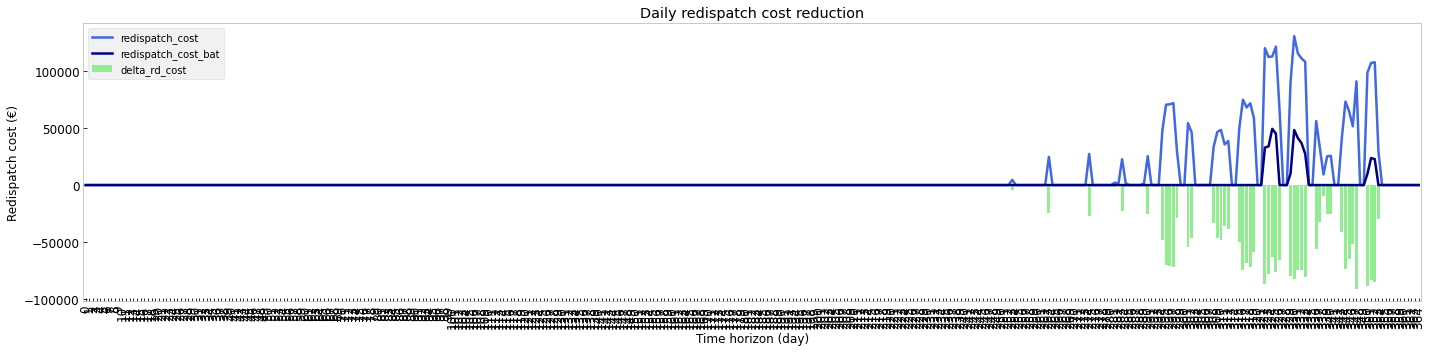

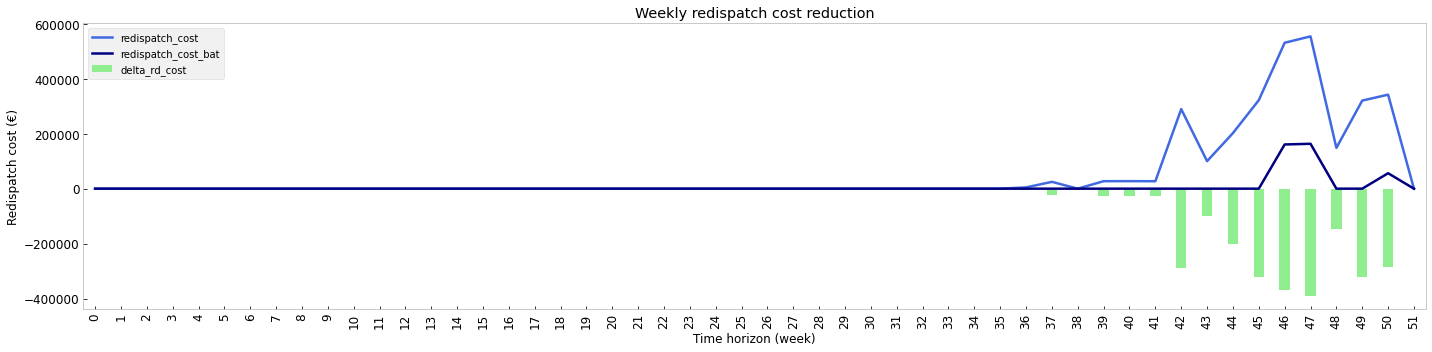

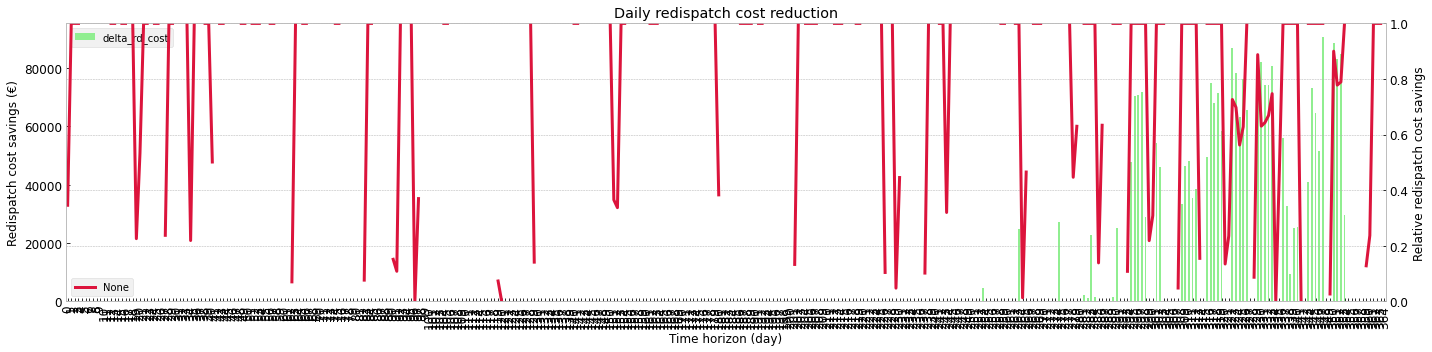

In [8]:
# Plot MANUAL objective insights
# --------------
colors = ["royalblue","navy","lightgreen"]

# Redispatch cost difference per day
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax  = plt.subplots(figsize = (20, 5))
ax.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
ax = df_obj_day[cols].plot.line(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_day["delta_rd_cost"].plot.bar(stacked = False, ax = ax, title = "Daily redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.8, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Redispatch cost difference per week
cols = ["redispatch_cost","redispatch_cost_bat"]
fig, ax1  = plt.subplots(figsize = (20, 5))
ax1.set_ylabel('Redispatch cost (€)',  fontsize = 12)
ax1.set_xlabel("Time horizon (week)", fontsize = 12)
ax1 = df_obj_week[cols].plot.line(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = colors, legend = True, linewidth = 2.5, fontsize = 12)
df_obj_week["delta_rd_cost"].plot.bar(stacked = False, ax = ax1, title = "Weekly redispatch cost reduction", 
                                   color = "lightgreen", legend = True, width = 0.4, fontsize = 12)
ax1.set_facecolor('white')
ax1.grid(color = 'lightgrey', linestyle = '-.', linewidth = 1.0)
ax1.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Relative redispatch cost savings vs absolute savings
fig, ax2  = plt.subplots(figsize = (20, 5))
ax2.set_ylabel('Redispatch cost savings (€)',  fontsize = 12)
ax2.set_xlabel("Time horizon (day)", fontsize = 12)
ax2 = df_obj_day["delta_rd_cost"].abs().plot.bar(stacked = False, ax = ax2, title = "Daily redispatch cost reduction", 
                                   color = ["lightgreen"], legend = True, fontsize = 12)
ax2.set_facecolor('white')
ax2.legend(loc = "upper left")
ax2.grid(color = 'gainsboro', linestyle = '-.', linewidth = 1.0)
ax2.set_axisbelow(True)

# TODO: REMOVE GRAPH OFFSET

ax2_ = ax2.twinx()
(df_obj_day["delta_rd_cost"] / df_obj_day["redispatch_cost"]).abs().plot.line(ax = ax2_, linewidth = 3, 
                                           color = "crimson", legend = True, fontsize = 12)
ax2_.set_ylabel('Relative redispatch cost savings',  fontsize = 12)
ax2_.set_ylim(0,1.0)
fig.tight_layout()
plt.show()

# Analysis of redispatch energy reduction incl. dynamic time warping


In [9]:
# Reduction of redispatch energy (positive and negative)
# ---------------

# Redispatch power dataframe
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]         
df_rd_p = network_rd.generators_t.p[cols_rd]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd]
# sum of positive redispatch
cols_pos = [column for column in list(df_rd_p) if "pos" in column]
df_rd_p["Positive redispatch"] = df_rd_p.loc[:,cols_pos].sum(axis = 1)
df_rd_p_bat["Positive redispatch bat"] = df_rd_p_bat.loc[:,cols_pos].sum(axis = 1)
# sum of negative redispatch
cols_neg = [column for column in list(df_rd_p_bat) if "neg" in column]
df_rd_p["Negative redispatch"] = df_rd_p.loc[:,cols_neg].sum(axis = 1)
df_rd_p_bat["Negative redispatch bat"] = df_rd_p_bat.loc[:,cols_neg].sum(axis = 1)

# Difference of redispatch (pos/neg) and total redispatch datarame
df_bat_nobat = pd.concat([df_rd_p[["Negative redispatch", "Positive redispatch"]], 
                             df_rd_p_bat[["Negative redispatch bat", "Positive redispatch bat"]]], 
                            axis = 1)

# differences in redispatch bat vs no bat
df_bat_nobat = df_bat_nobat.round(2)
df_bat_nobat["Difference in curtailment"] = df_bat_nobat.iloc[:,2] - df_bat_nobat.iloc[:,0]
df_bat_nobat["Difference in ramp-up"] = df_bat_nobat.iloc[:,3] - df_bat_nobat.iloc[:,1]
df_bat_nobat["Total redispatch"] = abs(df_bat_nobat["Negative redispatch"]) + abs(df_bat_nobat["Positive redispatch"])
df_bat_nobat["Total redispatch bat"] = abs(df_bat_nobat["Negative redispatch bat"]) + abs(df_bat_nobat["Positive redispatch bat"])
df_bat_nobat["Total redispatch difference"] = df_bat_nobat["Total redispatch bat"] - df_bat_nobat["Total redispatch"]
df_bat_nobat.index.rename("Time horizon (hour)", inplace = True)
df_bat_nobat = df_bat_nobat.append(df_bat_nobat.sum(axis = 0), ignore_index = True)

# Create daily dataframe 
df_bat_nobat_day = df_bat_nobat.iloc[:-1].groupby(np.arange(len(df_obj))//24).sum()
df_bat_nobat_day.index.rename("Time horizon (day)", inplace = True)
display(df_bat_nobat_day)

# Analyze: are the days of most cost reduction also the days of most redispatch power in the no_bat scenario?
# --------------

def get_dtw_diff_matrix(cols:list, df_dtw):
    """
    From a list of column names referring to a pandas dataframe with series as columns, compute a distance matrix by computing the 
    DTW distance of all pairwise combinations of series. I take the column names as input so it does reduce the complexity when indexing.
    """
    diff_matrix = {}
    cross = itertools.product(cols, cols)
    for (col1, col2) in cross:
        series1 = df_dtw[col1]
        series2 = df_dtw[col2]
        #print(series1,series2)
        # measure difference dtw
        diff = dtw(series1, 
                   series2, 
                   keep_internals=True, 
                   step_pattern=rabinerJuangStepPattern(2, "c")).normalizedDistance
        diff_matrix[(col1 , col2)] = [diff]
    # convert to pandas dataframe    
    dtw_diff_df = pd.DataFrame(diff_matrix).T.reset_index()\
      .rename(columns = {"level_0":"Delta_obj_day", "level_1":"Total redispatch", 0:"diff"})\
      .pivot_table(index = "Delta_obj_day", columns = "Total redispatch", values = "diff")
    return dtw_diff_df




# Create dtw dataframe for comparison of redispatch cost savings and total redispatch energy in nobat scenario
df_dtw = pd.concat([df_bat_nobat_day["Total redispatch"], - df_obj_day["delta_rd_cost"]], axis = 1).round(2)
df_dtw[df_dtw == -0.0] = 0
scaler = MinMaxScaler()
df_dtw[["Total redispatch","delta_rd_cost"]] = scaler.fit_transform(df_dtw[["Total redispatch","delta_rd_cost"]])
# distance object
dtw_diff = dtw(df_dtw.iloc[-40:, 0], df_dtw.iloc[-40:, 1], keep_internals=True, 
               step_pattern=rabinerJuangStepPattern(2, "b"))
# Distance matrix
dtw_diff_df = get_dtw_diff_matrix(list(df_dtw), df_dtw)
display(dtw_diff_df)

# WHy dynamic time warping? Because dtw can not only identify direct euclidian similarities for every point but also determine wheather
# two time series have a similar trend (which is just zeitversetzt), e.g. a very high total redispatch in t = T is usually followed by 
# a large delta_rd_costs every t = T + 2. Euclidian distance would measure no similarity here!


name,Negative redispatch,Positive redispatch,Negative redispatch bat,Positive redispatch bat,Difference in curtailment,Difference in ramp-up,Total redispatch,Total redispatch bat,Total redispatch difference
Time horizon (day),,,,,,,,,
0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
2,0.0,0.0,-776.81,0.0,-776.81,0.0,0.0,776.81,776.81
3,0.0,0.0,-1530.61,0.0,-1530.61,0.0,0.0,1530.61,1530.61
4,0.0,0.0,-761.28,0.0,-761.28,0.0,0.0,761.28,761.28
...,...,...,...,...,...,...,...,...,...
360,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
361,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00
362,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00


Total redispatch,Total redispatch,delta_rd_cost
Delta_obj_day,,
Total redispatch,0.000000,0.014901
delta_rd_cost,0.015906,0.000000


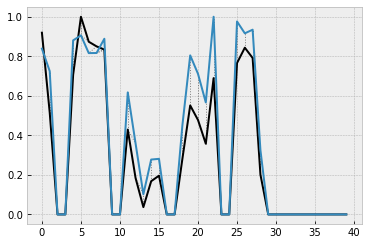

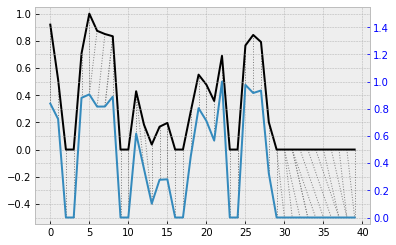

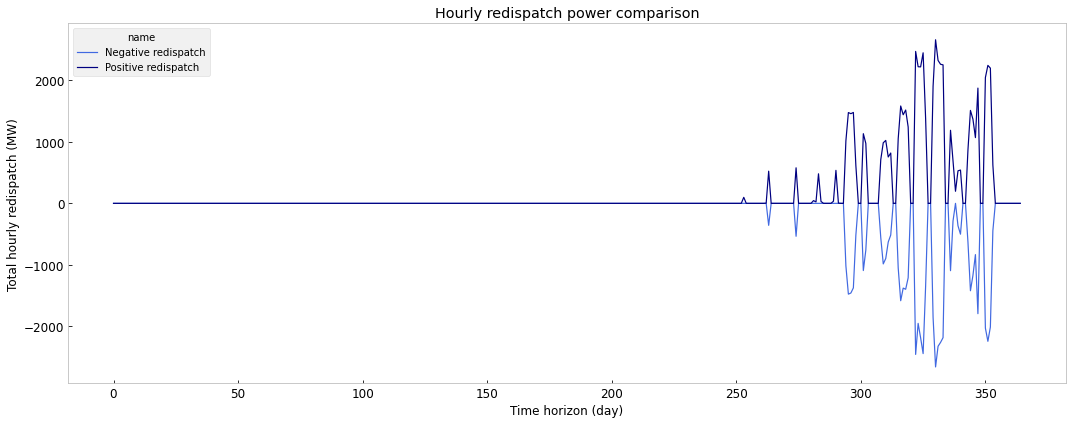

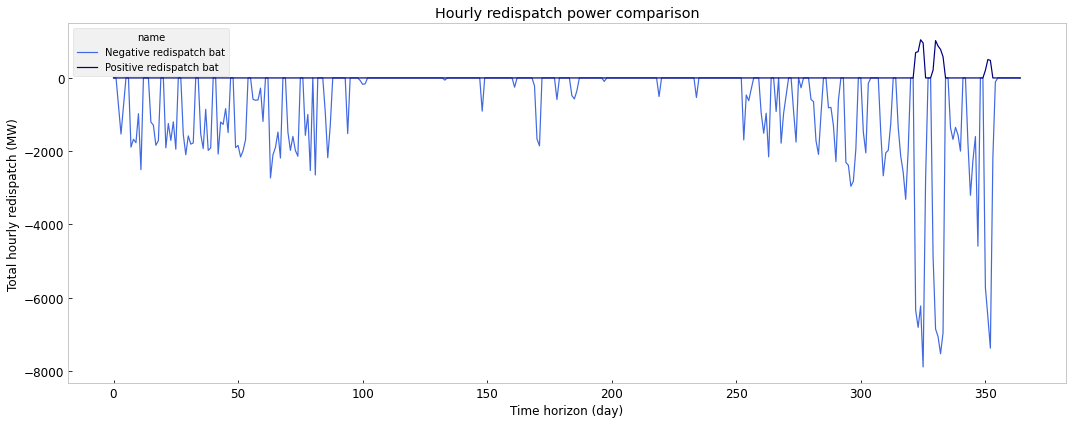

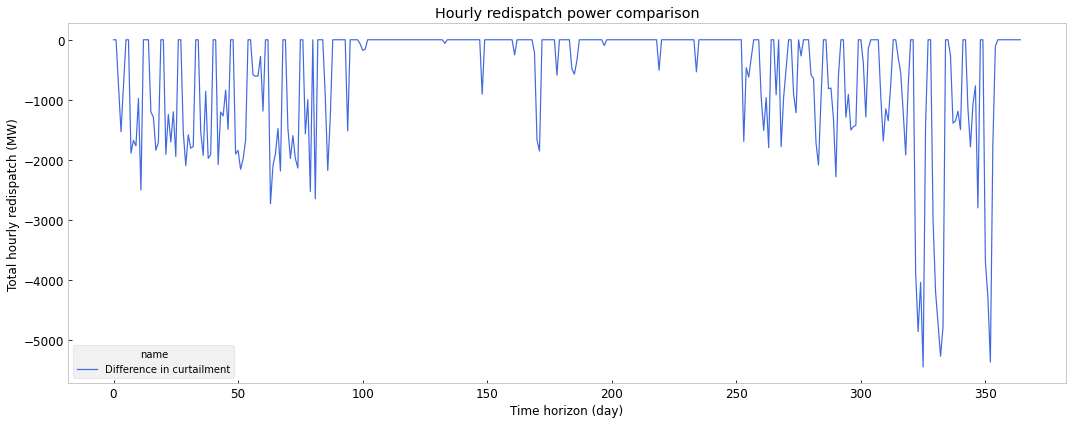

In [10]:
# Plots of objective and redispatch power reduction
# ------------

# Dynamic time warping distance between  cost difference per day (examplary)
ax = dtw_diff.plot(type="twoway")
ax = dtw_diff.plot(type="twoway", offset = -0.5)

# Negative and positive redispatch w/o bat
cols = ["Negative redispatch","Positive redispatch"]
fig, ax  = plt.subplots(figsize = (15, 6))
ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                   color = colors, legend = True, linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


# Negative and positive redispatch WITH bat
cols = ["Negative redispatch bat","Positive redispatch bat"]
fig, ax  = plt.subplots(figsize = (15, 6))
ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                   color = colors, legend = True, linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


# Plot difference in curtailment energy bat vs nobat
cols = ["Difference in curtailment"]
fig, ax  = plt.subplots(figsize = (15, 6))
ax.set_ylabel('Total hourly redispatch (MW)',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly redispatch power comparison", 
                                   color = colors, legend = True, linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()





# Difference Merit order (dispatch) -> Reorganization of dispatch

In [14]:
# Map the change in merit order
# ------------------

# # DONE: ASK AND CHECK FOR NODAL POWER BALANCE CONSTRAINT --- LOADS > GENERATION?? 
# # REASON: different utilization in storage units.
# df_disp = network_d.generators_t.p.copy()
# df_disp["sum"] = df_disp.sum(axis= 1)
# df_redisp = network_rd.generators_t.p.copy()
# df_redisp["sum"] = df_redisp.sum(axis= 1)
# df_load_t = network_d.loads_t.p.copy()
# df_load_t["sum"] = df_load_t.sum(axis= 1)
# # df_stor = network_d.storage_units_t.p.copy()
# # df_stor["sum"] = df_stor.sum(axis=1)
# df_stor_rd = network_rd.storage_units_t.p.copy()
# df_stor_rd["sum"] = df_stor_rd.sum(axis=1)
# display(df_stor.head(5))
# display(df_stor_rd.head(5))
# display(df_disp.head(5))
# display(df_redisp.head(5))
# display(df_load_t.head(5))

# Generate Merit order per day
df_gen = network_d.generators.copy()
dict_prices = df_gen.groupby(["carrier"]).mean()["marginal_cost"].round(4).to_dict()
dict_prices["offwind"] = dict_prices.pop("offwind-ac")
dict_prices.pop("offwind-dc")
for key in dict_prices:
    if dict_prices[key] == 0:
        dict_prices.update({key: 0.01})
pprint(dict_prices)
                           
# Create dataframe with dispatch by carrier
df_dispatch = network_d.generators_t.p.copy()
cols_CCGT = [column for column in list(df_dispatch) if "CCGT" in column]
cols_OCGT = [column for column in list(df_dispatch) if "OCGT" in column]
cols_oil = [column for column in list(df_dispatch) if "oil" in column]
cols_lignite = [column for column in list(df_dispatch) if "lignite" in column]
cols_nuclear = [column for column in list(df_dispatch) if "nuclear" in column]
cols_coal = [column for column in list(df_dispatch) if "coal" in column]
cols_biomass = [column for column in list(df_dispatch) if "biomass" in column]
cols_offwind = [column for column in list(df_dispatch) if "offwind" in column]
cols_onwind = [column for column in list(df_dispatch) if "onwind" in column]
cols_solar = [column for column in list(df_dispatch) if "solar" in column]
cols_runofriver = [column for column in list(df_dispatch) if "ror" in column]

df_dispatch["OCGT"] = df_dispatch[cols_OCGT].sum(axis = 1)
df_dispatch["CCGT"] = df_dispatch[cols_CCGT].sum(axis = 1)
df_dispatch["oil"] = df_dispatch[cols_oil].sum(axis = 1)
df_dispatch["lignite"] = df_dispatch[cols_lignite].sum(axis = 1)
df_dispatch["nuclear"] = df_dispatch[cols_nuclear].sum(axis = 1)
df_dispatch["coal"] = df_dispatch[cols_coal].sum(axis = 1)
df_dispatch["biomass"] = df_dispatch[cols_biomass].sum(axis = 1)
df_dispatch["offwind"] = df_dispatch[cols_offwind].sum(axis = 1)
df_dispatch["onwind"] = df_dispatch[cols_onwind].sum(axis = 1)
df_dispatch["solar"] = df_dispatch[cols_solar].sum(axis = 1)
df_dispatch["ror"] = df_dispatch[cols_runofriver].sum(axis = 1)
df_merit = df_dispatch.loc[:,"OCGT":"ror"]

# Map Marginal prices and sort dataframe for merit order
df_merit = df_merit.T.round(4)
df_merit['Marginal price'] = df_merit.index.map(dict_prices)
df_merit = df_merit.sort_values(by = "Marginal price", axis = 0)
df_merit = df_merit.T
# Control sum
df_merit["sum"] = df_merit.sum(axis = 1)

# Generate Merit order AFTER REDISPATCH
df_redis = network_rd.generators_t.p.copy()
cols_CCGT =    [column for column in list(df_redis) if "CCGT" in column]
cols_OCGT =    [column for column in list(df_redis) if "OCGT" in column]
cols_oil =     [column for column in list(df_redis) if "oil" in column]
cols_lignite = [column for column in list(df_redis) if "lignite" in column]
cols_nuclear = [column for column in list(df_redis) if "nuclear" in column]
cols_coal =    [column for column in list(df_redis) if "coal" in column]
cols_biomass = [column for column in list(df_redis) if "biomass" in column]
cols_offwind = [column for column in list(df_redis) if "offwind" in column]
cols_onwind =  [column for column in list(df_redis) if "onwind" in column]
cols_solar =   [column for column in list(df_redis) if "solar" in column]
cols_runofriver = [column for column in list(df_redis) if "ror" in column]
df_redis["OCGT"] =    df_redis[cols_OCGT].sum(axis = 1)
df_redis["CCGT"] =    df_redis[cols_CCGT].sum(axis = 1)
df_redis["oil"] =     df_redis[cols_oil].sum(axis = 1)
df_redis["lignite"] = df_redis[cols_lignite].sum(axis = 1)
df_redis["nuclear"] = df_redis[cols_nuclear].sum(axis = 1)
df_redis["coal"] =    df_redis[cols_coal].sum(axis = 1)
df_redis["biomass"] = df_redis[cols_biomass].sum(axis = 1)
df_redis["offwind"] = df_redis[cols_offwind].sum(axis = 1)
df_redis["onwind"] =  df_redis[cols_onwind].sum(axis = 1)
df_redis["solar"] =   df_redis[cols_solar].sum(axis = 1)
df_redis["ror"] =     df_redis[cols_runofriver].sum(axis = 1)
df_merit_rd = df_redis.loc[:,"OCGT":"ror"]
df_merit_rd = df_merit_rd.T.round(4)
df_merit_rd['Marginal price'] = df_merit_rd.index.map(dict_prices)
df_merit_rd = df_merit_rd.sort_values(by = "Marginal price", axis = 0)
df_merit_rd = df_merit_rd.T
df_merit_rd["sum"] = df_merit_rd.sum(axis = 1)

# Generate Merit order AFTER REDISPATCH with BAT
df_redis_bat = network_rd_bat.generators_t.p.copy()
cols_CCGT =    [column for column in list(df_redis_bat) if "CCGT" in column]
cols_OCGT =    [column for column in list(df_redis_bat) if "OCGT" in column]
cols_oil =     [column for column in list(df_redis_bat) if "oil" in column]
cols_lignite = [column for column in list(df_redis_bat) if "lignite" in column]
cols_nuclear = [column for column in list(df_redis_bat) if "nuclear" in column]
cols_coal =    [column for column in list(df_redis_bat) if "coal" in column]
cols_biomass = [column for column in list(df_redis_bat) if "biomass" in column]
cols_offwind = [column for column in list(df_redis_bat) if "offwind" in column]
cols_onwind =  [column for column in list(df_redis_bat) if "onwind" in column]
cols_solar =   [column for column in list(df_redis_bat) if "solar" in column]
cols_runofriver = [column for column in list(df_redis_bat) if "ror" in column]
df_redis_bat["OCGT"] =    df_redis_bat[cols_OCGT].sum(axis = 1)
df_redis_bat["CCGT"] =    df_redis_bat[cols_CCGT].sum(axis = 1)
df_redis_bat["oil"] =     df_redis_bat[cols_oil].sum(axis = 1)
df_redis_bat["lignite"] = df_redis_bat[cols_lignite].sum(axis = 1)
df_redis_bat["nuclear"] = df_redis_bat[cols_nuclear].sum(axis = 1)
df_redis_bat["coal"] =    df_redis_bat[cols_coal].sum(axis = 1)
df_redis_bat["biomass"] = df_redis_bat[cols_biomass].sum(axis = 1)
df_redis_bat["offwind"] = df_redis_bat[cols_offwind].sum(axis = 1)
df_redis_bat["onwind"] =  df_redis_bat[cols_onwind].sum(axis = 1)
df_redis_bat["solar"] =   df_redis_bat[cols_solar].sum(axis = 1)
df_redis_bat["ror"] =     df_redis_bat[cols_runofriver].sum(axis = 1)
df_merit_rd_bat = df_redis_bat.loc[:,"OCGT":"ror"]
df_merit_rd_bat = df_merit_rd_bat.T.round(4)
df_merit_rd_bat['Marginal price'] = df_merit_rd_bat.index.map(dict_prices)
df_merit_rd_bat = df_merit_rd_bat.sort_values(by = "Marginal price", axis = 0)
df_merit_rd_bat = df_merit_rd_bat.T
df_merit_rd_bat["sum"] = df_merit_rd_bat.sum(axis = 1)


# display(df_merit)
# display(df_merit_rd)
# # display(df_merit_rd_bat)

# Generate DAILY merit order dataframes
df_merit_day = df_merit.iloc[:-1].groupby(np.arange(len(df_merit.iloc[:-1]))//24).sum()
df_merit_rd_day = df_merit_rd.iloc[:-1].groupby(np.arange(len(df_merit_rd.iloc[:-1]))//24).sum()
df_merit_rd_bat_day = df_merit_rd_bat.iloc[:-1].groupby(np.arange(len(df_merit_rd_bat.iloc[:-1]))//24).sum()

# display(df_merit_day)
# display(df_merit_rd_day)
# display(df_merit_rd_bat_day)

# METHODOLOGIE: Untersuche den shift der merit order dispatch -> redispatch (bat vs. nobat) an Tagen mit 
# a) den GRÖSSTEN  Ensparungen an redispatch kosten
# b) biggest grid loads
# c) smallest grid loads

# a) Gather 5 days with biggest redispatch cost savings
df_obj_l = df_obj.nsmallest(5, "delta_rd_cost")
l_obj_largest = df_obj_l.index.to_list()
df_merit_obj = df_merit.loc[l_obj_largest]
df_merit_rd_obj = df_merit_rd.loc[l_obj_largest]
df_merit_rd_bat_obj = df_merit_rd.loc[l_obj_largest]

# b) & c) Gather 5 days with biggest & smallest loads
df_merit_s = df_merit.iloc[:-1].nsmallest(5, 'sum')
df_merit_l = df_merit.iloc[:-1].nlargest(5, 'sum')
l_nlargest = df_merit_l.index.to_list()
l_nsmallest = df_merit_s.index.to_list()

# Generate redispatch & rd_bat dataframes with merit order of these days
df_merit_rd_l = df_merit_rd.loc[l_nlargest]
df_merit_rd_s = df_merit_rd.loc[l_nsmallest]
df_merit_rd_bat_l = df_merit_rd_bat.loc[l_nlargest]
df_merit_rd_bat_s = df_merit_rd_bat.loc[l_nsmallest]

display(df_merit_l)
display(df_merit_rd_l)
display(df_merit_rd_bat_l)
display(df_merit_rd_bat_obj)

{'CCGT': 47.2,
 'OCGT': 58.3846,
 'biomass': 14.9573,
 'coal': 24.1034,
 'lignite': 13.4877,
 'nuclear': 16.9021,
 'offwind': 0.015,
 'oil': 130.2265,
 'onwind': 0.015,
 'ror': 0.01,
 'solar': 0.01}


,sum_curtailment_cost,sum_curtailment_cost_bat,sum_ramp_cost,sum_ramp_cost_bat,redispatch_cost,redispatch_cost_bat,delta_ramp_cost,delta_curtailment_cost,delta_rd_cost
name,,,,,,,,,
2018-12-17 13:00:00,0.0,0.0,13774.884615,0.000000,13774.884615,0.000000,-13774.884615,0.0,-13774.884615
2018-12-19 13:00:00,0.0,0.0,13774.884615,0.000000,13774.884615,0.000000,-13774.884615,0.0,-13774.884615
2018-12-14 07:00:00,0.0,0.0,13401.210023,0.000000,13401.210023,0.000000,-13401.210023,0.0,-13401.210023
2018-11-28 06:00:00,0.0,0.0,13360.218388,234.386506,13360.218388,234.386506,-13125.831882,0.0,-13125.831882
2018-12-11 07:00:00,0.0,0.0,12712.942226,0.000000,12712.942226,0.000000,-12712.942226,0.0,-12712.942226


name,solar,ror,offwind,onwind,lignite,biomass,nuclear,coal,CCGT,OCGT,oil,sum
name,,,,,,,,,,,,
2018-02-28 18:00:00,0.0000,2907.5794,0.0170,0.0760,20833.5,839.02,15788.4386,28069.3798,12060.0706,0.0,0.0,80498.0814
2018-02-28 17:00:00,0.0031,2907.5794,0.0167,0.0654,20833.5,839.02,15788.4386,28069.3798,11908.9968,0.0,0.0,80346.9998
2018-02-27 18:00:00,0.0000,2907.5794,0.0169,0.0287,20833.5,839.02,15788.4386,28069.3798,11438.8222,0.0,0.0,79876.7856
2018-02-27 17:00:00,0.0008,2907.5794,0.0163,0.0277,20833.5,839.02,15788.4386,28069.3798,11358.8434,0.0,0.0,79796.8060
2018-03-01 18:00:00,0.0000,2907.5794,0.0171,0.0852,20833.5,839.02,15788.4386,28069.3798,10991.3471,0.0,0.0,79429.3672


name,solar,ror,offwind,onwind,lignite,biomass,nuclear,coal,CCGT,OCGT,oil,sum
name,,,,,,,,,,,,
2018-02-28 18:00:00,0.0000,2907.5794,0.0170,0.0760,20833.5,839.02,15788.4387,28069.3798,9767.8706,0.0,0.0,78205.8815
2018-02-28 17:00:00,0.0031,2907.5794,0.0167,0.0654,20833.5,839.02,15788.4387,28069.3798,11680.9968,0.0,0.0,80118.9999
2018-02-27 18:00:00,0.0000,2907.5794,0.0169,0.0287,20833.5,839.02,15788.4387,28069.3798,10744.9022,0.0,0.0,79182.8657
2018-02-27 17:00:00,0.0008,2907.5794,0.0163,0.0277,20833.5,839.02,15788.4387,28069.3798,10271.8434,0.0,0.0,78709.8061
2018-03-01 18:00:00,0.0000,2907.5794,0.0171,0.0852,20833.5,839.02,15788.4387,28069.3798,9820.2471,0.0,0.0,78258.2673


name,solar,ror,offwind,onwind,lignite,biomass,nuclear,coal,CCGT,OCGT,oil,sum
name,,,,,,,,,,,,
2018-02-28 18:00:00,0.0000,2907.5794,0.0170,0.0760,20833.5,839.02,15788.4387,28069.3798,9767.8706,0.0,0.0,78205.8815
2018-02-28 17:00:00,0.0031,2907.5794,0.0167,0.0654,20833.5,839.02,15788.4387,28069.3798,11680.9968,0.0,0.0,80118.9999
2018-02-27 18:00:00,0.0000,2907.5794,0.0169,0.0287,20833.5,839.02,15788.4387,28069.3798,10744.9022,0.0,0.0,79182.8657
2018-02-27 17:00:00,0.0008,2907.5794,0.0163,0.0277,20833.5,839.02,15788.4387,28069.3798,10271.8434,0.0,0.0,78709.8061
2018-03-01 18:00:00,0.0000,2907.5794,0.0171,0.0852,20833.5,839.02,15788.4387,28069.3798,9820.2471,0.0,0.0,78258.2673


name,solar,ror,offwind,onwind,lignite,biomass,nuclear,coal,CCGT,OCGT,oil,sum
name,,,,,,,,,,,,
2018-12-17 13:00:00,0.0203,316.4635,0.0024,0.0186,20833.5,839.02,15788.4387,28069.3798,6050.0485,98.5000,0.0,71995.3918
2018-12-19 13:00:00,0.0093,326.5645,0.0118,0.0266,20833.5,839.02,15788.4387,28069.3798,2654.7789,98.5000,0.0,68610.2296
2018-12-14 07:00:00,0.0000,636.4748,0.0049,0.0147,20833.5,839.02,15788.4387,28069.3798,4333.9343,92.0998,0.0,70592.8670
2018-11-28 06:00:00,0.0000,317.4959,0.0096,0.0338,20833.5,839.02,15788.4387,28069.3798,7120.0283,91.3977,0.0,73059.3038
2018-12-11 07:00:00,0.0000,721.8223,0.0161,0.0654,20833.5,839.02,15788.4387,28069.3798,4228.3619,80.3113,0.0,70560.9155


name,solar,ror,offwind,onwind,lignite,biomass,nuclear,coal,CCGT,OCGT,oil,sum
name,,,,,,,,,,,,
2018-02-28 18:00:00,0.0000,2907.5794,0.0170,0.0760,20833.5,839.02,15788.4386,28069.3798,12060.0706,0.0,0.0,80498.0814
2018-02-28 17:00:00,0.0031,2907.5794,0.0167,0.0654,20833.5,839.02,15788.4386,28069.3798,11908.9968,0.0,0.0,80346.9998
2018-02-27 18:00:00,0.0000,2907.5794,0.0169,0.0287,20833.5,839.02,15788.4386,28069.3798,11438.8222,0.0,0.0,79876.7856
2018-02-27 17:00:00,0.0008,2907.5794,0.0163,0.0277,20833.5,839.02,15788.4386,28069.3798,11358.8434,0.0,0.0,79796.8060
2018-03-01 18:00:00,0.0000,2907.5794,0.0171,0.0852,20833.5,839.02,15788.4386,28069.3798,10991.3471,0.0,0.0,79429.3672


name,solar,ror,offwind,onwind,lignite,biomass,nuclear,coal,CCGT,OCGT,oil,sum
name,,,,,,,,,,,,
2018-02-28 18:00:00,0.0000,2907.5794,0.0170,0.0760,20833.5,839.02,15788.4387,28069.3798,9767.8706,0.0,0.0,78205.8815
2018-02-28 17:00:00,0.0031,2907.5794,0.0167,0.0654,20833.5,839.02,15788.4387,28069.3798,11680.9968,0.0,0.0,80118.9999
2018-02-27 18:00:00,0.0000,2907.5794,0.0169,0.0287,20833.5,839.02,15788.4387,28069.3798,10744.9022,0.0,0.0,79182.8657
2018-02-27 17:00:00,0.0008,2907.5794,0.0163,0.0277,20833.5,839.02,15788.4387,28069.3798,10271.8434,0.0,0.0,78709.8061
2018-03-01 18:00:00,0.0000,2907.5794,0.0171,0.0852,20833.5,839.02,15788.4387,28069.3798,9820.2471,0.0,0.0,78258.2673


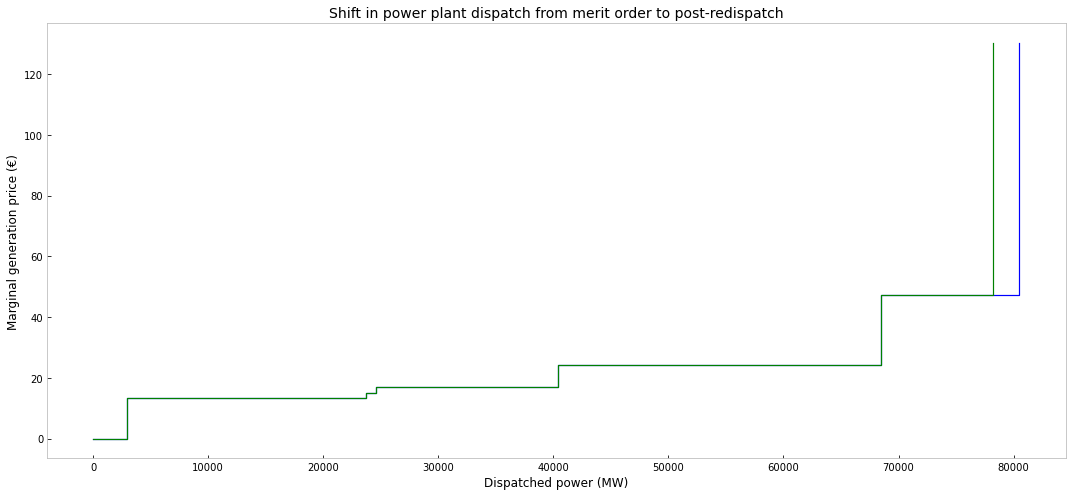

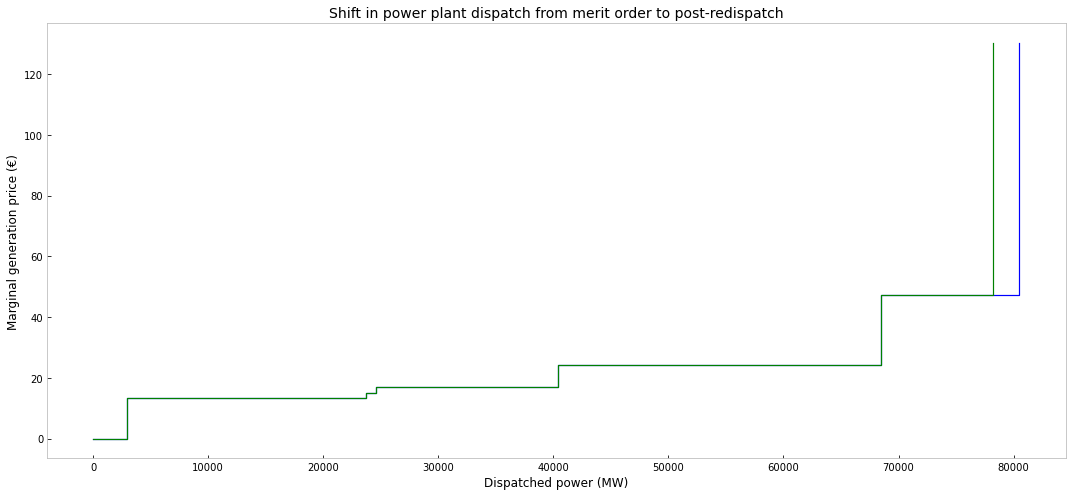

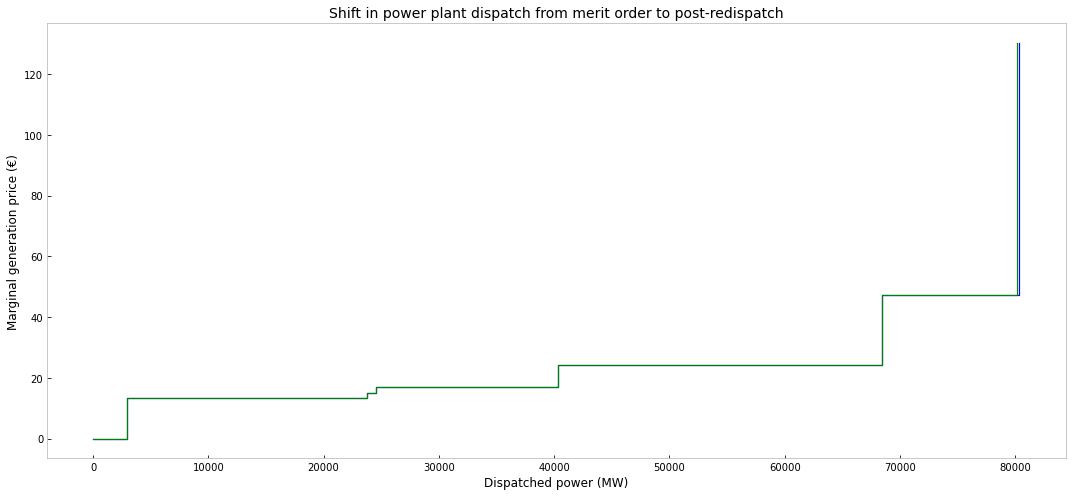

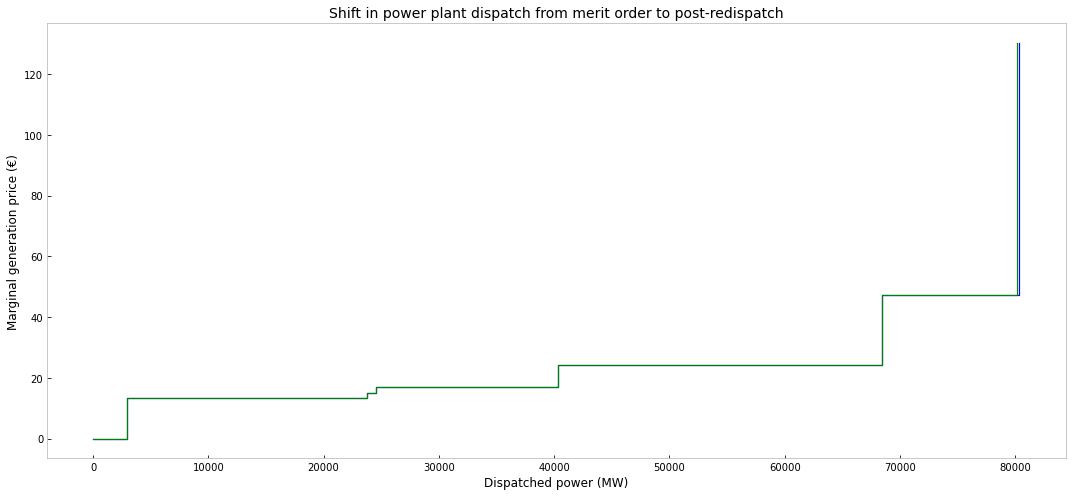

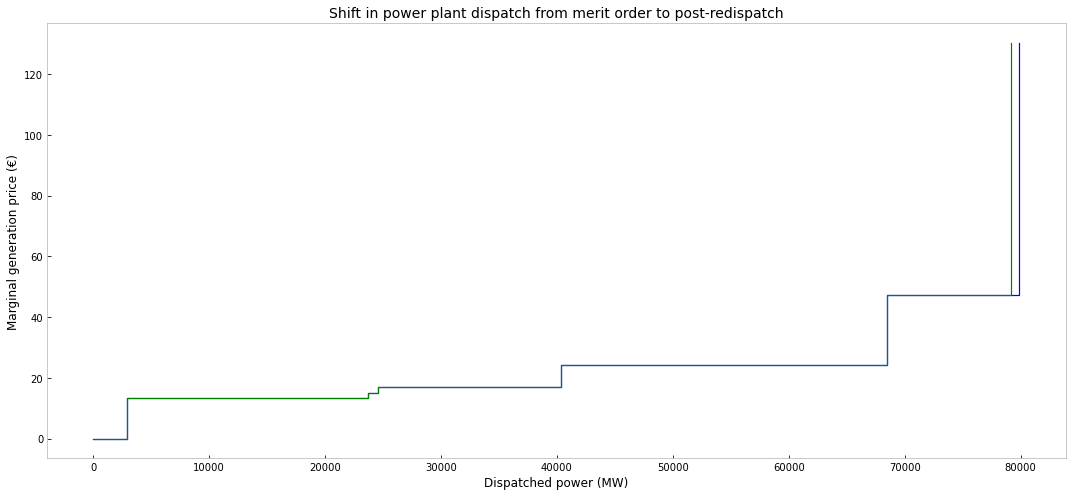

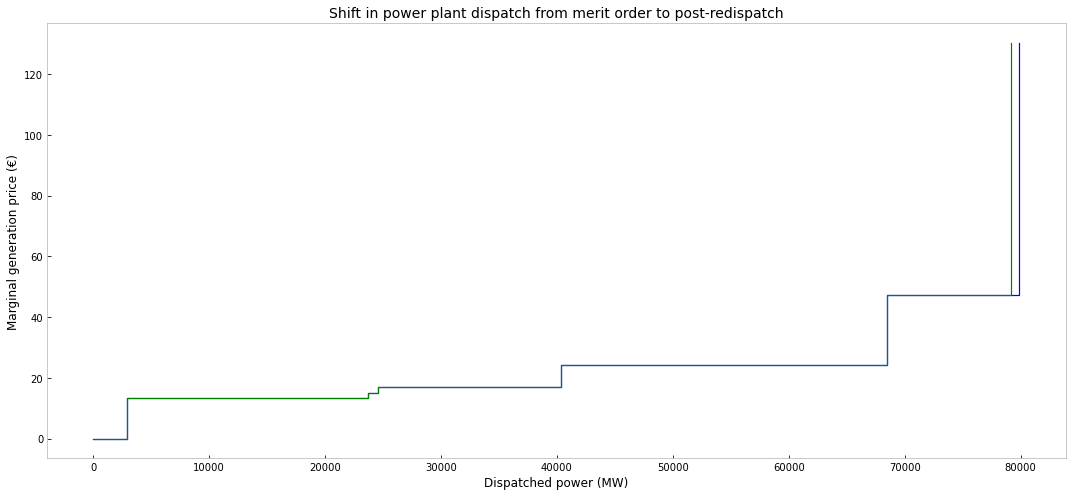

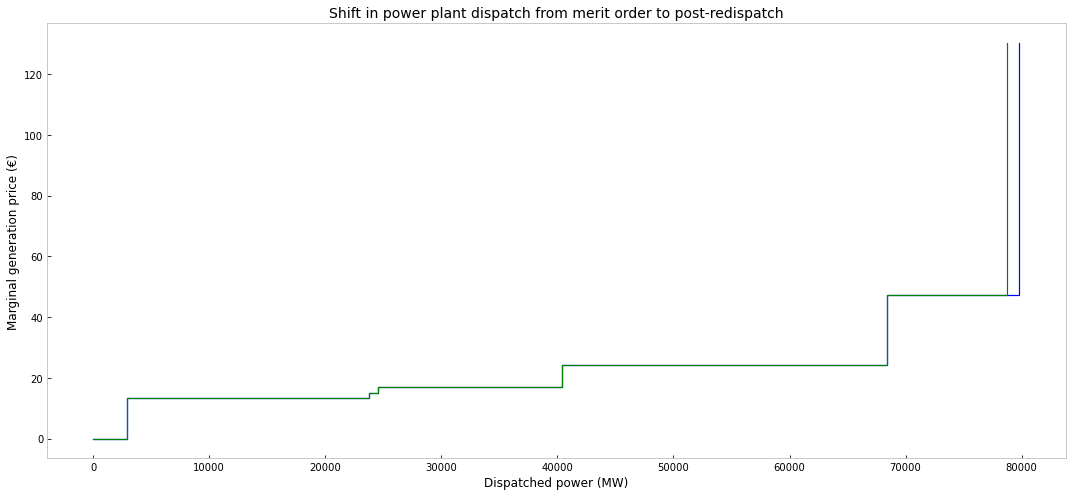

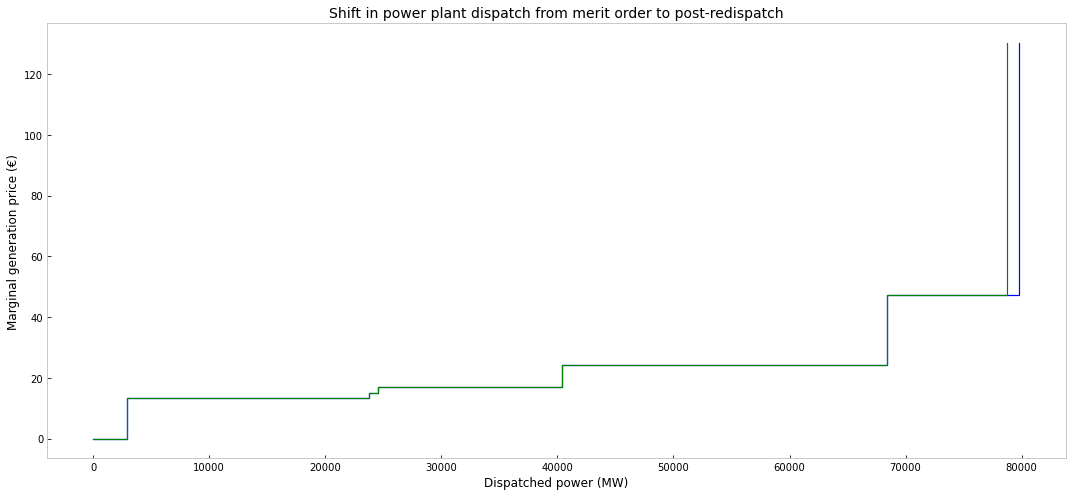

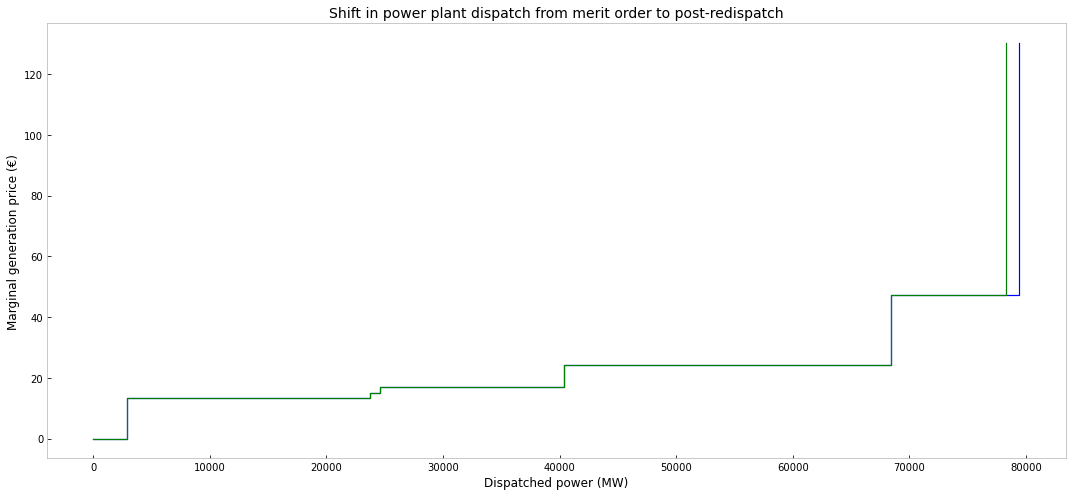

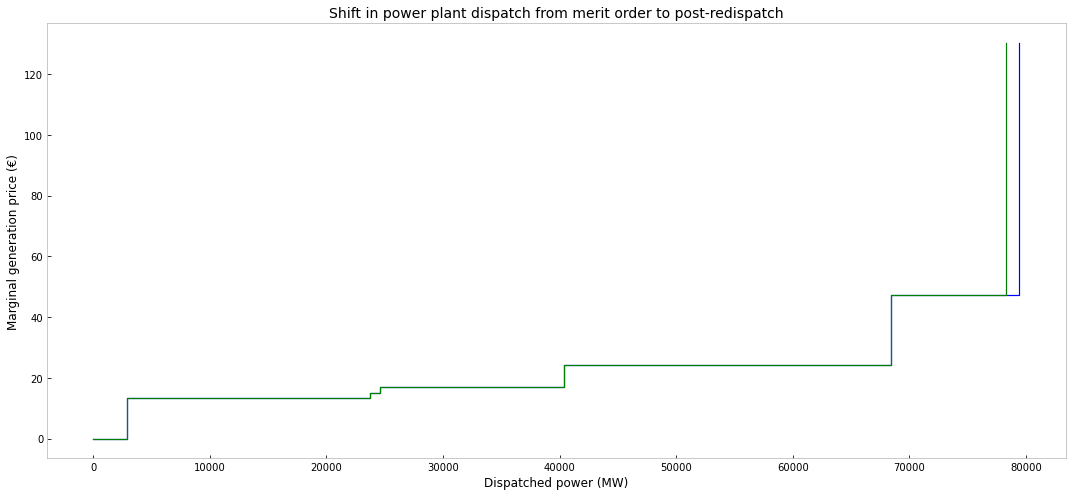

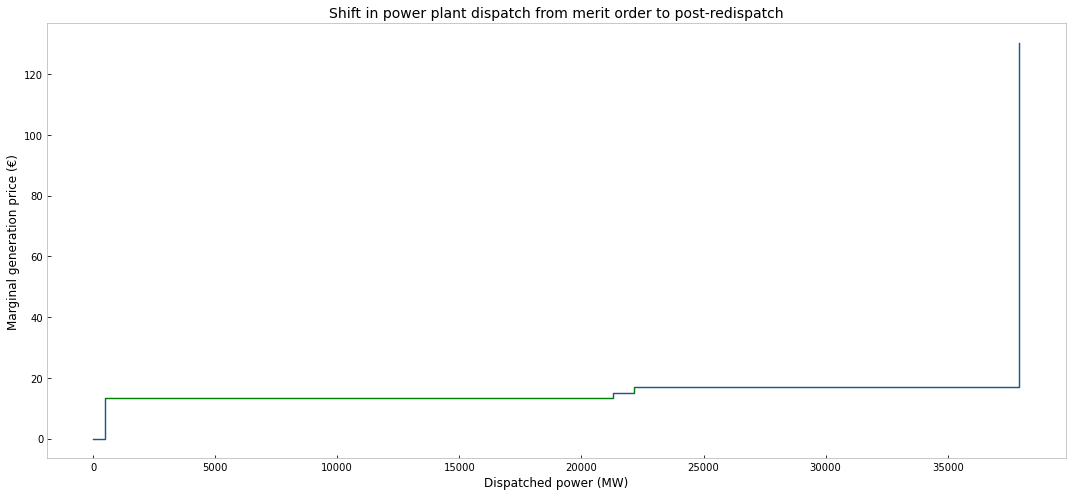

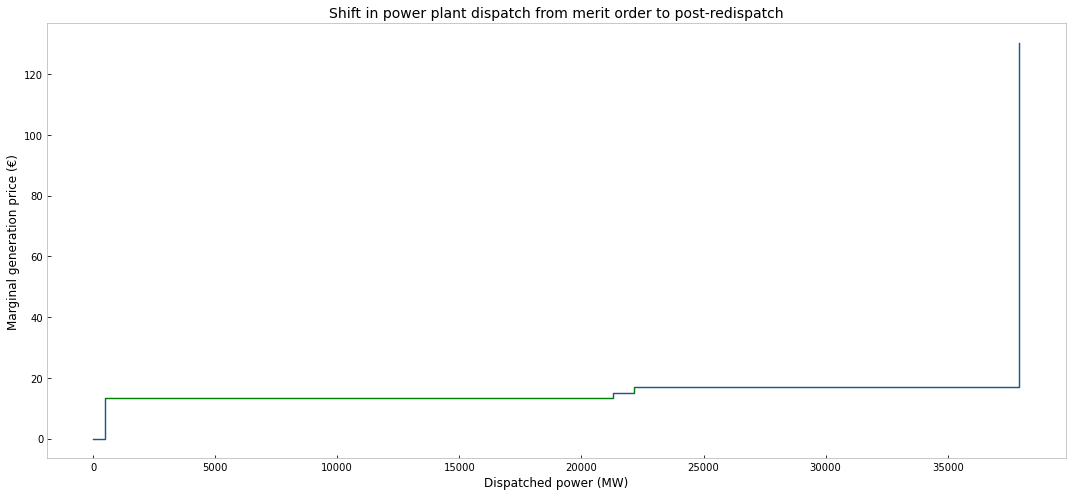

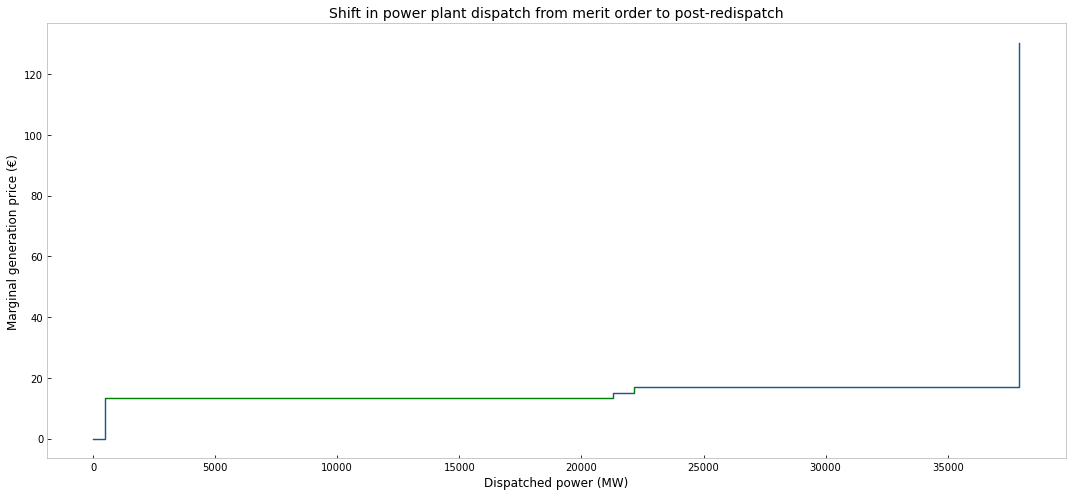

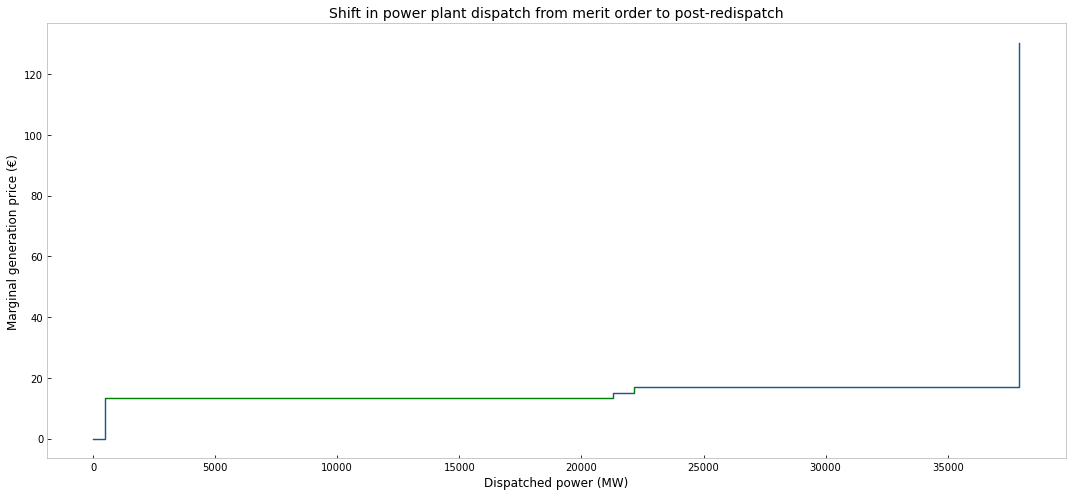

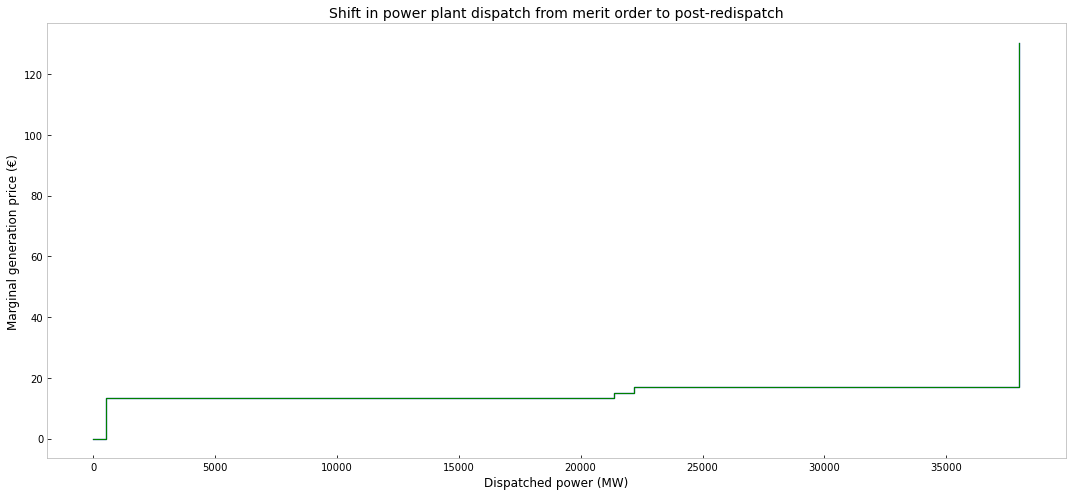

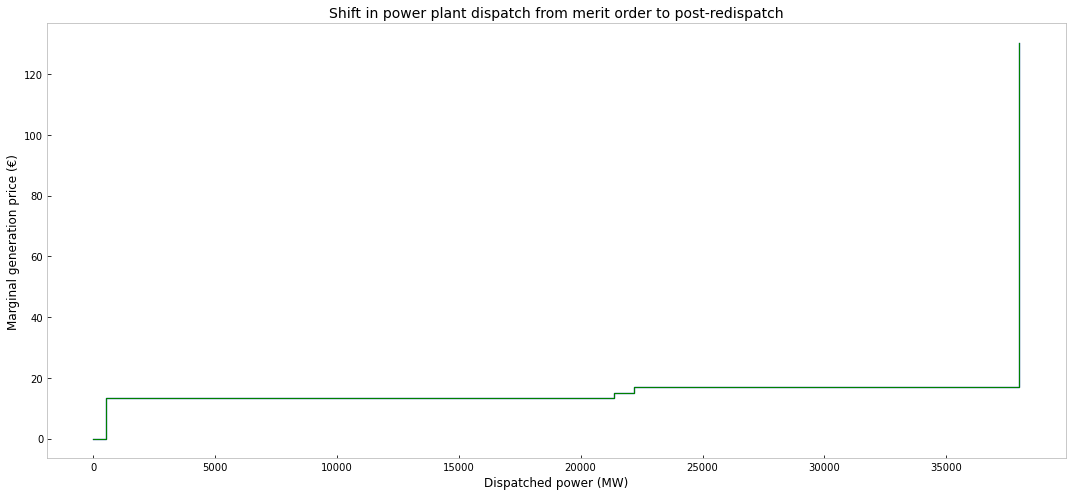

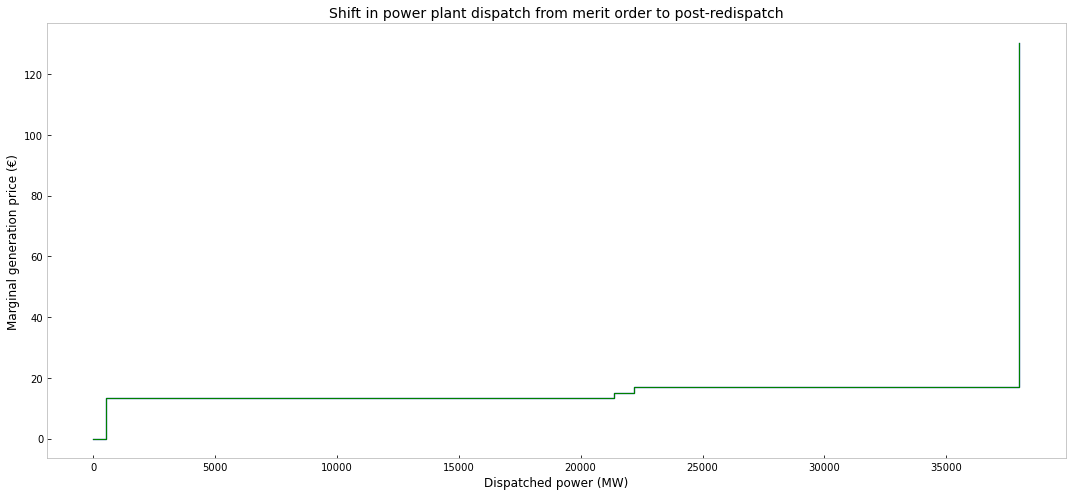

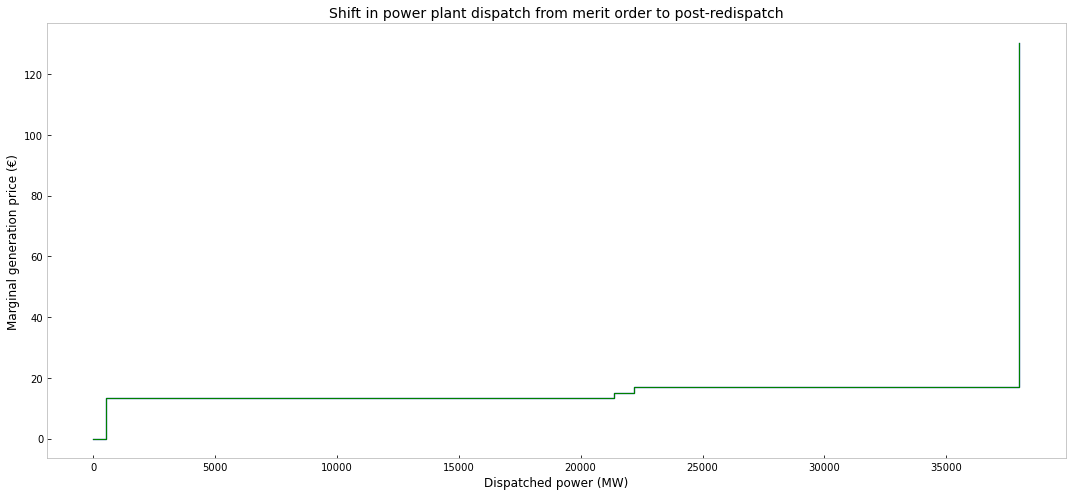

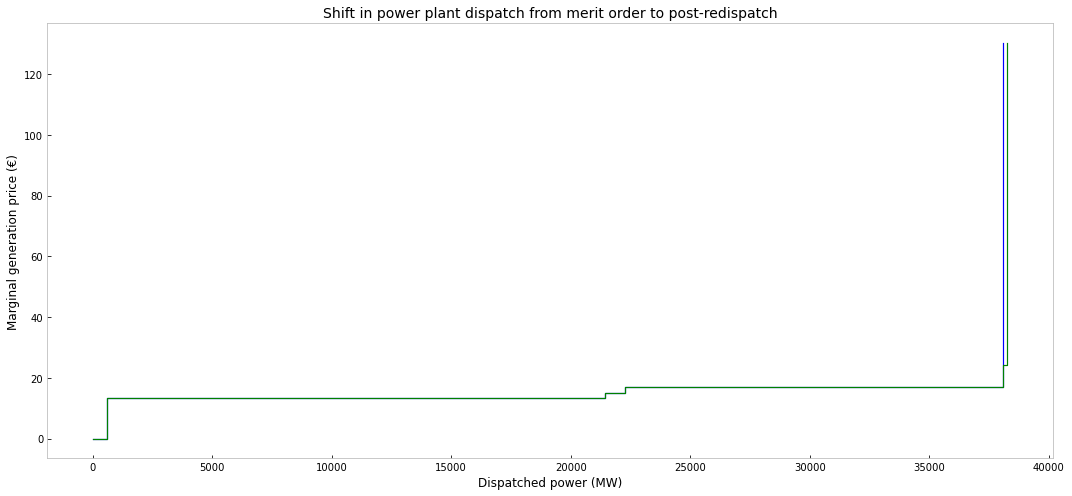

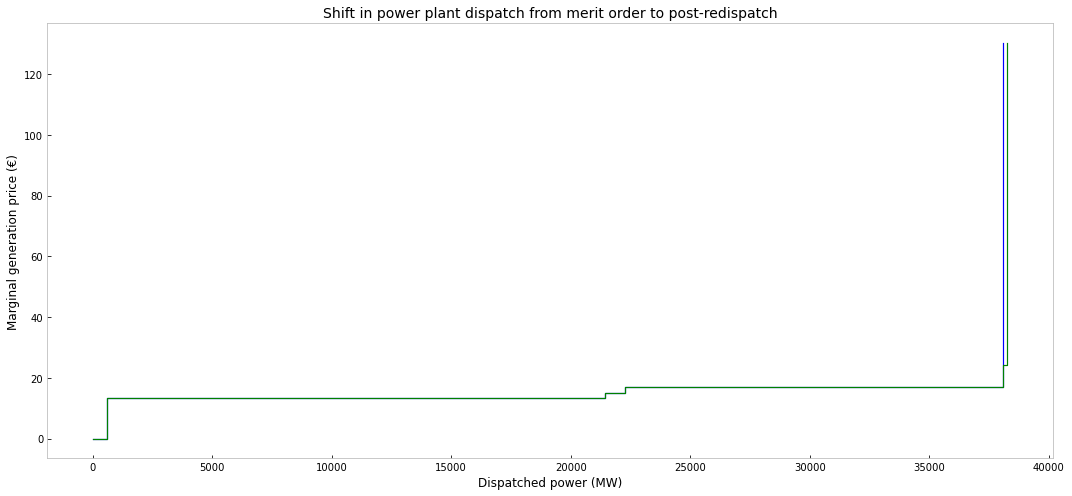

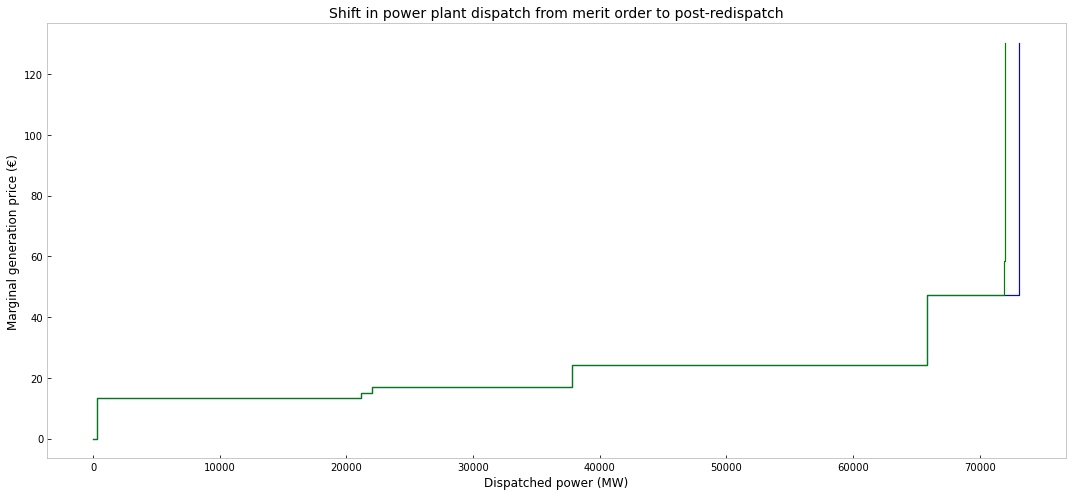

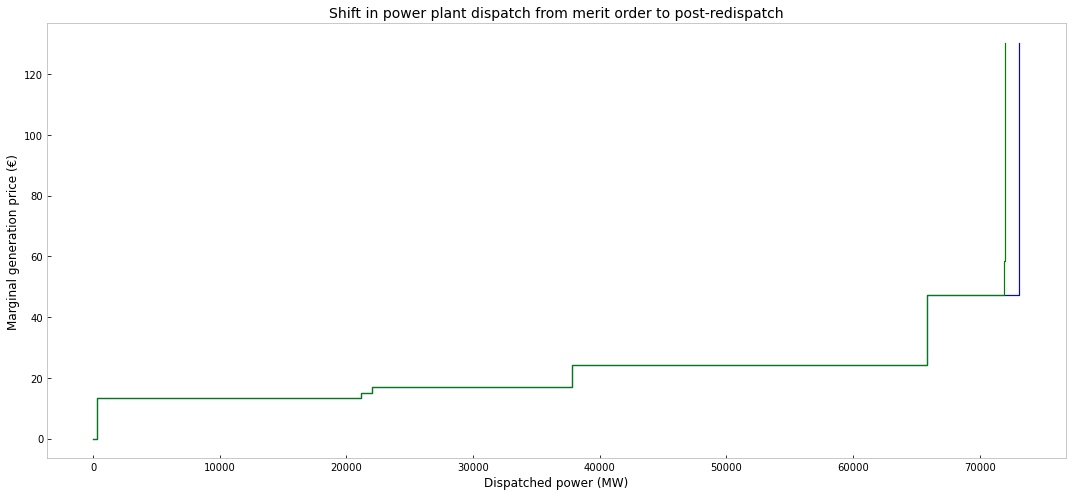

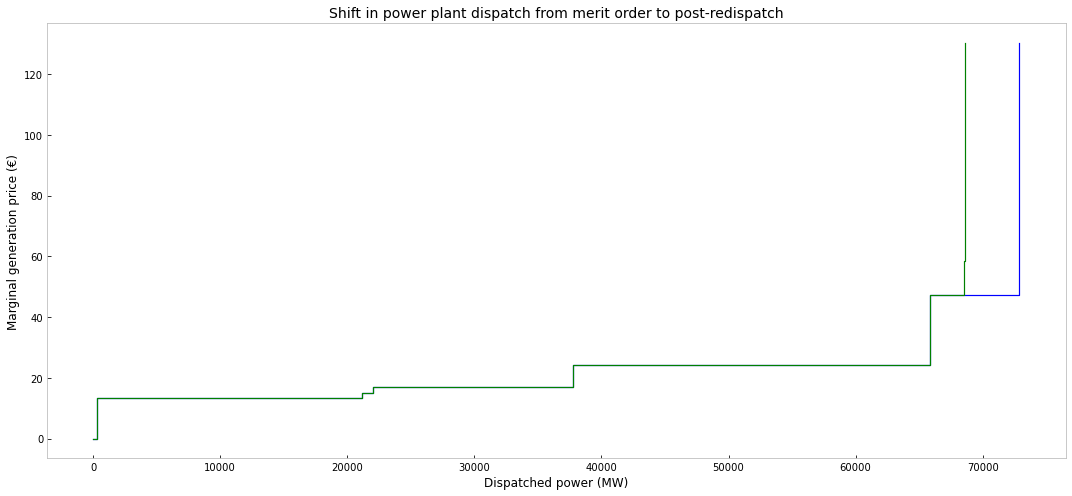

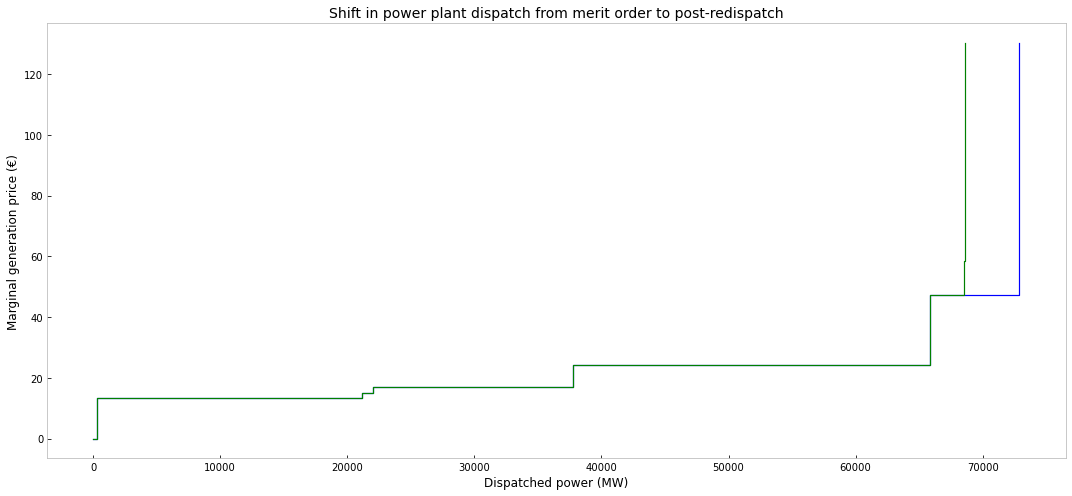

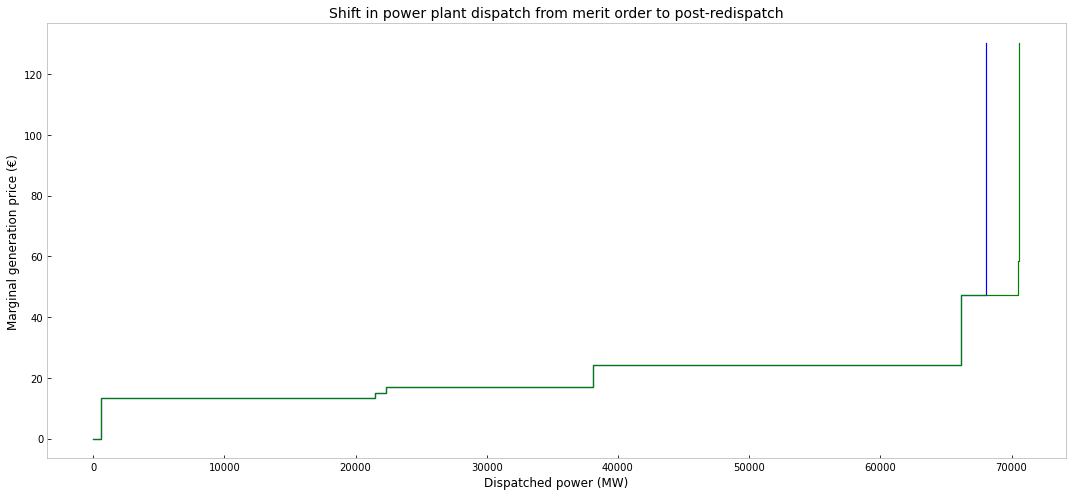

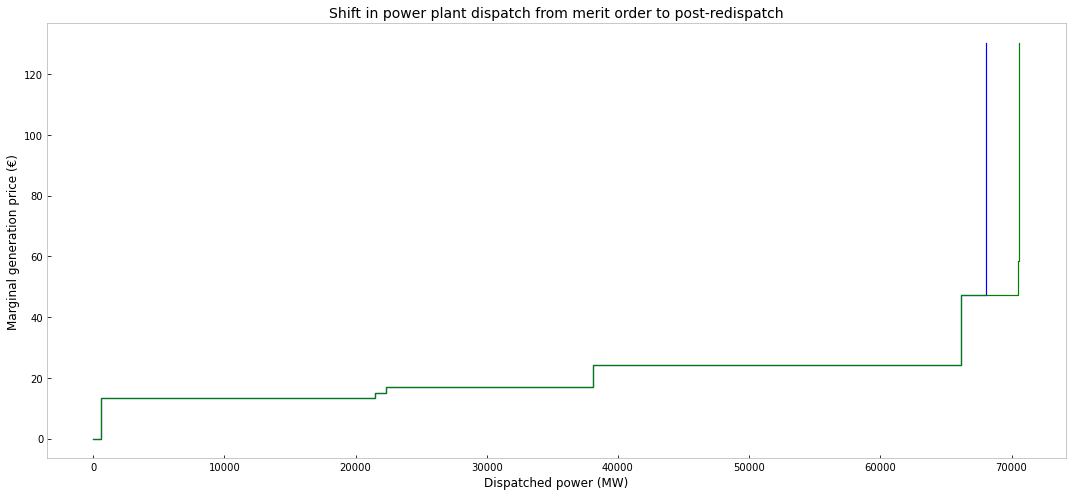

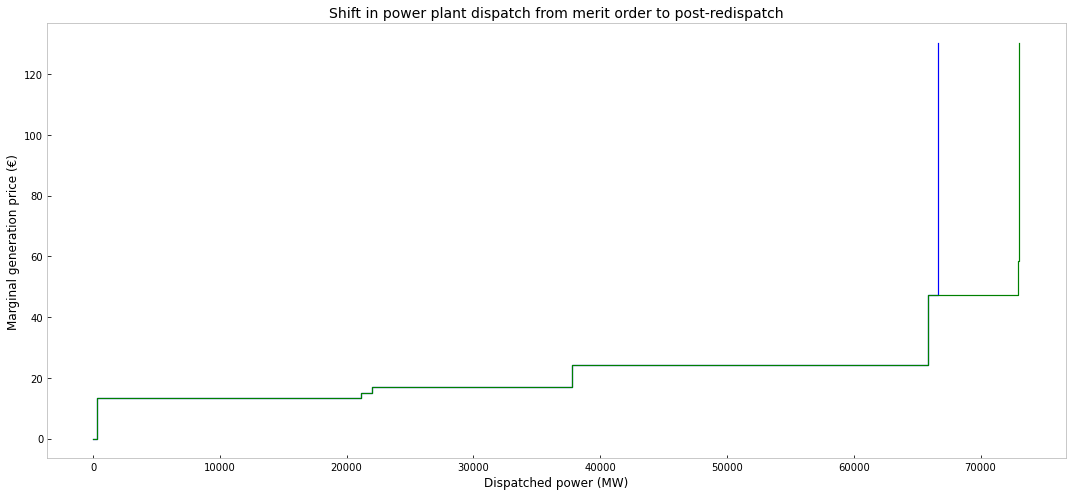

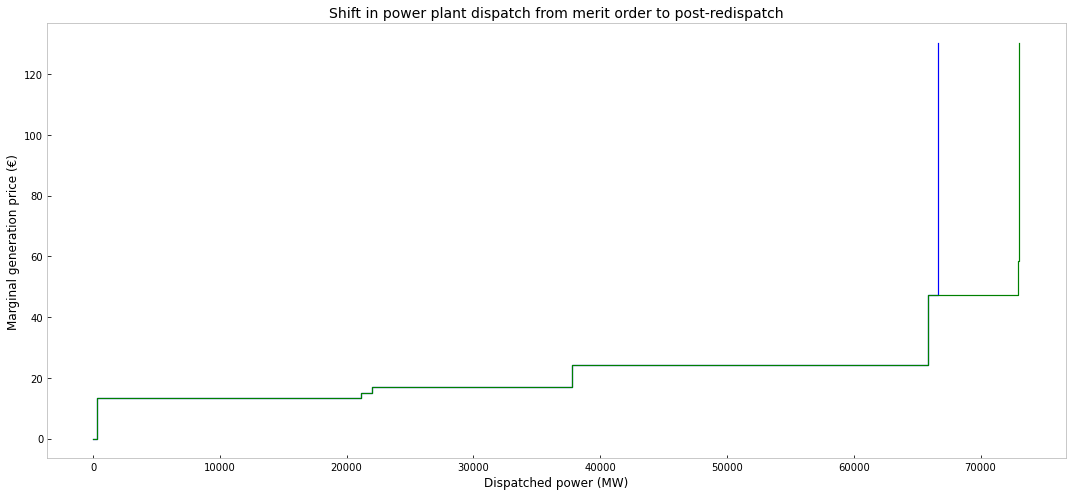

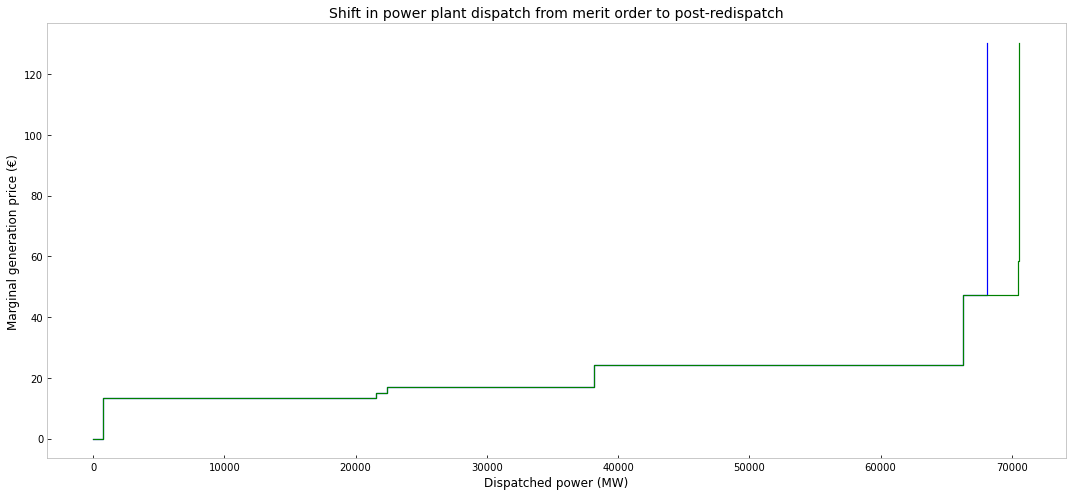

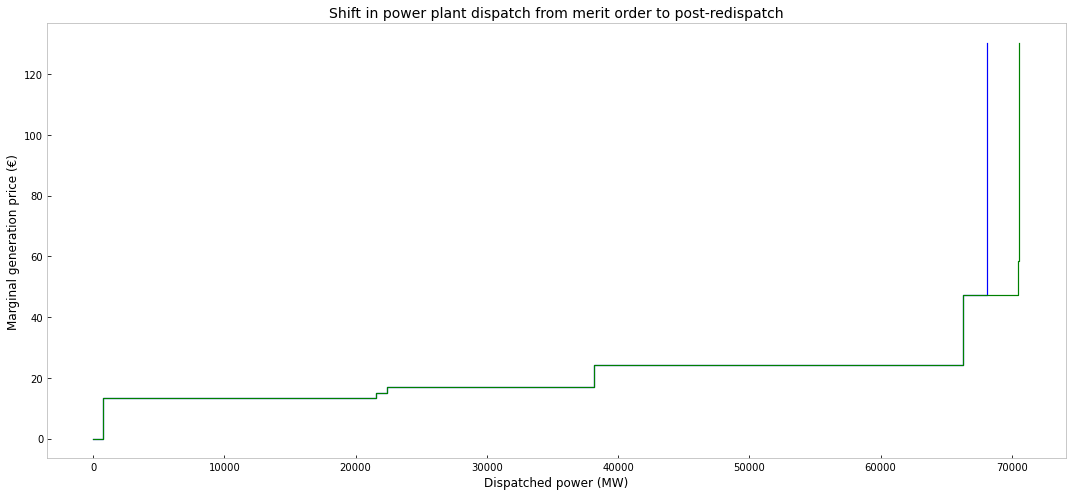

In [24]:
# Plot merit order analysis
# ------------------------

# Merit order curve as step function
s_merit = df_merit.iloc[-1,:]

def plot_merit_order(s_dispatch_p_t, s_merit, s_redispatch_p_t):
    '''
    Plots merit order curve as step function.
    -----
    Param:
    s_dispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_redispatch_p_t: row of aggregated generator dispatch power p dataframe at snapshot t
    s_merit: series with marginal generator prices
    '''
    np_x = np.cumsum(s_dispatch_p_t.iloc[:-1].to_numpy())
    np_x2 = np.cumsum(s_redispatch_p_t.iloc[:-1].to_numpy())
    np_y = s_merit.iloc[:-1].to_numpy()
    
    fig, ax = plt.subplots(figsize=(15, 7))
    # Plot merit order of dispatch & redispatch
    ax.step(np_x, np_y, color = "blue", linewidth = 1.2)
    ax.step(np_x2, np_y, color = "green", linewidth = 1.2)
    
    ax.set_ylabel('Marginal generation price (€)',  fontsize = 12)
    ax.set_xlabel("Dispatched power (MW)", fontsize = 12)
    ax.set_title("Shift in power plant dispatch from merit order to post-redispatch",  fontsize = 14)
    ax.set_facecolor('white')
    ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    fig.tight_layout()
    plt.show()
    

# Plot merit order shift for every of the 5 largest/smallest in cathegories:
# a) biggest redispatch cost saving
# b) biggest grid loads
# c) smallest grid loard

display(df_merit_l)
display(df_merit_rd_l)

# plot hours with largest loads
for i in range(len(l_nlargest)):
    # plot for with and without bat
    plot_merit_order(df_merit_l.iloc[i,:], s_merit, df_merit_rd_l.iloc[i,:])
    plot_merit_order(df_merit_l.iloc[i,:], s_merit, df_merit_rd_bat_l.iloc[i,:])

# plot hours with smallest loads
for i in range(len(l_nsmallest)):
    plot_merit_order(df_merit_s.iloc[i,:], s_merit, df_merit_rd_s.iloc[i,:])
    plot_merit_order(df_merit_s.iloc[i,:], s_merit, df_merit_rd_bat_s.iloc[i,:])
    
# plot hours with biggest rd cost saving
for i in range(len(l_obj_largest)):
    plot_merit_order(df_merit_obj.iloc[i,:], s_merit, df_merit_rd_obj.iloc[i,:])
    plot_merit_order(df_merit_obj.iloc[i,:], s_merit, df_merit_rd_bat_obj.iloc[i,:])

    
    

# Co2 Analysis 

In [21]:
# CO2 ANALYSIS
# ------------

def map_values(row, values_dict):
    return values_dict[row]

# W/o bat
df_gen = network_rd.generators.copy()
dict_co2 = pd.Series(network_rd.carriers["co2_emissions"].values,index=network_rd.carriers.index).to_dict()
df_gen["co2_emissions"] = df_gen["carrier"].apply(map_values, args = (dict_co2,)) 

dict_co2_gen = pd.Series(df_gen["co2_emissions"].values,index=df_gen.index).to_dict()
cols_rd = [column for column in list(network_rd.generators_t.p) if "pos" in column or "neg" in column]
df_rd_p = network_rd.generators_t.p[cols_rd].copy()

# assign co2 emissions to the redispatch energy dataframe
for col in list(df_rd_p):
    if "pos" in col: # if positive redispatch: co2 emission
        df_rd_p[col] = df_rd_p[col] * dict_co2_gen[col]
    else: # co2 reduction
        df_rd_p[col] = df_rd_p[col] * dict_co2_gen[col]
df_rd_p["co2_sum"] = df_rd_p.sum(axis = 1)
df_rd_p.index.rename("Time horizon (hour)", inplace = True)

# With Bat
df_gen_bat = network_rd_bat.generators.copy()
dict_co2 = pd.Series(network_rd_bat.carriers["co2_emissions"].values,index=network_rd_bat.carriers.index).to_dict()
df_gen_bat["co2_emissions"] = df_gen_bat["carrier"].apply(map_values, args = (dict_co2,))
dict_co2_gen = pd.Series(df_gen_bat["co2_emissions"].values,index=df_gen_bat.index).to_dict()
cols_rd = [column for column in list(network_rd_bat.generators_t.p) if "pos" in column or "neg" in column]
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
# assign co2 emissions to the redispatch energy dataframe
for col in list(df_rd_p_bat):
    if "pos" in col: # if positive redispatch: co2 emission
        df_rd_p_bat[col] = df_rd_p_bat[col] * dict_co2_gen[col]
    else: # co2 reduction
        df_rd_p_bat[col] = df_rd_p_bat[col] * dict_co2_gen[col]
df_rd_p_bat["co2_sum_bat"] = df_rd_p_bat.sum(axis = 1)
df_rd_p_bat.index.rename("Time horizon (hour)", inplace = True)

# Df for direct co2 comparison
df_bat_nobat = pd.concat([df_rd_p["co2_sum"], df_rd_p_bat["co2_sum_bat"]], axis = 1)
df_bat_nobat["co2_difference"] = df_bat_nobat["co2_sum_bat"] - df_bat_nobat["co2_sum"]
df_bat_nobat.index.rename("Time horizon (hour)", inplace = True)
display(df_bat_nobat)

# Df for daily co2 comparison
df_co2_day = df_bat_nobat.iloc[:-1].groupby(np.arange(len(df_bat_nobat.iloc[:-1]))//24).sum()
display(df_co2_day)

# Wind curtailment analysis -> reduction in wind curtailment
# -------------
df_rd_p = network_rd.generators_t.p[cols_rd].copy()
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
cols_wind = [column for column in list(df_rd_p) if "wind" in column]
df_rd_wind = df_rd_p[cols_wind]
df_rd_bat_wind = df_rd_p_bat[cols_wind]
df_rd_diff_wind = df_rd_bat_wind - df_rd_wind # < 0 more curtailment > 0 less curtailment
df_rd_diff_wind["sum_diff_curtailment"] = df_rd_diff_wind.sum(axis = 1)
# add row with curtailment sums
df_rd_diff_wind = df_rd_diff_wind.append(df_rd_diff_wind.sum(axis = 0), ignore_index=True)

# DAILY wind curtailment analysis
df_rd_diff_wind_day = df_rd_diff_wind.iloc[:-1].groupby(np.arange(len(df_rd_diff_wind.iloc[:-1]))//24).sum()
df_rd_diff_wind_day.index.rename("Time horizon (day)", inplace = True)
display(df_rd_diff_wind_day)
# WEEKLY wind curtailment analysis
df_rd_diff_wind_week = df_rd_diff_wind_day.groupby(np.arange(len(df_rd_diff_wind_day))//7).sum()[:-1]
df_rd_diff_wind_week.index.rename("Time horizon (week)", inplace = True)
display(df_rd_diff_wind_week)


# Conventional analysis -> reduction in conventional ramp up
# -------------
df_rd_p = network_rd.generators_t.p[cols_rd].copy()
df_rd_p_bat = network_rd_bat.generators_t.p[cols_rd].copy()
cols_pos = [column for column in list(df_rd_p) if "pos" in column]
df_ramp_p = df_rd_p[cols_pos]
df_ramp_p_bat = df_rd_p_bat[cols_pos]
# Only extract columns with conventional carriers 
cols_gas = [column for column in list(df_ramp_p) if "CCGT" in column or "OCGT" in column]
cols_oil = [column for column in list(df_ramp_p) if "oil" in column]
cols_lignite = [column for column in list(df_ramp_p) if "lignite" in column]
cols_nuclear = [column for column in list(df_ramp_p) if "nuclear" in column]
cols_coal = [column for column in list(df_ramp_p) if "coal" in column]
cols_conv = cols_gas + cols_oil + cols_lignite + cols_nuclear + cols_coal + cols_coal
df_ramp_conv = df_ramp_p[cols_conv]
df_ramp_conv_bat = df_ramp_p_bat[cols_conv]
df_ramp_diff_conv = df_ramp_conv_bat - df_ramp_conv # < 0 less ramp up > 0 more ramp up
df_ramp_diff_conv["sum_diff_ramp_up"] = df_ramp_diff_conv.sum(axis = 1)
# column for sums of diff per energy carrier
df_ramp_diff_conv["gas_diff_ramp_up"] = df_ramp_diff_conv[cols_gas].sum(axis = 1)
df_ramp_diff_conv["oil_diff_ramp_up"] = df_ramp_diff_conv[cols_oil].sum(axis = 1)
df_ramp_diff_conv["lignite_diff_ramp_up"] = df_ramp_diff_conv[cols_lignite].sum(axis = 1)
df_ramp_diff_conv["nuclear_diff_ramp_up"] = df_ramp_diff_conv[cols_nuclear].sum(axis = 1)
df_ramp_diff_conv["coal_diff_ramp_up"] = df_ramp_diff_conv[cols_coal].sum(axis = 1)
# add row with ramp up sums 
df_ramp_diff_conv = df_ramp_diff_conv.append(df_ramp_diff_conv.sum(axis = 0), ignore_index=True)

# DAILY conv ramp up analysis
df_ramp_diff_conv_day = df_ramp_diff_conv.iloc[:-1].groupby(np.arange(len(df_ramp_diff_conv.iloc[:-1]))//24).sum()
df_ramp_diff_conv_day.index.rename("Time horizon (day)", inplace = True)
display(df_ramp_diff_conv_day)
# WEEKLY conv ramp up analysis
df_ramp_diff_conv_week = df_ramp_diff_conv_day.groupby(np.arange(len(df_ramp_diff_conv_day))//7).sum()[:-1]
df_ramp_diff_conv_week.index.rename("Time horizon (week)", inplace = True)
display(df_ramp_diff_conv_week)

display(df_ramp_diff_conv)

,co2_sum,co2_sum_bat,co2_difference
Time horizon (hour),,,
2018-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
2018-01-01 01:00:00,0.000000e+00,0.000000e+00,0.000000e+00
2018-01-01 02:00:00,9.349965e-07,7.330569e-08,-8.616908e-07
2018-01-01 03:00:00,0.000000e+00,0.000000e+00,0.000000e+00
2018-01-01 04:00:00,0.000000e+00,7.428584e-08,7.428584e-08
...,...,...,...
2018-12-31 19:00:00,0.000000e+00,0.000000e+00,0.000000e+00
2018-12-31 20:00:00,0.000000e+00,0.000000e+00,0.000000e+00
2018-12-31 21:00:00,0.000000e+00,0.000000e+00,0.000000e+00


,co2_sum,co2_sum_bat,co2_difference
0,1.240172e-06,8.112179e-07,-4.289544e-07
1,1.113253e-06,0.000000e+00,-1.113253e-06
2,1.481236e-06,-2.749891e+02,-2.749891e+02
3,1.256280e-06,-5.418376e+02,-5.418376e+02
4,0.000000e+00,-2.694939e+02,-2.694939e+02
...,...,...,...
360,4.897034e-07,3.735589e-07,-1.161445e-07
361,5.832577e-08,0.000000e+00,-5.832577e-08
362,5.885004e-08,0.000000e+00,-5.885004e-08
363,9.289244e-08,0.000000e+00,-9.289244e-08


name,DE0 0 onwind_neg,DE0 1 onwind_neg,DE0 10 onwind_neg,DE0 11 onwind_neg,DE0 12 onwind_neg,DE0 13 onwind_neg,DE0 14 onwind_neg,DE0 15 offwind-ac_neg,DE0 15 offwind-dc_neg,DE0 15 onwind_neg,DE0 16 onwind_neg,DE0 17 onwind_neg,DE0 18 onwind_neg,DE0 19 onwind_neg,DE0 2 onwind_neg,DE0 20 onwind_neg,DE0 21 onwind_neg,DE0 22 onwind_neg,DE0 23 onwind_neg,DE0 24 onwind_neg,DE0 25 offwind-ac_neg,DE0 25 onwind_neg,DE0 26 onwind_neg,DE0 27 onwind_neg,DE0 28 onwind_neg,DE0 29 onwind_neg,DE0 3 onwind_neg,DE0 30 onwind_neg,DE0 31 onwind_neg,DE0 32 onwind_neg,DE0 33 onwind_neg,DE0 34 onwind_neg,DE0 35 onwind_neg,DE0 36 onwind_neg,DE0 37 onwind_neg,DE0 38 onwind_neg,DE0 39 onwind_neg,DE0 4 onwind_neg,DE0 40 onwind_neg,DE0 41 onwind_neg,DE0 42 onwind_neg,DE0 43 onwind_neg,DE0 44 onwind_neg,DE0 45 offwind-ac_neg,DE0 45 onwind_neg,DE0 46 onwind_neg,DE0 47 offwind-ac_neg,DE0 47 offwind-dc_neg,DE0 47 onwind_neg,DE0 48 onwind_neg,DE0 49 onwind_neg,DE0 5 onwind_neg,DE0 6 onwind_neg,DE0 7 offwind-ac_neg,DE0 7 offwind-dc_neg,DE0 7 onwind_neg,DE0 8 onwind_neg,DE0 9 offwind-ac_neg,DE0 9 offwind-dc_neg,DE0 9 onwind_neg,sum_diff_curtailment
Time horizon (day),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


name,DE0 0 onwind_neg,DE0 1 onwind_neg,DE0 10 onwind_neg,DE0 11 onwind_neg,DE0 12 onwind_neg,DE0 13 onwind_neg,DE0 14 onwind_neg,DE0 15 offwind-ac_neg,DE0 15 offwind-dc_neg,DE0 15 onwind_neg,DE0 16 onwind_neg,DE0 17 onwind_neg,DE0 18 onwind_neg,DE0 19 onwind_neg,DE0 2 onwind_neg,DE0 20 onwind_neg,DE0 21 onwind_neg,DE0 22 onwind_neg,DE0 23 onwind_neg,DE0 24 onwind_neg,DE0 25 offwind-ac_neg,DE0 25 onwind_neg,DE0 26 onwind_neg,DE0 27 onwind_neg,DE0 28 onwind_neg,DE0 29 onwind_neg,DE0 3 onwind_neg,DE0 30 onwind_neg,DE0 31 onwind_neg,DE0 32 onwind_neg,DE0 33 onwind_neg,DE0 34 onwind_neg,DE0 35 onwind_neg,DE0 36 onwind_neg,DE0 37 onwind_neg,DE0 38 onwind_neg,DE0 39 onwind_neg,DE0 4 onwind_neg,DE0 40 onwind_neg,DE0 41 onwind_neg,DE0 42 onwind_neg,DE0 43 onwind_neg,DE0 44 onwind_neg,DE0 45 offwind-ac_neg,DE0 45 onwind_neg,DE0 46 onwind_neg,DE0 47 offwind-ac_neg,DE0 47 offwind-dc_neg,DE0 47 onwind_neg,DE0 48 onwind_neg,DE0 49 onwind_neg,DE0 5 onwind_neg,DE0 6 onwind_neg,DE0 7 offwind-ac_neg,DE0 7 offwind-dc_neg,DE0 7 onwind_neg,DE0 8 onwind_neg,DE0 9 offwind-ac_neg,DE0 9 offwind-dc_neg,DE0 9 onwind_neg,sum_diff_curtailment
Time horizon (week),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


name,DE0 0 CCGT_pos,DE0 0 OCGT_pos,DE0 1 CCGT_pos,DE0 1 OCGT_pos,DE0 11 CCGT_pos,DE0 11 OCGT_pos,DE0 13 CCGT_pos,DE0 13 OCGT_pos,DE0 14 CCGT_pos,DE0 15 CCGT_pos,DE0 15 OCGT_pos,DE0 16 OCGT_pos,DE0 17 CCGT_pos,DE0 17 OCGT_pos,DE0 18 CCGT_pos,DE0 18 OCGT_pos,DE0 19 CCGT_pos,DE0 19 OCGT_pos,DE0 2 OCGT_pos,DE0 20 CCGT_pos,DE0 20 OCGT_pos,DE0 21 CCGT_pos,DE0 21 OCGT_pos,DE0 22 OCGT_pos,DE0 23 CCGT_pos,DE0 23 OCGT_pos,DE0 24 CCGT_pos,DE0 24 OCGT_pos,DE0 25 CCGT_pos,DE0 26 CCGT_pos,DE0 26 OCGT_pos,DE0 28 CCGT_pos,DE0 28 OCGT_pos,DE0 29 CCGT_pos,DE0 29 OCGT_pos,DE0 3 CCGT_pos,DE0 3 OCGT_pos,DE0 30 CCGT_pos,DE0 30 OCGT_pos,DE0 31 CCGT_pos,DE0 31 OCGT_pos,DE0 32 CCGT_pos,DE0 32 OCGT_pos,DE0 33 CCGT_pos,DE0 33 OCGT_pos,DE0 34 CCGT_pos,DE0 34 OCGT_pos,DE0 35 CCGT_pos,DE0 35 OCGT_pos,DE0 36 CCGT_pos,DE0 36 OCGT_pos,DE0 37 OCGT_pos,DE0 38 CCGT_pos,DE0 39 CCGT_pos,DE0 39 OCGT_pos,DE0 40 CCGT_pos,DE0 40 OCGT_pos,DE0 41 CCGT_pos,DE0 41 OCGT_pos,DE0 42 CCGT_pos,DE0 43 OCGT_pos,DE0 44 CCGT_pos,DE0 44 OCGT_pos,DE0 45 OCGT_pos,DE0 47 OCGT_pos,DE0 48 CCGT_pos,DE0 48 OCGT_pos,DE0 49 OCGT_pos,DE0 5 OCGT_pos,DE0 6 CCGT_pos,DE0 6 OCGT_pos,DE0 7 CCGT_pos,DE0 8 CCGT_pos,DE0 8 OCGT_pos,DE0 9 CCGT_pos,DE0 9 OCGT_pos,DE0 11 oil_pos,DE0 13 oil_pos,DE0 15 oil_pos,DE0 17 oil_pos,DE0 18 oil_pos,DE0 20 oil_pos,DE0 21 oil_pos,DE0 25 oil_pos,DE0 27 oil_pos,DE0 3 oil_pos,DE0 33 oil_pos,DE0 35 oil_pos,DE0 36 oil_pos,DE0 42 oil_pos,DE0 44 oil_pos,DE0 46 oil_pos,DE0 47 oil_pos,DE0 9 oil_pos,DE0 11 lignite_pos,DE0 19 lignite_pos,DE0 2 lignite_pos,DE0 3 lignite_pos,DE0 31 lignite_pos,DE0 35 lignite_pos,DE0 4 lignite_pos,DE0 41 lignite_pos,DE0 43 lignite_pos,DE0 44 lignite_pos,DE0 0 nuclear_pos,DE0 15 nuclear_pos,DE0 25 nuclear_pos,DE0 29 nuclear_pos,DE0 34 nuclear_pos,DE0 37 nuclear_pos,DE0 38 nuclear_pos,DE0 46 nuclear_pos,DE0 6 nuclear_pos,DE0 9 nuclear_pos,sum_diff_ramp_up,gas_diff_ramp_up,oil_diff_ramp_up,lignite_diff_ramp_up,nuclear_diff_ramp_up,coal_diff_ramp_up
Time horizon (day),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.568047e-07,0.0,4.704164e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000005,0.0,-6.864066e-07,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,-0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.293874e-06,-2.293874e-06,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-5.953224e-06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.953224e-06,-5.953224e-06,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-7.921051e-06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.921051e-06,-7.921051e-06,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,

name,DE0 0 CCGT_pos,DE0 0 OCGT_pos,DE0 1 CCGT_pos,DE0 1 OCGT_pos,DE0 11 CCGT_pos,DE0 11 OCGT_pos,DE0 13 CCGT_pos,DE0 13 OCGT_pos,DE0 14 CCGT_pos,DE0 15 CCGT_pos,DE0 15 OCGT_pos,DE0 16 OCGT_pos,DE0 17 CCGT_pos,DE0 17 OCGT_pos,DE0 18 CCGT_pos,DE0 18 OCGT_pos,DE0 19 CCGT_pos,DE0 19 OCGT_pos,DE0 2 OCGT_pos,DE0 20 CCGT_pos,DE0 20 OCGT_pos,DE0 21 CCGT_pos,DE0 21 OCGT_pos,DE0 22 OCGT_pos,DE0 23 CCGT_pos,DE0 23 OCGT_pos,DE0 24 CCGT_pos,DE0 24 OCGT_pos,DE0 25 CCGT_pos,DE0 26 CCGT_pos,DE0 26 OCGT_pos,DE0 28 CCGT_pos,DE0 28 OCGT_pos,DE0 29 CCGT_pos,DE0 29 OCGT_pos,DE0 3 CCGT_pos,DE0 3 OCGT_pos,DE0 30 CCGT_pos,DE0 30 OCGT_pos,DE0 31 CCGT_pos,DE0 31 OCGT_pos,DE0 32 CCGT_pos,DE0 32 OCGT_pos,DE0 33 CCGT_pos,DE0 33 OCGT_pos,DE0 34 CCGT_pos,DE0 34 OCGT_pos,DE0 35 CCGT_pos,DE0 35 OCGT_pos,DE0 36 CCGT_pos,DE0 36 OCGT_pos,DE0 37 OCGT_pos,DE0 38 CCGT_pos,DE0 39 CCGT_pos,DE0 39 OCGT_pos,DE0 40 CCGT_pos,DE0 40 OCGT_pos,DE0 41 CCGT_pos,DE0 41 OCGT_pos,DE0 42 CCGT_pos,DE0 43 OCGT_pos,DE0 44 CCGT_pos,DE0 44 OCGT_pos,DE0 45 OCGT_pos,DE0 47 OCGT_pos,DE0 48 CCGT_pos,DE0 48 OCGT_pos,DE0 49 OCGT_pos,DE0 5 OCGT_pos,DE0 6 CCGT_pos,DE0 6 OCGT_pos,DE0 7 CCGT_pos,DE0 8 CCGT_pos,DE0 8 OCGT_pos,DE0 9 CCGT_pos,DE0 9 OCGT_pos,DE0 11 oil_pos,DE0 13 oil_pos,DE0 15 oil_pos,DE0 17 oil_pos,DE0 18 oil_pos,DE0 20 oil_pos,DE0 21 oil_pos,DE0 25 oil_pos,DE0 27 oil_pos,DE0 3 oil_pos,DE0 33 oil_pos,DE0 35 oil_pos,DE0 36 oil_pos,DE0 42 oil_pos,DE0 44 oil_pos,DE0 46 oil_pos,DE0 47 oil_pos,DE0 9 oil_pos,DE0 11 lignite_pos,DE0 19 lignite_pos,DE0 2 lignite_pos,DE0 3 lignite_pos,DE0 31 lignite_pos,DE0 35 lignite_pos,DE0 4 lignite_pos,DE0 41 lignite_pos,DE0 43 lignite_pos,DE0 44 lignite_pos,DE0 0 nuclear_pos,DE0 15 nuclear_pos,DE0 25 nuclear_pos,DE0 29 nuclear_pos,DE0 34 nuclear_pos,DE0 37 nuclear_pos,DE0 38 nuclear_pos,DE0 46 nuclear_pos,DE0 6 nuclear_pos,DE0 9 nuclear_pos,sum_diff_ramp_up,gas_diff_ramp_up,oil_diff_ramp_up,lignite_diff_ramp_up,nuclear_diff_ramp_up,coal_diff_ramp_up
Time horizon (week),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.000001,0.0,0.000000e+00,0.0,0.0,0.0,-1.000001e-06,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000002,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,9.999983e-07,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,-2.500071e-07,0.0,0.0,0.0,1.568047e-07,0.0,4.704164e-07,0.0,0.000000,0.0,0.0,0.0,0.000003,0.0,1.048849e-06,0.0,0.000000,0.0,-0.000005,0.0,-0.000001,0.0,0.0,0.0,1.000001e-06,0.0,0.0,0.0,0.000001,0.0,-0.000023,9.999911e-07,0.0,-4.631955e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000025,-0.000025,0.0,0.0,0.0,0.0
1,-0.000001,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,-3.149125e-11,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,-3.640650e-06,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,-0.000008,0.000000e+00,0.0,-2.500285e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000013,-0.000013,0.0,0.0,0.0,0.0
2,0.000000,0.0,-1.351087e-05,0.0,0.0,0.0,2.000002e-06,0.0,-0.000001,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.364242e-11,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,-0.000001,0.0,9.999958e-07,0.0,0.0,0.0,1.000003e-06,0.0,-2.059183e-06,0.0,0.000001,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,-0.000004,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,-0.000009,0.0,-0.000007,0.000000e+00,0.0,-3.500224e-06,0.0,0.0,0.0,0.0,0

name,DE0 0 CCGT_pos,DE0 0 OCGT_pos,DE0 1 CCGT_pos,DE0 1 OCGT_pos,DE0 11 CCGT_pos,DE0 11 OCGT_pos,DE0 13 CCGT_pos,DE0 13 OCGT_pos,DE0 14 CCGT_pos,DE0 15 CCGT_pos,DE0 15 OCGT_pos,DE0 16 OCGT_pos,DE0 17 CCGT_pos,DE0 17 OCGT_pos,DE0 18 CCGT_pos,DE0 18 OCGT_pos,DE0 19 CCGT_pos,DE0 19 OCGT_pos,DE0 2 OCGT_pos,DE0 20 CCGT_pos,DE0 20 OCGT_pos,DE0 21 CCGT_pos,DE0 21 OCGT_pos,DE0 22 OCGT_pos,DE0 23 CCGT_pos,DE0 23 OCGT_pos,DE0 24 CCGT_pos,DE0 24 OCGT_pos,DE0 25 CCGT_pos,DE0 26 CCGT_pos,DE0 26 OCGT_pos,DE0 28 CCGT_pos,DE0 28 OCGT_pos,DE0 29 CCGT_pos,DE0 29 OCGT_pos,DE0 3 CCGT_pos,DE0 3 OCGT_pos,DE0 30 CCGT_pos,DE0 30 OCGT_pos,DE0 31 CCGT_pos,DE0 31 OCGT_pos,DE0 32 CCGT_pos,DE0 32 OCGT_pos,DE0 33 CCGT_pos,DE0 33 OCGT_pos,DE0 34 CCGT_pos,DE0 34 OCGT_pos,DE0 35 CCGT_pos,DE0 35 OCGT_pos,DE0 36 CCGT_pos,DE0 36 OCGT_pos,DE0 37 OCGT_pos,DE0 38 CCGT_pos,DE0 39 CCGT_pos,DE0 39 OCGT_pos,DE0 40 CCGT_pos,DE0 40 OCGT_pos,DE0 41 CCGT_pos,DE0 41 OCGT_pos,DE0 42 CCGT_pos,DE0 43 OCGT_pos,DE0 44 CCGT_pos,DE0 44 OCGT_pos,DE0 45 OCGT_pos,DE0 47 OCGT_pos,DE0 48 CCGT_pos,DE0 48 OCGT_pos,DE0 49 OCGT_pos,DE0 5 OCGT_pos,DE0 6 CCGT_pos,DE0 6 OCGT_pos,DE0 7 CCGT_pos,DE0 8 CCGT_pos,DE0 8 OCGT_pos,DE0 9 CCGT_pos,DE0 9 OCGT_pos,DE0 11 oil_pos,DE0 13 oil_pos,DE0 15 oil_pos,DE0 17 oil_pos,DE0 18 oil_pos,DE0 20 oil_pos,DE0 21 oil_pos,DE0 25 oil_pos,DE0 27 oil_pos,DE0 3 oil_pos,DE0 33 oil_pos,DE0 35 oil_pos,DE0 36 oil_pos,DE0 42 oil_pos,DE0 44 oil_pos,DE0 46 oil_pos,DE0 47 oil_pos,DE0 9 oil_pos,DE0 11 lignite_pos,DE0 19 lignite_pos,DE0 2 lignite_pos,DE0 3 lignite_pos,DE0 31 lignite_pos,DE0 35 lignite_pos,DE0 4 lignite_pos,DE0 41 lignite_pos,DE0 43 lignite_pos,DE0 44 lignite_pos,DE0 0 nuclear_pos,DE0 15 nuclear_pos,DE0 25 nuclear_pos,DE0 29 nuclear_pos,DE0 34 nuclear_pos,DE0 37 nuclear_pos,DE0 38 nuclear_pos,DE0 46 nuclear_pos,DE0 6 nuclear_pos,DE0 9 nuclear_pos,sum_diff_ramp_up,gas_diff_ramp_up,oil_diff_ramp_up,lignite_diff_ramp_up,nuclear_diff_ramp_up,coal_diff_ramp_up
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.920090e-07,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,-0.000005,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

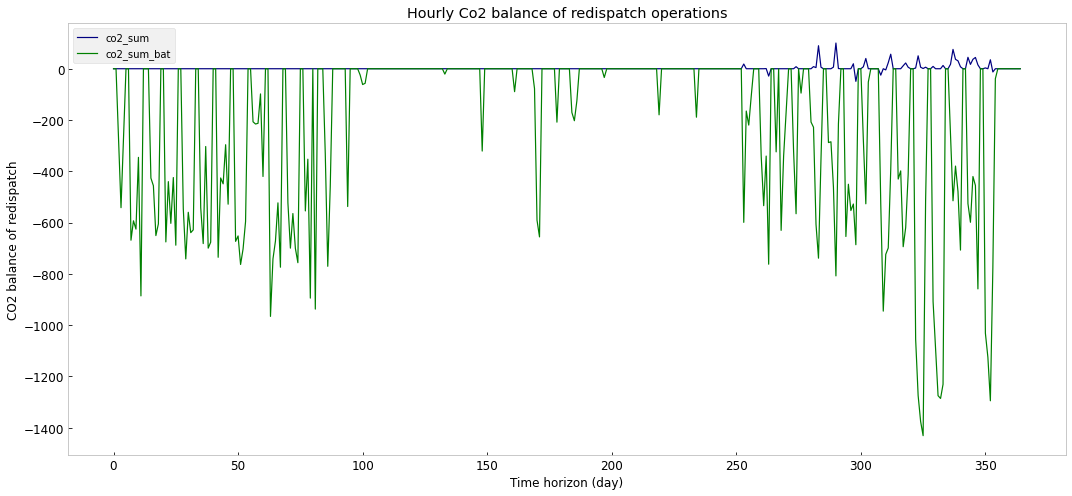

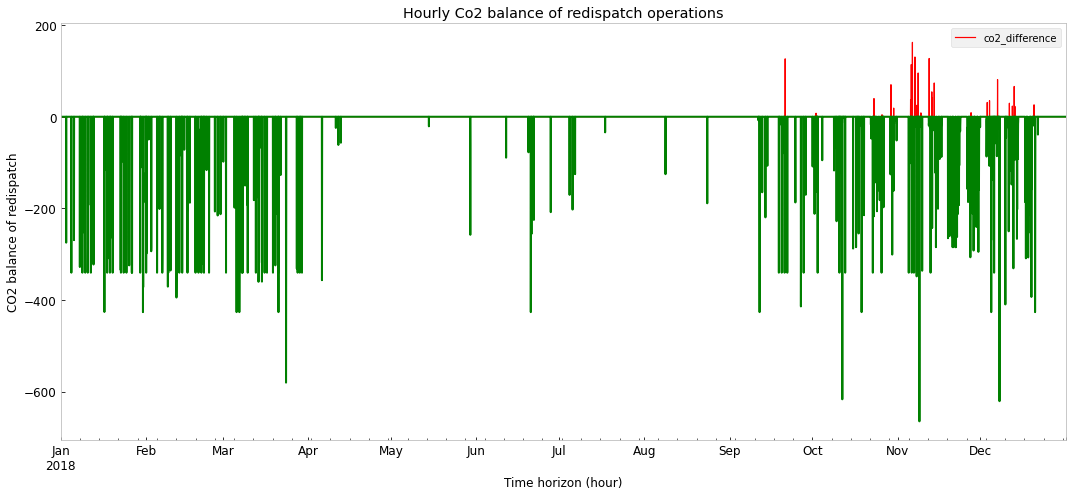

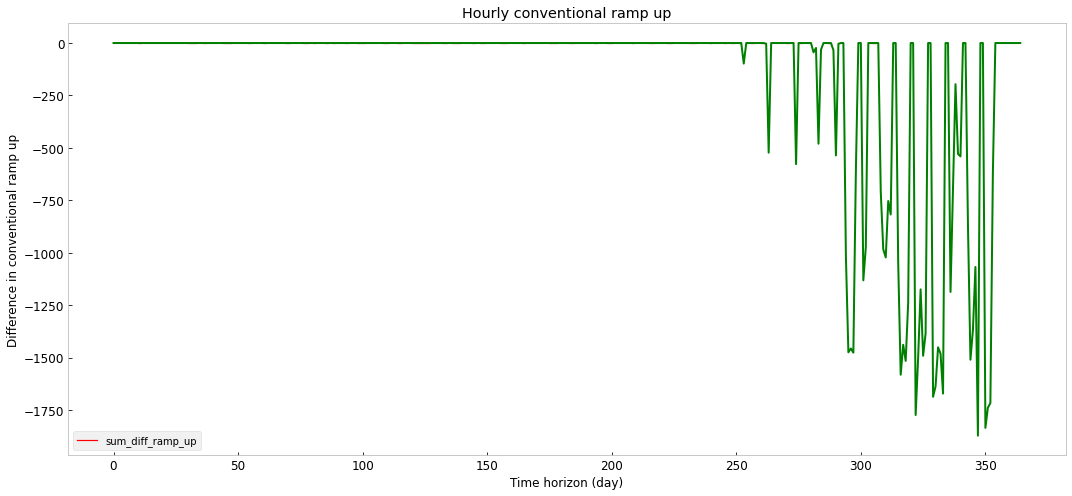

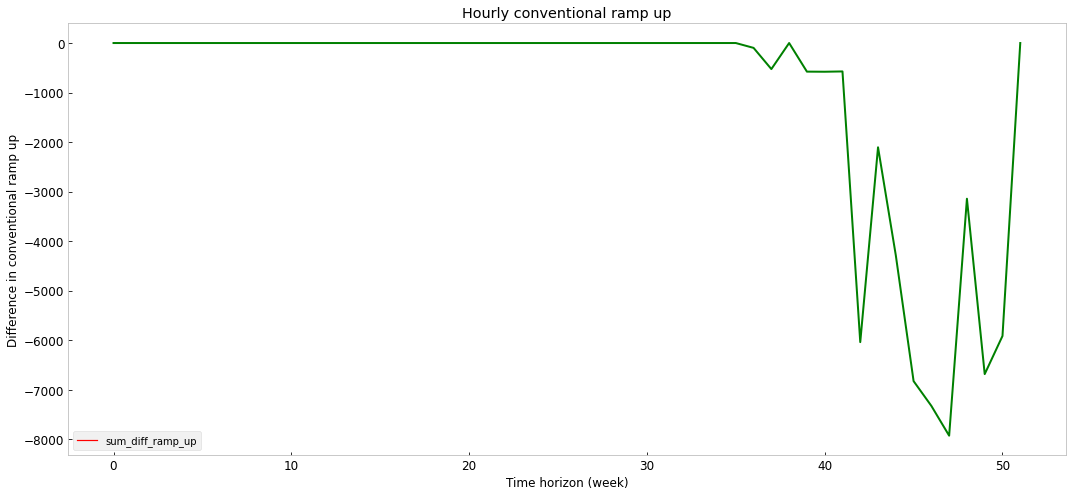

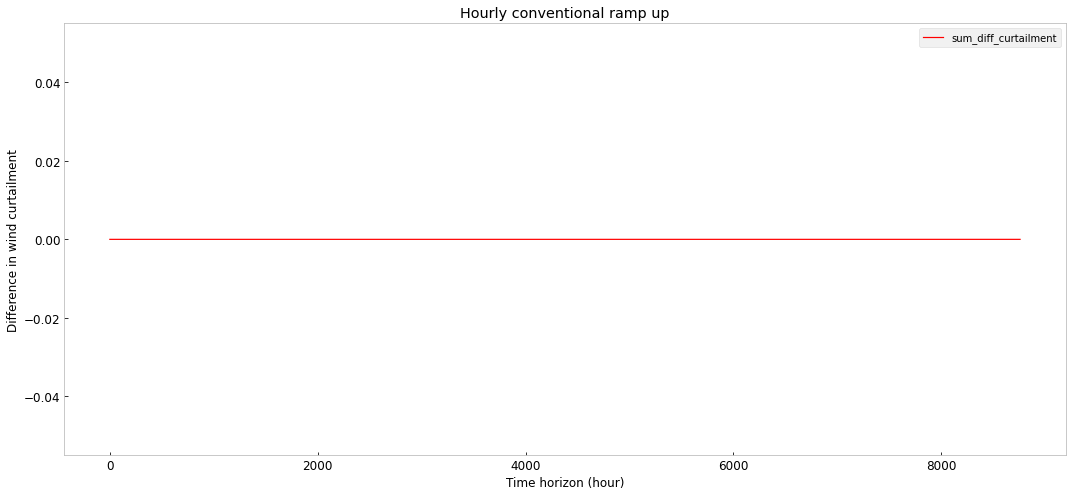

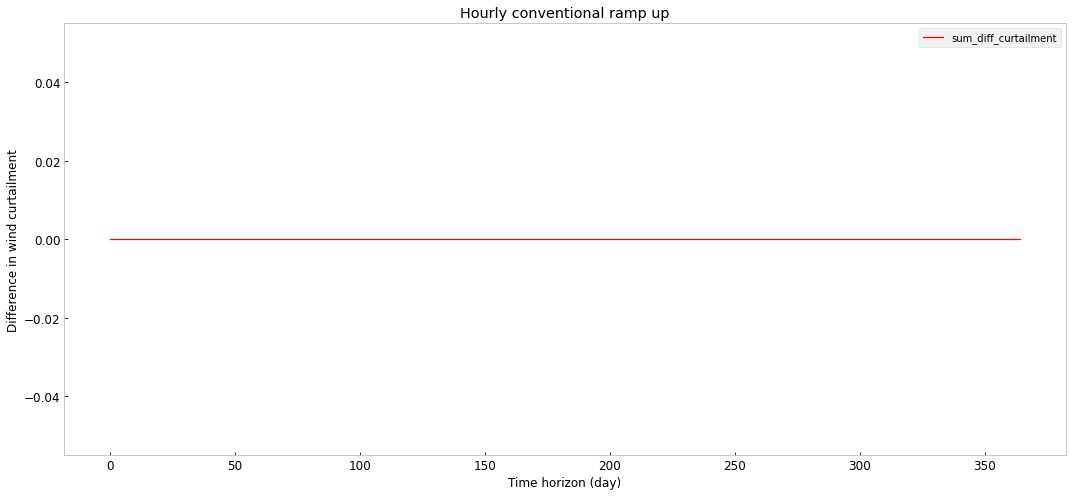

In [276]:
# Plot Co2 insights
# --------------
colors = ["navy","green","lightgreen"]

# CO2 balance with bat vs. w/o bat DAILY
cols = ["co2_sum","co2_sum_bat"]
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
ax.set_xlabel("Time horizon (day)", fontsize = 12)
ax = df_co2_day[cols].plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                   color = colors, legend = True, linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Differences in CO2 balances bat vs. no bat 
cols = ["co2_difference"]
fig, ax  = plt.subplots(figsize =(15, 7))
ax.set_ylabel('CO2 balance of redispatch',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_bat_nobat["co2_difference"].where(df_bat_nobat["co2_difference"].ge(0), 0).plot.line(stacked = False, ax = ax, title = "Hourly Co2 balance of redispatch operations", 
                                   color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_bat_nobat["co2_difference"].where(df_bat_nobat["co2_difference"].lt(0), 0).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Conventional ramp up

# # Differences in conventional ramp up (without sum row) HOURLY
# cols = ["sum_diff_ramp_up"]
# fig, ax  = plt.subplots(figsize = (15, 7))
# ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
# ax.set_xlabel("Time horizon (hour)", fontsize = 12)
# ax = df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].where(df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].ge(0), 0)\
# .plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
#            color = "red", legend = True, linewidth = 1.2, fontsize = 12)
# df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].where(df_ramp_diff_conv["sum_diff_ramp_up"].iloc[:-1].lt(0), 0).plot.line(ax = ax, color = "green")
# ax.set_facecolor('white')
# ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
# ax.set_axisbelow(True)
# fig.tight_layout()
# plt.show()

# Differences in conventional ramp up (without sum row) DAILY
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].ge(0), np.NaN)\
.plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_ramp_diff_conv_day["sum_diff_ramp_up"].where(df_ramp_diff_conv_day["sum_diff_ramp_up"].lt(0), 0).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Differences in conventional ramp up (without sum row) WEEKLY
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Difference in conventional ramp up',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].ge(0), np.NaN)\
.plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_ramp_diff_conv_week["sum_diff_ramp_up"].where(df_ramp_diff_conv_week["sum_diff_ramp_up"].lt(0), 0).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Wind curtailment

# Difference in wind curtailment
cols = ["sum_diff_curtailment"]
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Difference in wind curtailment',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].where(df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].ge(0), np.NaN)\
.plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
           color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].where(df_rd_diff_wind["sum_diff_curtailment"].iloc[:-1].lt(0), np.NaN).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Difference in wind curtailment DAILY
cols = ["sum_diff_curtailment"]
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Difference in wind curtailment',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind["sum_diff_curtailment"].ge(0), np.NaN)\
            .plot.line(stacked = False, ax = ax, title = "Hourly conventional ramp up", 
                       color = "red", legend = True, linewidth = 1.2, fontsize = 12)
df_rd_diff_wind_day["sum_diff_curtailment"].where(df_rd_diff_wind["sum_diff_curtailment"].lt(0), np.NaN).plot.line(ax = ax, color = "green")
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# <b> Line congestion analysis <b>

In [72]:
# Line Congestion Analysis
# ------------------------

df_line_p = network_rd.lines_t.p0.copy()
df_line_loading = (network_rd.lines_t.p0.abs()/(network_rd.lines.s_nom_opt*network_rd.lines.s_max_pu).sort_index().fillna(0.)).copy()
df_shadows = network_rd.lines_t.mu_upper.copy()
#display(df_line_loading)

# Loading analysis: Only keep lines with loading == 1
df_line_loading = df_line_loading.append(df_line_loading.max(axis = 0), ignore_index = True)
cols_overload = []
for col in list(df_line_loading):
    if df_line_loading[col].iloc[-1] >= 0.999999:
        cols_overload.append(col)
df_line_overload = df_line_loading[cols_overload].iloc[:-1,:]

# dataframe for maximum daily load of overloaded lines (hoy many days is a line overloaded)
df_line_overload_day = df_line_overload.groupby(np.arange(len(df_line_overload))//24).max()
display(df_line_overload_day)

# Get shadow prices of overloaded lines
df_shadows_overload = df_shadows[cols_overload]
display(df_shadows_overload)

name,48,56,71
0,0.446648,0.602722,0.359293
1,0.750823,0.735222,0.624794
2,0.775977,0.792919,0.649430
3,0.733160,0.821081,0.646904
4,0.741130,0.752636,0.634496
...,...,...,...
360,0.671960,0.721335,0.650147
361,0.688759,0.783034,0.659496
362,0.682437,0.752806,0.699235
363,0.556398,0.691644,0.656511


name,48,56,71
name,,,
2018-01-01 00:00:00,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,0.0,0.0
2018-01-01 02:00:00,0.0,0.0,0.0
2018-01-01 03:00:00,0.0,0.0,0.0
2018-01-01 04:00:00,0.0,0.0,0.0
...,...,...,...
2018-12-31 19:00:00,0.0,0.0,0.0
2018-12-31 20:00:00,0.0,0.0,0.0
2018-12-31 21:00:00,0.0,0.0,0.0


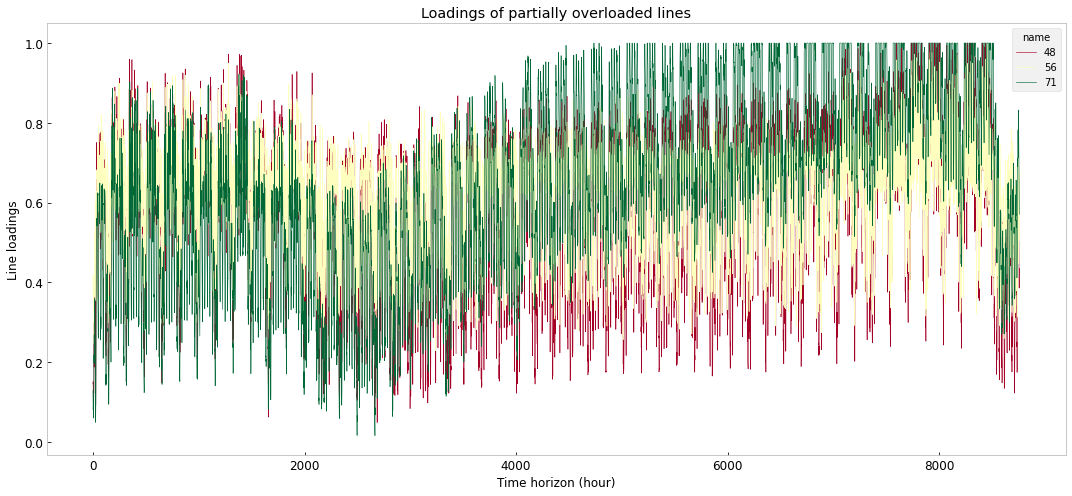

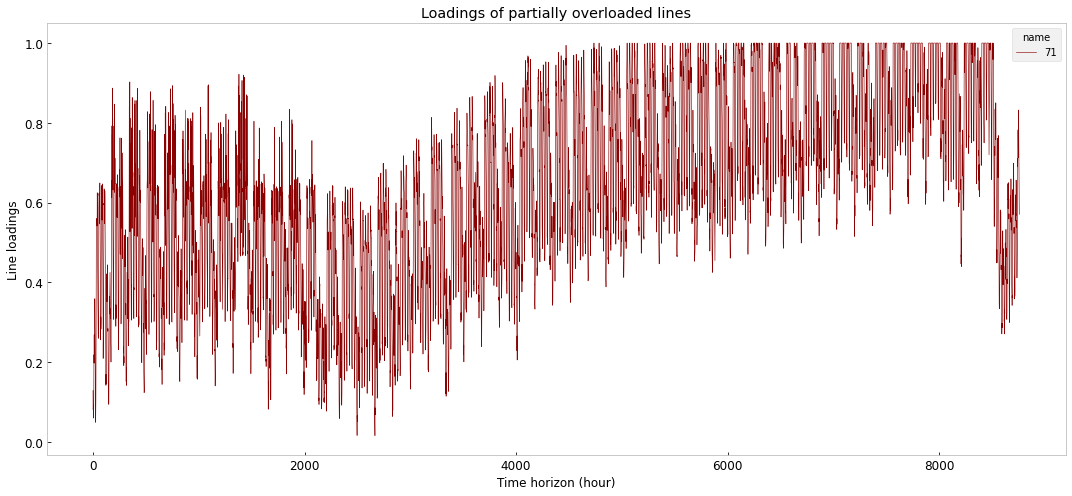

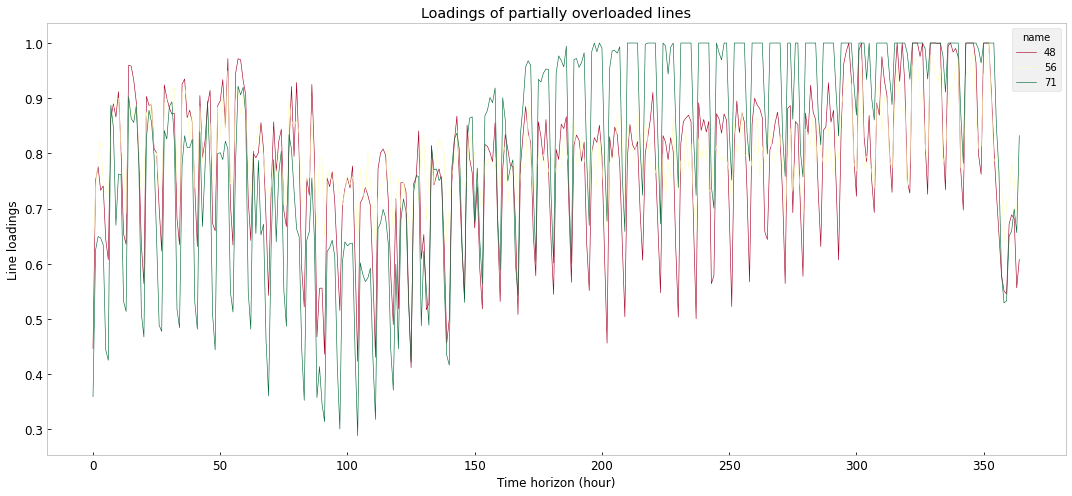

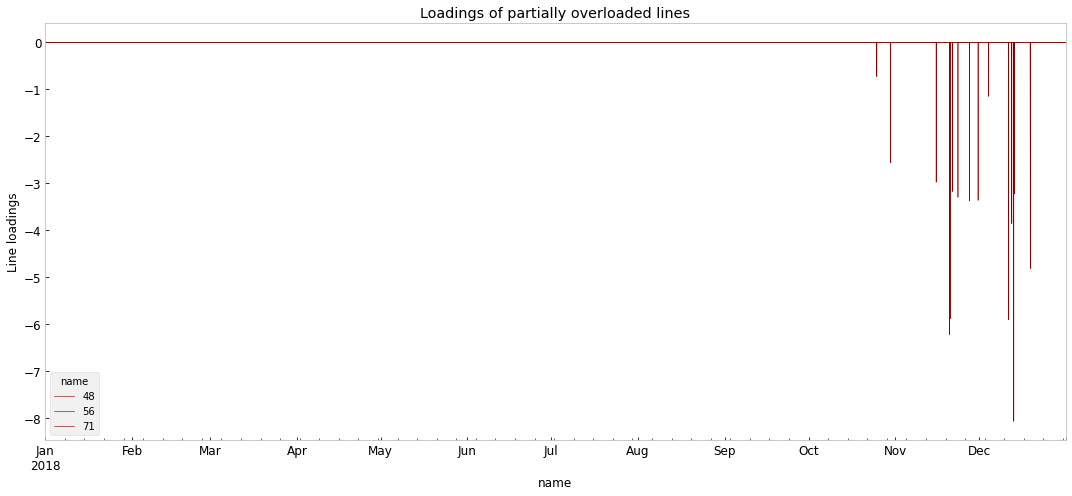

In [75]:
# Plot line congestion analysis
# -----------------------------

# # Plot line loadings
# cols = list(df_line_loading)
# fig, ax  = plt.subplots(figsize = (15, 7))
# ax.set_ylabel('Line loadings',  fontsize = 12)
# ax.set_xlabel("Time horizon (hour)", fontsize = 12)
# ax = df_line_loading[cols].plot.line(stacked = False, ax = ax, cmap = "RdYlGn", legend = True, linewidth = 1.2, fontsize = 12)
# ax.set_facecolor('white')
# ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
# ax.set_axisbelow(True)
# fig.tight_layout()
# plt.show()

# Plot line loadings of overloaded lines
cols = list(df_line_overload)
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Line loadings',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_line_overload[cols].plot.line(stacked = False, ax = ax, cmap = "RdYlGn", legend = True, 
                                      title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Plot line loadings of most overloaded line
cols = list(df_line_overload)
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Line loadings',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_line_overload[["71"]].plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
                                      title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Plot MAX line loadings of overloaded lines DAILY
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Line loadings',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_line_overload_day.plot.line(stacked = False, ax = ax, cmap = "RdYlGn", legend = True, 
                                      title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


# Plot shadow prices of overloaded lines
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Line loadings',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_shadows_overload.plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
                                      title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Plot shadow prices of All lines
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Line loadings',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_shadows_overload.plot.line(stacked = False, ax = ax, color = ["darkred"], legend = True, 
                                      title = "Loadings of partially overloaded lines", linewidth = 0.6, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


# Load & load shedding analysis

In [275]:
# Load analysis
# -------------

df_loads_p = network_rd.loads_t.p.copy()
df_loads_p_bat = network_rd_bat.loads_t.p.copy()

df_loads_p["sum"] = df_loads_p.sum(axis = 1)
df_loads_p["avg"] = df_loads_p.iloc[:,:-1].mean(axis = 1)
df_loads_p_bat["sum"] = df_loads_p_bat.sum(axis = 1)
df_loads_p_bat["avg"] = df_loads_p_bat.iloc[:,:-1].mean(axis = 1)

# Df for daily loads
df_loads_p_day = df_loads_p.groupby(np.arange(len(df_loads_p))//24).mean()
df_loads_p_day.index.rename("Time horizon (day)", inplace = True)
df_loads_p_bat_day = df_loads_p_bat.groupby(np.arange(len(df_loads_p_bat))//24).mean()
df_loads_p_bat_day.index.rename("Time horizon (day)", inplace = True)

# Load shedding analysis (validity check for model)
# load shedding measured in kw!!!!
# ----------------------

# Load shedding validity check w/o bat
df_gen_shed = network_rd.generators_t.p.copy()
cols_shed = [column for column in list(df_gen_shed) if "load" in column] 
df_gen_shed["load_shedding"] = df_gen_shed[cols_shed].sum(axis = 1)/1000
df_gen_shed["sum"] = df_gen_shed.iloc[:,:-1].sum(axis = 1)
df_gen_shed["load_shedding_share"] = df_gen_shed["load_shedding"] / df_gen_shed["sum"]
df_gen_shed.index.rename("Time horizon (hour)", inplace = True)
# With bat
df_gen_shed_bat = network_rd_bat.generators_t.p.copy()
cols_shed = [column for column in list(df_gen_shed_bat) if "load" in column] 
df_gen_shed_bat["load_shedding_bat"] = df_gen_shed_bat[cols_shed].sum(axis = 1)/1000
df_gen_shed_bat["sum"] = df_gen_shed_bat.iloc[:,:-1].sum(axis = 1)
df_gen_shed_bat["load_shedding_share_bat"] = df_gen_shed_bat["load_shedding_bat"] / df_gen_shed_bat["sum"]
df_gen_shed_bat.index.rename("Time horizon (hour)", inplace = True)


# DAILY load shedding average w/o bat
df_gen_shed_day = df_gen_shed.iloc[:,:-2].groupby(np.arange(len(df_gen_shed.iloc[:,:-2]))//24).sum()
df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
df_gen_shed_day = df_gen_shed_day.append(df_gen_shed_day.sum(axis = 0), ignore_index = True)
# Sum all columns with load shedding data (given in kW!) and transform it to MW
cols_shed = [column for column in list(df_gen_shed_day) if "load" in column] 
df_gen_shed_day["load_shedding"] = df_gen_shed_day[cols_shed].sum(axis = 1)/1000
df_gen_shed_day["sum"] = df_gen_shed_day.iloc[:,:-1].sum(axis = 1)
df_gen_shed_day["load_shedding_share"] = df_gen_shed_day["load_shedding"] / df_gen_shed_day["sum"]
df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
# Maximum load shedding:
print("Maximal relative load shedding per day: " + str(round(df_gen_shed_day["load_shedding_share"].iloc[:-1].max(), 8)))

df_gen_shed_bat_day = df_gen_shed_bat.iloc[:,:-2].groupby(np.arange(len(df_gen_shed_bat.iloc[:,:-2]))//24).sum()
df_gen_shed_bat_day.index.rename("Time horizon (day)", inplace = True)
df_gen_shed_bat_day = df_gen_shed_bat_day.append(df_gen_shed_bat_day.sum(axis = 0), ignore_index = True)

# Sum all columns with load shedding data (given in kW!) and transform it to MW
cols_shed = [column for column in list(df_gen_shed_bat_day) if "load" in column] 
df_gen_shed_bat_day["load_shedding_bat"] = df_gen_shed_bat_day[cols_shed].sum(axis = 1)/1000
df_gen_shed_bat_day["sum"] = df_gen_shed_bat_day.iloc[:,:-1].sum(axis = 1)
df_gen_shed_bat_day["load_shedding_share_bat"] = df_gen_shed_bat_day["load_shedding_bat"] / df_gen_shed_bat_day["sum"]
df_gen_shed_bat_day.index.rename("Time horizon (day)", inplace = True)
# Maximum load shedding:
print("Maximal relative load shedding per day with bat: " + str(round(df_gen_shed_bat_day["load_shedding_share_bat"].iloc[:-1].max(), 8)))

# Dataframe for load shedding comparison
df_gen_shed_diff = pd.concat([df_gen_shed[["load_shedding","load_shedding_share"]], 
                              df_gen_shed_bat[["load_shedding_bat","load_shedding_share_bat"]]], axis = 1)
df_gen_shed_diff["difference"] = df_gen_shed_diff["load_shedding_bat"] - df_gen_shed_diff["load_shedding"]

# Dataframe for load shedding comparison DAILY
df_gen_shed_diff_day = pd.concat([df_gen_shed_day[["load_shedding","load_shedding_share"]].iloc[:-1], 
                                  df_gen_shed_bat_day[["load_shedding_bat","load_shedding_share_bat"]].iloc[:-1]], axis = 1)
df_gen_shed_diff_day["difference"] = df_gen_shed_diff_day["load_shedding_bat"] - df_gen_shed_diff_day["load_shedding"]


display(df_gen_shed_diff)
display(df_gen_shed_diff_day)



Maximal relative load shedding per day: 0.0
Maximal relative load shedding per day with bat: 0.0


name,load_shedding,load_shedding_share,load_shedding_bat,load_shedding_share_bat,difference
Time horizon (hour),,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0
2018-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0
2018-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0
2018-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2018-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0
2018-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0
2018-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0


name,load_shedding,load_shedding_share,load_shedding_bat,load_shedding_share_bat,difference
Time horizon (day),,,,,
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
360,0.0,0.0,0.0,0.0,0.0
361,0.0,0.0,0.0,0.0,0.0
362,0.0,0.0,0.0,0.0,0.0


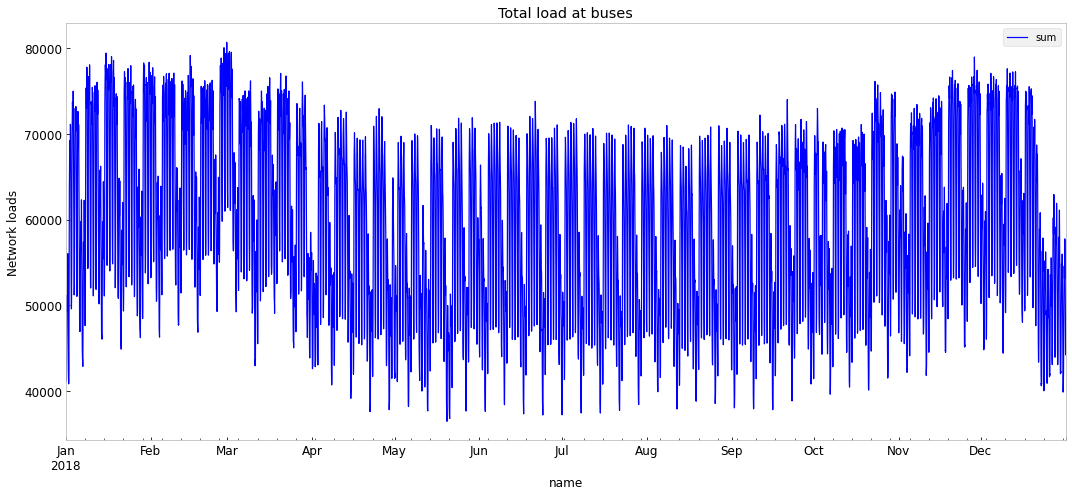

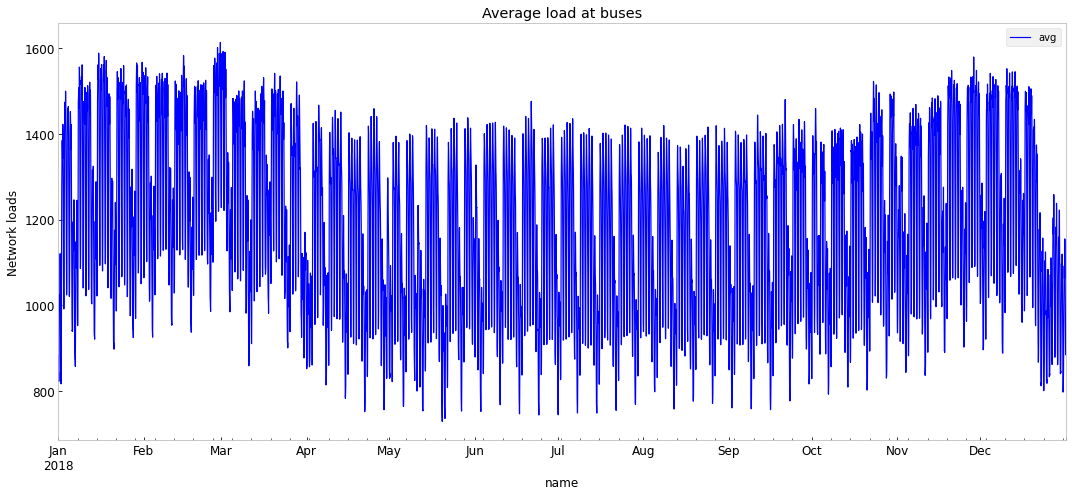

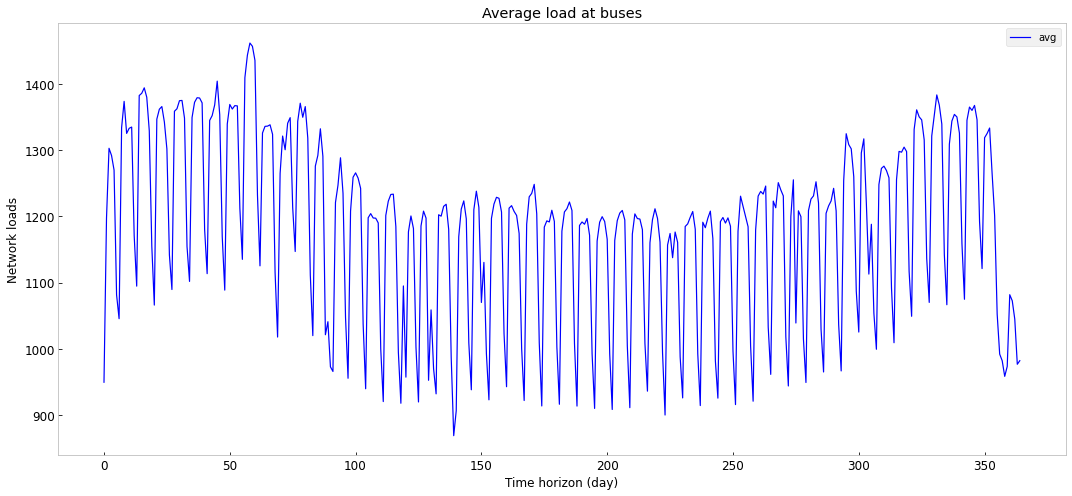

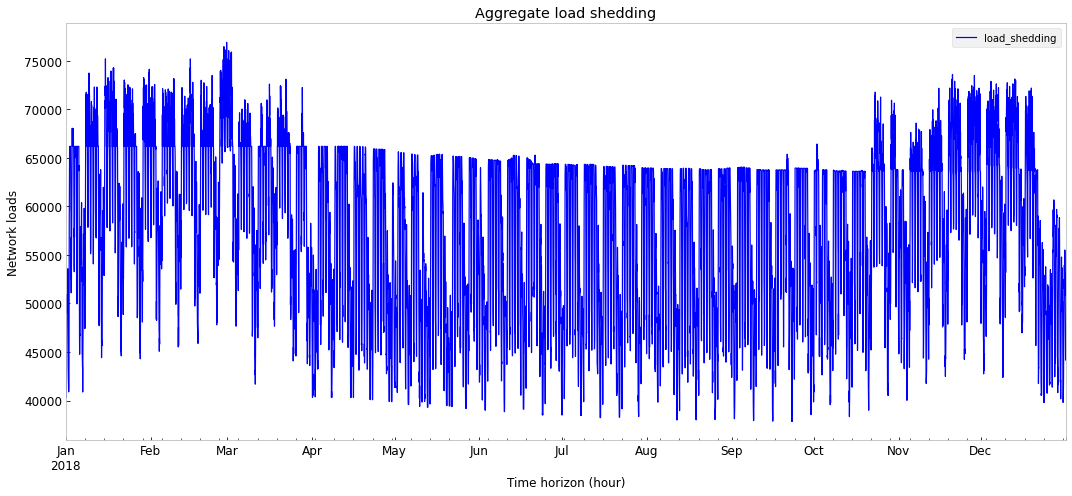

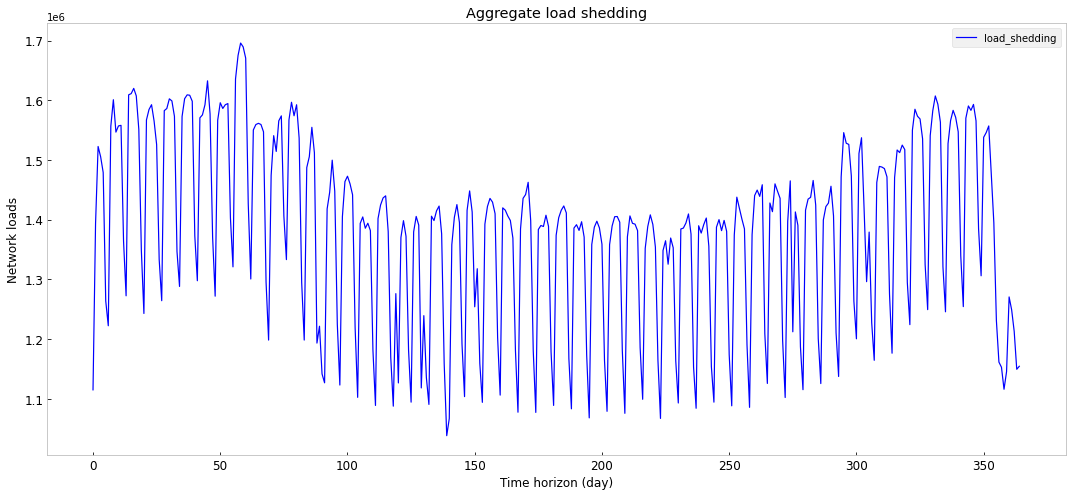

In [84]:
# Plot load analysis
# ------------------


# Hourly load SUM in germany
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_loads_p["sum"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Total load at buses", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Average load in germany
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_loads_p["avg"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Average load at buses", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Average load in germany DAILY
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_loads_p_day["avg"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Average load at buses", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Plot aggregated load shedding 
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_gen_shed["load_shedding"].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Aggregate load shedding", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Plot aggregated load shedding DAY
fig, ax  = plt.subplots(figsize = (15, 7))
ax.set_ylabel('Network loads',  fontsize = 12)
ax.set_xlabel("Time horizon (hour)", fontsize = 12)
ax = df_gen_shed_day["load_shedding"].iloc[:-1].plot.line(stacked = False, ax = ax, color = "blue", legend = True, 
                                 title = "Aggregate load shedding", linewidth = 1.2, fontsize = 12)
ax.set_facecolor('white')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.0)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()


# Plot regionalization of analysis outcomes

In [7]:
# SPDX-FileCopyrightText: : 2017-2020 The PyPSA-Eur Authors
#
# SPDX-License-Identifier: GPL-3.0-or-later

"""
Plots map with pie charts and cost box bar charts.

Relevant Settings
-----------------

Inputs
------

Outputs
-------

Description
-----------

"""

import os
#bspath = os.path.abspath(__file__)
abspath = r"C:\\Users\\Willem\\pypsa-eur\\scripts"
dname = os.path.dirname(abspath)
os.chdir(dname)
#




import logging
import sys
sys.path.append("C:\\Users\\Willem\\pypsa-eur\\scripts")
from _helpers import (aggregate_p, aggregate_costs)

#
import pandas as pd
import numpy as np
from six.moves import zip

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
to_rgba = mpl.colors.colorConverter.to_rgba

logger = logging.getLogger(__name__)


def load_network_for_plots(fn, tech_costs, config, combine_hydro_ps=True):
    import pypsa
    from add_electricity import update_transmission_costs, load_costs

    n = pypsa.Network(fn)

    n.loads["carrier"] = n.loads.bus.map(n.buses.carrier) + " load"
    n.stores["carrier"] = n.stores.bus.map(n.buses.carrier)

    n.links["carrier"] = (n.links.bus0.map(n.buses.carrier) + "-" + n.links.bus1.map(n.buses.carrier))
    n.lines["carrier"] = "AC line"
    n.transformers["carrier"] = "AC transformer"

    n.lines['s_nom'] = n.lines['s_nom_min']
    n.links['p_nom'] = n.links['p_nom_min']

    if combine_hydro_ps:
        n.storage_units.loc[n.storage_units.carrier.isin({'PHS', 'hydro'}), 'carrier'] = 'hydro+PHS'

    # if the carrier was not set on the heat storage units
    # bus_carrier = n.storage_units.bus.map(n.buses.carrier)
    # n.storage_units.loc[bus_carrier == "heat","carrier"] = "water tanks"

    Nyears = n.snapshot_weightings.sum() / 8760.
    costs = load_costs(Nyears, tech_costs, config['costs'], config['electricity'])
    update_transmission_costs(n, costs)

    return n



#
def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()
    def axes2pt():
        return np.diff(ax.transData.transform([(0,0), (1,1)]), axis=0)[0] * (72./fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses: e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5*width-0.5*xdescent, 0.5*height-0.5*ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}

def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0,0), radius=(s/scale)**0.5, **kw) for s in sizes]

def set_plot_style():
    plt.style.use(['classic', 'seaborn-white',
                {'axes.grid': False, 'grid.linestyle': '--', 'grid.color': u'0.6',
                    'hatch.color': 'white',
                    'patch.linewidth': 0.5,
                    'font.size': 9,
                    'legend.fontsize': 'small',
                    'lines.linewidth': 1.5,
                    'pdf.fonttype': 42,
                }])

def plot_map(n, ax=None, attribute='p_nom', opts={}):
    if ax is None:
        ax = plt.gca()

    ## DATA
    line_colors = {'cur': "purple",
                   'exp': mpl.colors.rgb2hex(to_rgba("red", 0.7), True)}
    tech_colors = opts['tech_colors']

    if attribute == 'p_nom':
        # bus_sizes = n.generators_t.p.sum().loc[n.generators.carrier == "load"].groupby(n.generators.bus).sum()
        bus_sizes = pd.concat((n.generators.query('carrier != "load"').groupby(['bus', 'carrier']).p_nom_opt.sum(),
                               n.storage_units.groupby(['bus', 'carrier']).p_nom_opt.sum()))
        line_widths_exp = dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt)
        line_widths_cur = dict(Line=n.lines.s_nom_min, Link=n.links.p_nom_min)
    else:
        raise 'plotting of {} has not been implemented yet'.format(attribute)


    line_colors_with_alpha = \
    dict(Line=(line_widths_cur['Line'] / n.lines.s_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}),
        Link=(line_widths_cur['Link'] / n.links.p_nom > 1e-3)
        .map({True: line_colors['cur'], False: to_rgba(line_colors['cur'], 0.)}))

    ## FORMAT
    linewidth_factor = opts['map'][attribute]['linewidth_factor']
    bus_size_factor  = opts['map'][attribute]['bus_size_factor']

    # PLOT
    n.plot(line_widths=line_widths_exp['Line']/linewidth_factor,
           link_widths=line_widths_exp['Link']/linewidth_factor,
           line_colors=line_colors['exp'],
           link_colors=line_colors['exp'],
           bus_sizes=bus_sizes/bus_size_factor,
           bus_colors=tech_colors,
           boundaries=map_boundaries,
           geomap=True,
           ax=ax)
    n.plot(line_widths=line_widths_cur['Line']/linewidth_factor,
           link_widths=line_widths_cur['Link']/linewidth_factor,
           line_colors='purple',
           link_colors='purple',
           bus_sizes=0,
#           bus_colors=tech_colors,
           boundaries=map_boundaries,
           geomap=False,
           ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

    # Rasterize basemap
    # TODO : Check if this also works with cartopy
    for c in ax.collections[:2]: c.set_rasterized(True)

    # LEGEND
    handles = []
    labels = []

    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['exp'],
                                linewidth=s*1e3/linewidth_factor))
        labels.append("{} GW".format(s))
    l1_1 = ax.legend(handles, labels,
                     loc="upper right", bbox_to_anchor=(0.25, 1.01),
                     frameon=False,
                     labelspacing=0.8, handletextpad=1.5,
                     title='Grid exist. / exp.                    ')
    ax.add_artist(l1_1)

    handles = []
    labels = []
    for s in (10, 5):
        handles.append(plt.Line2D([0],[0],color=line_colors['cur'],
                                linewidth=s*1e3/linewidth_factor))
        labels.append("/")
    l1_2 = ax.legend(handles, labels,
                loc="upper right", bbox_to_anchor=(0.02, 1.01),
                frameon=False,
                labelspacing=0.8, handletextpad=0.5,
                title=' ')
    ax.add_artist(l1_2)

    handles = make_legend_circles_for([10e3, 5e3, 1e3], scale=bus_size_factor, facecolor="w")
    labels = ["{} GW".format(s) for s in (10, 5, 3)]
    l2 = ax.legend(handles, labels,
                loc="upper left", bbox_to_anchor=(0.18, 1.01),
                frameon=False, labelspacing=1.0,
                title='Generation',
                handler_map=make_handler_map_to_scale_circles_as_in(ax))
    ax.add_artist(l2)

    techs =  (bus_sizes.index.levels[1]) & pd.Index(opts['vre_techs'] + opts['conv_techs'] + opts['storage_techs'])
    handles = []
    labels = []
    for t in techs:
        handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
        labels.append(opts['nice_names'].get(t, t))
    l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.5, -0.), # bbox_to_anchor=(0.72, -0.05),
                handletextpad=0., columnspacing=0.5, ncol=4, title='Technology')

    return fig
#

def plot_total_energy_pie(n, ax=None):
    if ax is None: ax = plt.gca()

    ax.set_title('Energy per technology', fontdict=dict(fontsize="medium"))

    e_primary = aggregate_p(n).drop('load', errors='ignore').loc[lambda s: s>0]

    patches, texts, autotexts = ax.pie(e_primary,
        startangle=90,
        labels = e_primary.rename(opts['nice_names']).index,
        autopct='%.0f%%',
        shadow=False,
        colors = [opts['tech_colors'][tech] for tech in e_primary.index])
    for t1, t2, i in zip(texts, autotexts, e_primary.index):
        if e_primary.at[i] < 0.04 * e_primary.sum():
            t1.remove()
            t2.remove()

def plot_total_cost_bar(n, ax=None):
    if ax is None: ax = plt.gca()

    total_load = (n.snapshot_weightings * n.loads_t.p.sum(axis=1)).sum()
    tech_colors = opts['tech_colors']

    def split_costs(n):
        costs = aggregate_costs(n).reset_index(level=0, drop=True)
        costs_ex = aggregate_costs(n, existing_only=True).reset_index(level=0, drop=True)
        return (costs['capital'].add(costs['marginal'], fill_value=0.),
                costs_ex['capital'], costs['capital'] - costs_ex['capital'], costs['marginal'])

    costs, costs_cap_ex, costs_cap_new, costs_marg = split_costs(n)

    costs_graph = pd.DataFrame(dict(a=costs.drop('load', errors='ignore')),
                            index=['AC-AC', 'AC line', 'onwind', 'offwind-ac',
                                   'offwind-dc', 'solar', 'OCGT','CCGT', 'battery', 'H2']).dropna()
    bottom = np.array([0., 0.])
    texts = []

    for i,ind in enumerate(costs_graph.index):
        data = np.asarray(costs_graph.loc[ind])/total_load
        ax.bar([0.5], data, bottom=bottom, color=tech_colors[ind],
               width=0.7, zorder=-1)
        bottom_sub = bottom
        bottom = bottom+data

        if ind in opts['conv_techs'] + ['AC line']:
            for c in [costs_cap_ex, costs_marg]:
                if ind in c:
                    data_sub = np.asarray([c.loc[ind]])/total_load
                    ax.bar([0.5], data_sub, linewidth=0,
                        bottom=bottom_sub, color=tech_colors[ind],
                        width=0.7, zorder=-1, alpha=0.8)
                    bottom_sub += data_sub

        if abs(data[-1]) < 5:
            continue

        text = ax.text(1.1,(bottom-0.5*data)[-1]-3,opts['nice_names'].get(ind,ind))
        texts.append(text)

    ax.set_ylabel("Average system cost [Eur/MWh]")
    ax.set_ylim([0, opts.get('costs_max', 80)])
    ax.set_xlim([0, 1])
    ax.set_xticklabels([])
    ax.grid(True, axis="y", color='k', linestyle='dotted')

#%%
from _helpers import mock_snakemake
snakemake = mock_snakemake('plot_network', network='elec', simpl='300', clusters='50', ll='copt', opts='1H-noex',
                          attr='p_nom', ext="pdf")
set_plot_style()
#
opts = snakemake.config['plotting']
map_figsize = opts['map']['figsize']
map_boundaries = opts['map']['boundaries']
#
n = load_network_for_plots(snakemake.input.network, snakemake.input.tech_costs, snakemake.config)
#
scenario_opts = snakemake.wildcards.opts.split('-')
#
fig, ax = plt.subplots(figsize=map_figsize, subplot_kw={"projection": ccrs.PlateCarree()})
#
plot_map(n, ax, snakemake.wildcards.attr, opts)
#
fig.savefig(snakemake.output.only_map, dpi=150, bbox_inches='tight')
#%%
ax1 = fig.add_axes([-0.115, 0.625, 0.2, 0.2])
plot_total_energy_pie(n, ax1)

ax2 = fig.add_axes([-0.075, 0.1, 0.1, 0.45])
plot_total_cost_bar(n, ax2)
#
ll = snakemake.wildcards.ll
ll_type = ll[0]
ll_factor = ll[1:]
lbl = dict(c='line cost', v='line volume')[ll_type]
amnt = '{ll} x today\'s'.format(ll=ll_factor) if ll_factor != 'opt' else 'optimal'
fig.suptitle('Expansion to {amount} {label} at {clusters} clusters'
            .format(amount=amnt, label=lbl, clusters=snakemake.wildcards.clusters))

fig.savefig(snakemake.output.ext, transparent=True, bbox_inches='tight')
#


AssertionError: mock_snakemake has to be run from the repository scripts directory C:\Users\Willem\pypsa-eur\scripts

In [ ]:
# Extract results from dispatch & redispatch optimization



# cost reduction
delta_objective = network_rd.objective - network_rd_bat.objective
print(round(delta_objective, 2))

# Dispatch time series
df_dispatch_t = network.generators_t.p.copy()
df_dispatch_t["Sum"] = df_dispatch_t.sum(axis = 1)

# Redispatch w/o batteries
# ------------------------

# Redispatch df
df_redispatch_t = network_rd.generators_t.p.copy()
cols_rd = [column for column in list(df_redispatch_t) if "pos" in column or "neg" in column]         
df_redispatch_t = df_redispatch_t.copy()[cols_rd]

# Resulting dispatch after redispatch
#display(df_redispatch_t)

# Absolute redispatch df
df_redispatch_abs = df_redispatch_t.abs()
df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# df for positive rd
cols_rd_pos = [column for column in list(df_redispatch_t) if "pos" in column]         
df_redispatch_t_pos = df_redispatch_t.copy()[cols_rd_pos]
df_redispatch_t_pos["Sum pos"] = df_redispatch_t_pos.sum(axis = 1)

# df for negative rd
cols_rd_neg = [column for column in list(df_redispatch_t) if "neg" in column]         
df_redispatch_t_neg = df_redispatch_t.copy()[cols_rd_neg]
df_redispatch_t_neg["Sum neg"] = df_redispatch_t_neg.sum(axis = 1)

# Add sums to redispatch df
df_redispatch_t["Sum pos"] = df_redispatch_t_pos["Sum pos"]
df_redispatch_t["Sum neg"] = df_redispatch_t_neg["Sum neg"]


# Redispatch w/ batteries
# ------------------------

# Redispatch time series with batteries
df_redispatch_t_bat = network_rd_bat.generators_t.p.copy()
cols_rd = [column for column in list(df_redispatch_t_bat) if "pos" in column or "neg" in column]         
df_redispatch_t_bat = df_redispatch_t_bat[cols_rd].copy()

# Absolute redispatch df
df_redispatch_abs = df_redispatch_t_bat.abs()
df_redispatch_abs["Sum"] = df_redispatch_abs.sum(axis = 1)

# df for positive rd
cols_rd_pos = [column for column in list(df_redispatch_t_bat) if "pos" in column]         
df_redispatch_t_bat_pos = df_redispatch_t_bat.copy()[cols_rd_pos]
df_redispatch_t_bat_pos["Sum pos"] = df_redispatch_t_bat_pos.sum(axis = 1)

# df for negative rd
cols_rd_neg = [column for column in list(df_redispatch_t_bat) if "neg" in column]         
df_redispatch_t_bat_neg = df_redispatch_t_bat.copy()[cols_rd_neg]
df_redispatch_t_bat_neg["Sum neg"] = df_redispatch_t_bat_neg.sum(axis = 1)

# Add sums to redispatch df
df_redispatch_t_bat["Sum pos"] = df_redispatch_t_bat_pos["Sum pos"]
df_redispatch_t_bat["Sum neg"] = df_redispatch_t_bat_neg["Sum neg"]

# df with difference of redispatch
df_bat_vs_nobat = pd.concat([df_redispatch_t[["Sum pos", "Sum neg"]], df_redispatch_t_bat[["Sum pos", "Sum neg"]]], axis = 1)
df_bat_vs_nobat["Difference positive"] = abs(df_bat_vs_nobat.iloc[:,0] - df_bat_vs_nobat.iloc[:,2])
df_bat_vs_nobat["Difference negative"] = - abs(df_bat_vs_nobat.iloc[:,1] - df_bat_vs_nobat.iloc[:,3])
#display(df_bat_vs_nobat)

# battery charging operations (of one in the north and one in the south)
df_bess = network_rd_bat.stores
df_bess_t_p = network_rd_bat.stores_t.p

display(network_rd_bat.stores_t.p)
display(network_rd_bat.stores_t.e)
display(network_rd_bat.stores.e_nom.T)
df_bess_SOC = network_rd_bat.stores_t.e / network_rd_bat.stores.e_nom.T
print("df_bess_SOC")
display(df_bess_SOC)






### Backup Code (Ältere Versionen)

In [ ]:
# RUN THE MODEL
# ----------------

# import both the operative network (n) as well as the optimized investment network n_optim
n = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\elec_s300_16_ec_lcopt_1H.nc")
n_optim = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc")

filepath = r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\elec_s300_16_ec_lcopt_1H.nc"

for c in n_optim.iterate_components(list(n.components.keys())[2:]):
    print("{} has {} entries".format(c.name,len(c.df)))
    
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("{} has {} entries".format(c.name,len(c.df)))  

# Run the redispatch workflow with batteries
nw = n.copy(snapshots = network.snapshots[0:24*7])
nw_optim = n_optim.copy(snapshots = network.snapshots[0:24*7])

export_path = r"C:\Users\Willem\pypsa-eur\networks_redispatch\results"

n_d, n_rd, dict_obj_d, dict_obj_rd = redispatch_workflow(nw, nw_optim, scenario = "no bat")
n_d.export_to_netcdf(path= export_path + "\dispatch\{}".format(filepath.split('\\')[-1]),
                     export_standard_types=False, least_significant_digit=None)
# export network as .nc



In [ ]:
# ------------------------
# Plots w/o bat
# ------------------------

# # Dispatch time series
# cols = list(df_dispatch_t)[:-1]
# fig, ax  = plt.subplots(figsize = (10, 5))
# ax.set_ylabel('MW Redispatch',  fontsize = 12)
# ax = df_dispatch_t.loc[:, cols].plot.bar(stacked = True, ax = ax, title = "Dispatch after market clearing", legend = True, fontsize = 12)
# ax.set_facecolor('white')
# ax.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (pos vs. neg aggregate) 
# cols_0 = list(df_redispatch_t)[-2:]
# fig, ax_0  = plt.subplots(figsize = (10, 5))
# ax_0.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_0 = df_redispatch_t.loc[:, cols_0].plot.bar(stacked = True, ax = ax_0, title = "Amount of redispatch", legend = True, fontsize = 12)
# ax_0.set_facecolor('white')
# ax_0.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (aggregate) 
# cols_1 = list(df_redispatch_abs)[:-1]
# fig, ax_1  = plt.subplots(figsize = (10, 5))
# ax_1.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_1 = df_redispatch_abs.loc[:, cols_1].plot.bar(stacked = True, ax = ax_1, title = "Aggregated amount of redispatch", legend = True, fontsize = 12)
# ax_1.set_facecolor('white')
# ax_1.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (positive rd) 
# cols_2 = list(df_redispatch_t_pos)[:-1]
# fig, ax_2  = plt.subplots(figsize = (10, 5))
# ax_2.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_2 = df_redispatch_t_pos.loc[:, cols_2].plot.bar(stacked = True, ax = ax_2, title = "Amount of positive redispatch (ramp up)", legend = True, fontsize = 12)
# ax_2.set_facecolor('white')
# ax_2.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Redispatch time series (negative rd) 
# cols_3 = list(df_redispatch_t_neg)[:-1]
# fig, ax_3  = plt.subplots(figsize = (10, 5))
# ax_3.set_ylabel('MW Redispatch',  fontsize = 12)
# ax_3 = df_redispatch_t_neg.loc[:, cols_3].plot.bar(stacked = True, ax = ax_3, title = "Amount of negative redispatch (curtailment)", legend = True, fontsize = 12)
# ax_3.set_facecolor('white')
# ax_3.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# # Plots w/ bat
# # ------------------------

# Redispatch time series (pos vs. neg aggregate) 
cols_4 = list(df_redispatch_t_bat)[-2:]
fig, ax_4  = plt.subplots(figsize = (10, 5))
ax_4.set_ylabel('MW Redispatch',  fontsize = 12)
ax_4 = df_redispatch_t_bat.loc[:, cols_4].plot.bar(stacked = True, ax = ax_4, title = "Amount of positive and negative redispatch", legend = True, fontsize = 12)
ax_4.set_facecolor('white')
ax_4.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Difference positive vs negative redispatch 
cols_5 = list(df_bat_vs_nobat)[-2:]
fig, ax_5  = plt.subplots(figsize = (10, 5))
ax_5.set_ylabel('MW Redispatch',  fontsize = 12)
ax_5 = df_bat_vs_nobat.loc[:, cols_5].plot.bar(stacked = True, ax = ax_5, title = "Difference between redispatch with and without bat", legend = True, fontsize = 12)
ax_5.set_facecolor('white')
ax_5.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Plots battery insights
# ------------------------

# Battery charging operations (battery in the north)
cols_6 = ["BESS_1","BESS_2","BESS_3"]
fig, ax_6  = plt.subplots(figsize = (10, 5))
ax_6.set_ylabel('MW Redispatch',  fontsize = 12)
ax_6 = df_bess_t_p.loc[:, cols_6].plot.bar(stacked = True, ax = ax_6, title = "Battery active power in redispatch", legend = True, fontsize = 12)
ax_6.set_facecolor('white')
ax_6.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)

# Battery SOC
cols_7 = ["BESS_1","BESS_2","BESS_3"]
fig, ax_7  = plt.subplots(figsize = (10, 5))
ax_7.set_ylabel('Battery SOC',  fontsize = 12)
ax_7 = df_bess_SOC.loc[:, cols_7].plot.line(stacked = False, ax = ax_7, title = "Battery SOC during redispatch", legend = True, fontsize = 12)
ax_7.set_facecolor('white')
ax_7.grid(color = 'grey', linestyle = '-.', linewidth = 1.0)
                   

        
    


In [ ]:
def set_parameters_from_optimized(n, n_optim):
    '''
    Function to set optimized parameters from optimized network as nominal parameters
    of the operative network.
    -----
    Param:
    n: Optimized investment network.
    n_optim: Operative network for redispatch simulation.
    '''
    # set line capacities to optimized
    lines_typed_i = n.lines.index[n.lines.type != '']
    n.lines.loc[lines_typed_i, 'num_parallel'] = \
        n_optim.lines['num_parallel'].reindex(lines_typed_i, fill_value=0.)
    n.lines.loc[lines_typed_i, 's_nom'] = (
            np.sqrt(3) * n.lines['type'].map(n.line_types.i_nom) *
            n.lines.bus0.map(n.buses.v_nom) * n.lines.num_parallel)

    lines_untyped_i = n.lines.index[n.lines.type == '']
    for attr in ('s_nom', 'r', 'x'):
        n.lines.loc[lines_untyped_i, attr] = \
            n_optim.lines[attr].reindex(lines_untyped_i, fill_value=0.)
    n.lines['s_nom_extendable'] = False

    # set link capacities to optimized (HVDC links as well as store out/inflow links)
    links_dc_i = n.links.index[n.links.carrier == 'DC']
    n.links.loc[links_dc_i, 'p_nom'] = \
        n_optim.links['p_nom_opt'].reindex(links_dc_i, fill_value=0.)
    n.links.loc[links_dc_i, 'p_nom_extendable'] = False

    # set extendable generators to optimized and p_nom_extendable to False
    gen_extend_i = n.generators.index[n.generators.p_nom_extendable]
    n.generators.loc[gen_extend_i, 'p_nom'] = \
        n_optim.generators['p_nom_opt'].reindex(gen_extend_i, fill_value=0.)
    n.generators.loc[gen_extend_i, 'p_nom_extendable'] = False

    # set extendable storage unit power to ooptimized
    stor_extend_i = n.storage_units.index[n.storage_units.p_nom_extendable]
    n.storage_units.loc[stor_extend_i, 'p_nom'] = \
        n_optim.storage_units['p_nom_opt'].reindex(stor_extend_i, fill_value=0.)
    n.storage_units.loc[stor_extend_i, 'p_nom_extendable'] = False
    return n


def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)

    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0) / network.lines.s_nom)
    max_loading = (network.lines_t.p0 / network.lines.s_nom).max(axis=0)
    print(max_loading)

    # In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    # At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    # it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    # to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)


def clean_batteries(network):
    """
    Clean up all previously saved battery components (FROM PYPSA-EUR) related to redispatch (does NOT delete the inital batteries)
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()
                                    if network.storage_units.loc[name]["carrier"] == "battery"])
    network.mremove("Link", [name for name in network.links.index.tolist()
                             if "BESS" in name])
    network.mremove("Store", [name for name in network.stores.index.tolist()
                              if "BESS" in name])
    network.mremove("Bus", [name for name in network.buses.index.tolist()
                            if "BESS" in name])


def add_BESS_loadflexibility(network, network_year, flex_potential=10000, c_rate=0.25, flex_share=0.1):
    '''
    Adds battery storages at every node, depending on the flexibility potential of the loads allocated to this node.
    Methodology according to Network development plan and Frontier study:
        - Flexibility potential at load-nodes: Flexibility Potential through stationary battery storage in distribution grids
        - Flexibility potential at power plants: Flexibility through battery installations at powerplants (by operators)

    Following the assumption of x percentage of frontier flexibility potential being installed at node according to loads.
    Flexibility potential can e.g. be aggregated powerwall capacity at the node.
    -----
    Param:
    network: network from dispatch optimization
    network_year: full time resolution network (typically 1 year)
    flex_potential: Total flexibility potential from distribution grid (default: frontier-study potential)
    '''
    # Clean up all previously saved battery components
    clean_batteries(network)
    # get bus names
    bus_names = network.buses.index.tolist()
    # get mean load at every bus
    df_loads = network_year.loads
    df_loads["p_mean"] = network_year.loads_t.p_set.mean(axis=0)

    # According to x% rule, add energy stores with energy = x% of average load at bus
    for i in range(len(bus_names)):
        bus_name = network.buses.index.tolist()[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        # determin flexibility at bus
        df_loads_bus = df_loads[df_loads["bus"] == bus_name]

        ################

        # TODO: ÄNDERN DER maximalen energie: Die speicherbare energie soll abhängig vom mittelwert der last
        # über den GESAMTEN zeitraum sein, nicht nur vom mittelwert des aktuellen (1 day) networks!

        ################

        if not df_loads_bus.empty:
            p_flex = df_loads_bus.p_mean * flex_share
        else:
            p_flex = 0

        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name=battery_bus,
                    x=network.buses.loc[bus_name, "x"],
                    y=network.buses.loc[bus_name, "y"],
                    carrier="battery")
        # add store
        network.add("Store", name="BESS_{}".format(i), bus=battery_bus,
                    e_nom=p_flex / c_rate, e_nom_extendable=False,
                    e_min_pu=0, e_max_pu=1, e_initial=0.5, e_cyclic=False,
                    p_set=p_flex, q_set=0.05, marginal_cost=0,
                    capital_cost=0, standing_loss=0)
        # discharge link
        network.add("Link",
                    name="BESS_{}_discharger".format(i + 1),
                    bus0=battery_bus, bus1=bus_name, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)
        # charge link
        network.add("Link",
                    name="BESS_{}_charger".format(i + 1),
                    bus0=bus_name, bus1=battery_bus, capital_cost=0,
                    p_nom=p_flex, p_nom_extendable=False, p_max_pu=1, p_min_pu=0,
                    marginal_cost=0, efficiency=0.96)
    network.name = str(network.name) + " BESS loadflexibility"


def add_BESS_plant(network):
    '''
    Adds static battery storages (fixed capacity) to the base network at locations where large central powerplants
    are located. Battery storage capacity is added based on the generation capacity at a specific network bus. These
    batteries are solely used for redispatch purposes. The investments in those batteries is only used for redispatch.

    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components

    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name, "BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name=battery_bus,
                    x=network.buses.loc[bus_name, "x"],
                    y=network.buses.loc[bus_name, "y"],
                    carrier="battery")
        # discharge link
        network.add("Link",
                    name="Battery_{}_dCH".format(i + 1),
                    bus0=battery_bus,
                    bus1=bus_name,
                    capital_cost=0,
                    p_nom=150,
                    p_nom_extendable=False,
                    p_max_pu=1,
                    p_min_pu=0,
                    marginal_cost=0,
                    efficiency=0.96)
        # charge link
        network.add("Link",
                    name="Battery_{}_CH".format(i + 1),
                    bus0=bus_name,
                    bus1=battery_bus,
                    capital_cost=0,
                    p_nom=150,
                    p_nom_extendable=False,
                    p_max_pu=1,
                    p_min_pu=0,
                    marginal_cost=0,
                    efficiency=0.96)
        # add store
        network.add("Store", name="BESS_{}".format(i),
                    bus=battery_bus,
                    e_nom=200,
                    e_nom_extendable=False,
                    e_min_pu=0,
                    e_max_pu=1,
                    e_initial=0.5,
                    e_cyclic=True,
                    p_set=100,
                    q_set=0.05,
                    marginal_cost=0,
                    capital_cost=0,
                    standing_loss=0)
    network.name = str(network.name) + " BESS"


def clean_generators(network):
    """
    Remove all generators from network
    """
    network.mremove("Generator", [name for name in network.generators.index.tolist()])


def build_redispatch_network(network, network_dispatch):
    '''
    Uses predefined component building functions for building the redispatch network.
    Passes the dispatch per generator as fixed generation for each generator.
    Adds a ramp down generator (neg. redispatch) and ramp up generator (pos. redispatch) for each conventional generator.
    Adds a ramp down generator (curtailment) for each EE generator.
    -----
    Parameters:
    network: network representing one day of snapshots (not optimized)
    network_dispatch: network from dispatch optimization (one node market model)
    '''
    # Copy initial network and remove generators for redispatch step
    network_redispatch = network.copy()
    clean_generators(network_redispatch)

    # Add new generators for redispatch calculation
    l_generators = network.generators.index.tolist()
    l_conv_carriers = ["hard coal", "lignite", "gas", "oil", "nuclear", "OCGT", "CCGT"]

    for generator in l_generators:

        # For each conventional generator in network: Add 3 generators in network_redispatch
        if network.generators.loc[generator]["carrier"] in l_conv_carriers:
            # Base generator from network, power range is fixed by dispatch simulation results (therefore runs at 0 cost)
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Upwards generator (positive redispatch) ranges within the difference of the base power p_max_pu (e.g. 0.92) and p_max_pu = 1
            network_redispatch.add("Generator",
                                   name="{}_pos".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=network.generators.loc[generator]["marginal_cost"],
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(1 - network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=0,
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] -
                                                  network_dispatch.buses_t.marginal_price[
                                                      network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )

        else:
            # For renewable sources: Only add base and negative generator, representing the curtailment of EE
            network_redispatch.add("Generator",
                                   name="{}".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=0,
                                   capital_cost=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_max_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   p_min_pu=(network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
            # Downwards generator (negative redispatch): Using this generator reduces the energy feed in at specific bus,
            # but increases costs for curtialment. Cost for curtailment = lost profit for not feeding in - savings through ramp down
            network_redispatch.add("Generator",
                                   name="{}_neg".format(generator),
                                   bus=network.generators.loc[generator]["bus"],
                                   p_nom=network.generators.loc[generator]["p_nom"],
                                   efficiency=network.generators.loc[generator]["efficiency"],
                                   marginal_cost=(network.generators.loc[generator]["marginal_cost"] -
                                                  network_dispatch.buses_t.marginal_price[
                                                      network_dispatch.generators.loc[generator]["bus"]]).tolist(),
                                   capital_cost=0,
                                   p_max_pu=0,
                                   carrier=network.generators.loc[generator]["carrier"],
                                   p_min_pu=(- network_dispatch.generators_t.p[generator] /
                                             network_dispatch.generators.loc[generator]["p_nom"]).tolist(),
                                   )
    network_redispatch.name = str(network_redispatch.name) + " redispatch"
    return network_redispatch


def build_market_model(network):
    '''
    Clusters all generators, loads, stores and storage units to a single (medoid) bus to emulate market simulation.
    For faster computation: Assign to first bus of dataset
    TODO: For multiple countries, the dataset to be clusterd first needs to be separated by country (groupby("country")) and then clustered.
    '''
    mode = "default"
    network_dispatch = network.copy()

    # cluster all buses to the center one and assign all grid elements to that bus
    df_busmap = network_dispatch.buses

    if mode == "cluster":
        # Cluster buses to 1 cluster & compute center
        np_busmap = df_busmap[["x", "y"]].to_numpy()
        k_medoids = KMedoids(n_clusters=1, metric='euclidean', init='k-medoids++', max_iter=300, random_state=None)
        score = k_medoids.fit(np_busmap)
        x_medoid = k_medoids.cluster_centers_[0][0]
        y_medoid = k_medoids.cluster_centers_[0][1]
        # find single medoid bus in dataframe
        market_bus = df_busmap[(df_busmap["x"] == x_medoid) & (df_busmap["y"] == y_medoid)].squeeze()
        bus_name = str(market_bus.name)  # save bus name, remove brackets & quotemarks
    else:
        # bus_name = str(df_busmap[0].index.values)[2:-2]
        bus_name = df_busmap.iloc[0].name

    # assign all generators, loads, storage_units, stores to the medoid bus (market_bus)
    network_dispatch.loads["bus"] = bus_name
    network_dispatch.generators["bus"] = bus_name
    network_dispatch.stores["bus"] = bus_name
    network_dispatch.storage_units["bus"] = bus_name
    return network_dispatch


def solve_redispatch_network(network, network_dispatch):
    '''
    Calls the building function and solves the network under redispatch constraints.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    network_redispatch = build_redispatch_network(network, network_dispatch)
    # Solve new network
    network_redispatch.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")
    return network_redispatch


# Redispatch workflow with batteries
def build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share):
    '''
    Uses predefined component building functions for building the redispatch network and adds batteries.
    -----
    Parameters:
    network: network from dispatch optimization
    '''
    network_redispatch_bat = build_redispatch_network(network, network_dispatch)
    # Adding a battery at every node
    add_BESS_loadflexibility(network_redispatch_bat, network_year, c_rate, flex_share)

    return network_redispatch_bat


def solve_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate, flex_share):
    '''
    Calls redispatch building function and solves the network.
    -----
    Parameters:
    network: network from dispatch optimization
    '''

    #### TODO: add extra functionality that only pos OR negative can be =! 0 during 1 snapshot

    network_redispatch_bat = build_redispatch_network_with_bat(network, network_dispatch, network_year, c_rate,
                                                               flex_share)
    # Solve new network
    network_redispatch_bat.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")

    return network_redispatch_bat


def concat_network(list_networks, ignore_standard_types=False):
    '''
    Function that merges technically identical, but temporally decoupled networks by concatenating
    their time-dependent components (input & output)
    -----
    Param:
    l_networks: list of daily solved networks (can be either l_networks_dispatch or l_networks_redispatch)
    scenario: Determines whether input networks will have stores or not
    '''
    from pypsa.io import (import_components_from_dataframe, import_series_from_dataframe)
    from six import iterkeys

    # create new network out of first network of the list of identical networks
    n_input = list_networks[0].copy()

    # Copy time indipendent components
    # -------------------
    override_components, override_component_attrs = n_input._retrieve_overridden_components()
    nw = n_input.__class__(ignore_standard_types=ignore_standard_types,
                           override_components=override_components,
                           override_component_attrs=override_component_attrs)

    for component in n_input.iterate_components(
            ["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        df = component.df
        # drop the standard types to avoid them being read in twice
        if not ignore_standard_types and component.name in n_input.standard_type_components:
            df = component.df.drop(nw.components[component.name]["standard_types"].index)
        import_components_from_dataframe(nw, df, component.name)

    # Time dependent components
    # --------------------
    # set snapshots
    snapshots = n_input.snapshots
    for network in list_networks[1:]:
        snapshots = snapshots.union(network.snapshots)
    nw.set_snapshots(snapshots)

    # concat time dependent components from all networks in input list
    for component in nw.iterate_components(["Bus", "Carrier"] + sorted(n_input.all_components - {"Bus", "Carrier"})):
        component_t = component.list_name + "_t"

        for attr, timeseries in component.pnl.items():
            l_component = []
            for network in list_networks:
                # each time dependent dataframe
                l_component.append(getattr(getattr(network, component_t), attr))
            # concat the components list to dataframe
            df_component = pd.concat(l_component, axis=0)
            # import time series from dataframe for output network
            import_series_from_dataframe(nw, df_component, component.name, attr)

    # catch all remaining attributes of network
    for attr in ["name", "srid"]:
        setattr(nw, attr, getattr(n_input, attr))

        # Concat objective value for partially solved networks
    obj = 0
    for network in list_networks:
        if hasattr(network, 'objective'):
            obj = obj + network.objective
    nw.objective = obj

    return nw


def redispatch_workflow(network, network_optim, scenario="no bat",
                        c_rate=0.25, flex_share=0.1):
    '''
    Function for executing the whole redispatch workflow.

    -----
    Param:
    network: Un-optimized network from pypsa-eur.
    network_optim: Already optimized network from the strategic network optimization in pypsa-eur.
    scenario: "bat" or "no bat" decides whether the redispatch optimization is run with or without batteries.
    Return:
    l_networks_list: List of solved daily dispatch and redispatch networks.
    '''
    # create lists to save results
    network_year = network
    l_networks_24 = []
    l_networks_dispatch = []
    l_networks_redispatch = []

    # Generate operative pypsa-eur network without investment problem
    network = set_parameters_from_optimized(network, network_optim)

    # Only operative optimization: Capital costs set to zero
    network.generators.loc[:, "capital_cost"] = 0

    # Run dispatch_redispatch workflow for every day (24h batch)
    for start_hour in range(0, len(network.snapshots), 24):

        # print(start_hour)
        n_24 = network.copy(snapshots=network.snapshots[start_hour:start_hour + 24])

        # Build market model, solve dispatch network and plot network insights
        # ---------------
        n_dispatch = build_market_model(n_24)
        n_dispatch.lopf(solver_name="gurobi", pyomo=False, formulation="kirchhoff")

        # Call redispatch optimization and plot network insights
        # ---------------
        if scenario == "no bat":
            n_redispatch = solve_redispatch_network(n_24, n_dispatch)
        elif scenario == "bat":
            n_redispatch = solve_redispatch_network_with_bat(n_24, n_dispatch, network_year, c_rate=0.25,flex_share=0.1)

        # Append networks to corresponding yearly lists
        # ---------------
        l_networks_24.append(n_24)
        l_networks_dispatch.append(n_dispatch)
        l_networks_redispatch.append(n_redispatch)

    # For each results list: Create a network out of daily networks for dispatch & redispatch
    # ---------------
    network_dispatch = concat_network(l_networks_dispatch)
    network_redispatch = concat_network(l_networks_redispatch)

    return network_dispatch, network_redispatch


def solve_all_redispatch_workflows(c_rate=0.25, flex_share=0.1):
    """
    Function to run the redispatch workflow for all networks in the networks_redispatch folder.
    """

    folder = r'/cluster/home/wlaumen/Euler/pypsa-eur/networks_redispatch'
    for filepath in glob.iglob(folder + '/*.nc'):
        filename = filepath.split('/')[-1].split(".")[0]
        print(filename + "\n\n\n\n\n\n")
        path_n = filepath
        path_n_optim = folder + "/solved/" + filename + ".nc"
        # Define network and network_optim
        n = pypsa.Network(path_n)
        n_optim = pypsa.Network(path_n_optim)

        # Run redispatch w/o batteries & export files
        n_d, n_rd = redispatch_workflow(n, n_optim, scenario="no bat",
                                                                 c_rate=0.25, flex_share=0.1)
        # export solved dispatch & redispatch workflow as well as objective value list
        export_path = folder + r"/results"
        n_d.export_to_netcdf(path=export_path + r"/dispatch/" + filename + ".nc",
                             export_standard_types=False, least_significant_digit=None)
        n_rd.export_to_netcdf(path=export_path + r"/redispatch/" + filename + ".nc",
                              export_standard_types=False, least_significant_digit=None)
        gc.collect()

        # Run redispatch with batteries & export files
        n_d_bat, n_rd_bat = redispatch_workflow(n, n_optim, scenario="bat",
                                                                                 c_rate=0.25, flex_share=0.1)
        # export solved dispatch & redispatch workflow as well as objective value list
        n_rd_bat.export_to_netcdf(path=export_path + r"/redispatch/" + filename + "_bat.nc",
                                  export_standard_types=False, least_significant_digit=None)
        gc.collect()

In [ ]:
network_rd.links

In [ ]:
n_300 = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks\elec_s300_200_ec_lcopt_1H-noex.nc")


In [ ]:
n_300.plot()
display(n_300.lines)
display(n_300.storage_units)
display(n_300.loads_t.p_set)
loads_df = n_300.loads_t.p_set.copy()
loads_df["sum"] = loads_df.sum(axis = 1)
display(loads_df)
display(n_300.generators_t.p_set)
linas = n_300.lines
linass = network_rd.lines
linas = linas.append(linas.sum(axis = 0), ignore_index=True)
linass = linass.append(linass.sum(axis = 0), ignore_index=True)
display(linas)
display(linass)

In [4]:
n_noex = pypsa.Network(r"C:\Users\Willem\pypsa-eur\networks_redispatch\solved\\elec_s300_130_ec_lcopt_1H-noex.nc")


INFO:pypsa.io:Imported network elec_s300_130_ec_lcopt_1H-noex.nc has buses, carriers, generators, lines, loads, storage_units


In [8]:
# Load shedding validity check
df_gen_shed = n_noex.generators_t.p.copy()
df_gen_shed["load_shedding"] = df_gen_shed.loc[:,"DE0 0 load" : "DE0 99 load"].sum(axis = 1)
df_gen_shed["sum"] = df_gen_shed.iloc[:,:-1].sum(axis = 1)
df_gen_shed["load_shedding_share"] = df_gen_shed["load_shedding"] / df_gen_shed["sum"]

# DAILY load shedding average
df_gen_shed_day = df_gen_shed.iloc[:,:-2].groupby(np.arange(len(df_gen_shed.iloc[:,:-2]))//24).sum()
df_gen_shed_day.index.rename("Time horizon (day)", inplace = True)
df_gen_shed_day = df_gen_shed_day.append(df_gen_shed_day.sum(axis = 0), ignore_index = True)
df_gen_shed_day["load_shedding"] = df_gen_shed_day.loc[:,"DE0 0 load" : "DE0 99 load"].sum(axis = 1)
df_gen_shed_day["sum"] = df_gen_shed_day.iloc[:,:-1].sum(axis = 1)
df_gen_shed_day["load_shedding_share"] = df_gen_shed_day["load_shedding"] / df_gen_shed_day["sum"]
print("Maximal relative load shedding per day: " + str(round(df_gen_shed_day["load_shedding_share"].iloc[:-1].max(), 4)))

display(df_gen_shed_day)

# Maximum load shedding:





Maximal relative load shedding per day: 0.3353


name,DE0 0 lignite,DE0 0 onwind,DE0 0 ror,DE0 0 solar,DE0 1 OCGT,DE0 1 biomass,DE0 1 coal,DE0 1 onwind,DE0 1 solar,DE0 10 CCGT,DE0 10 OCGT,DE0 10 coal,DE0 10 oil,DE0 10 onwind,DE0 10 solar,DE0 100 biomass,DE0 100 onwind,DE0 100 ror,DE0 100 solar,DE0 101 OCGT,DE0 101 coal,DE0 101 oil,DE0 101 onwind,DE0 101 ror,DE0 101 solar,DE0 102 OCGT,DE0 102 coal,DE0 102 onwind,DE0 102 ror,DE0 102 solar,DE0 103 onwind,DE0 103 ror,DE0 103 solar,DE0 104 onwind,DE0 104 ror,DE0 104 solar,DE0 105 CCGT,DE0 105 OCGT,DE0 105 coal,DE0 105 lignite,DE0 105 onwind,DE0 105 ror,DE0 105 solar,DE0 106 OCGT,DE0 106 biomass,DE0 106 onwind,DE0 106 solar,DE0 107 onwind,DE0 107 ror,DE0 107 solar,DE0 108 onwind,DE0 108 solar,DE0 109 OCGT,DE0 109 coal,DE0 109 onwind,DE0 109 solar,DE0 11 OCGT,DE0 11 biomass,DE0 11 coal,DE0 11 onwind,DE0 11 ror,DE0 11 solar,DE0 110 onwind,DE0 110 ror,DE0 110 solar,DE0 111 onwind,DE0 111 ror,DE0 111 solar,DE0 112 OCGT,DE0 112 onwind,DE0 112 solar,DE0 113 onwind,DE0 113 ror,DE0 113 solar,DE0 114 onwind,DE0 114 ror,DE0 114 solar,DE0 115 onwind,DE0 115 ror,DE0 115 solar,DE0 116 OCGT,DE0 116 oil,DE0 116 onwind,DE0 116 ror,DE0 116 solar,DE0 117 OCGT,DE0 117 biomass,DE0 117 onwind,DE0 117 ror,DE0 117 solar,DE0 118 onwind,DE0 118 ror,DE0 118 solar,DE0 119 CCGT,DE0 119 oil,DE0 119 onwind,DE0 119 ror,DE0 119 solar,DE0 12 CCGT,DE0 12 OCGT,DE0 12 biomass,DE0 12 coal,DE0 12 oil,DE0 12 onwind,DE0 12 ror,DE0 12 solar,DE0 120 biomass,DE0 120 lignite,DE0 120 onwind,DE0 120 solar,DE0 121 OCGT,DE0 121 coal,DE0 121 onwind,DE0 121 solar,DE0 122 onwind,DE0 122 solar,DE0 123 onwind,DE0 123 ror,DE0 123 solar,DE0 124 OCGT,DE0 124 onwind,DE0 124 solar,DE0 125 CCGT,DE0 125 OCGT,DE0 125 biomass,DE0 125 coal,DE0 125 oil,DE0 125 onwind,DE0 125 ror,DE0 125 solar,DE0 126 onwind,DE0 126 ror,DE0 126 solar,DE0 127 OCGT,DE0 127 biomass,DE0 127 onwind,DE0 127 solar,DE0 128 OCGT,DE0 128 coal,DE0 128 onwind,DE0 128 solar,DE0 129 OCGT,DE0 129 biomass,DE0 129 onwind,DE0 129 solar,DE0 13 OCGT,DE0 13 biomass,DE0 13 coal,DE0 13 onwind,DE0 13 ror,DE0 13 solar,DE0 14 CCGT,DE0 14 OCGT,DE0 14 biomass,DE0 14 nuclear,DE0 14 onwind,DE0 14 solar,DE0 15 OCGT,DE0 15 biomass,DE0 15 coal,DE0 15 onwind,DE0 15 ror,DE0 15 solar,DE0 16 OCGT,DE0 16 coal,DE0 16 onwind,DE0 16 solar,DE0 17 onwind,DE0 17 ror,DE0 17 solar,DE0 18 CCGT,DE0 18 OCGT,DE0 18 onwind,DE0 18 ror,DE0 18 solar,DE0 19 CCGT,DE0 19 coal,DE0 19 offwind-ac,DE0 19 onwind,DE0 19 solar,DE0 2 biomass,DE0 2 onwind,DE0 2 ror,DE0 2 solar,DE0 20 CCGT,DE0 20 OCGT,DE0 20 coal,DE0 20 nuclear,DE0 20 onwind,DE0 20 ror,DE0 20 solar,DE0 21 CCGT,DE0 21 OCGT,DE0 21 lignite,DE0 21 onwind,DE0 21 ror,DE0 21 solar,DE0 22 onwind,DE0 22 ror,DE0 22 solar,DE0 23 CCGT,DE0 23 OCGT,DE0 23 onwind,DE0 23 solar,DE0 24 CCGT,DE0 24 nuclear,DE0 24 onwind,DE0 24 ror,DE0 24 solar,DE0 25 CCGT,DE0 25 OCGT,DE0 25 onwind,DE0 25 ror,DE0 25 solar,DE0 26 onwind,DE0 26 ror,DE0 26 solar,DE0 27 OCGT,DE0 27 onwind,DE0 27 ror,DE0 27 solar,DE0 28 OCGT,DE0 28 onwind,DE0 28 ror,DE0 28 solar,DE0 29 CCGT,DE0 29 biomass,DE0 29 oil,DE0 29 onwind,DE0 29 ror,DE0 29 solar,DE0 3 CCGT,DE0 3 coal,DE0 3 oil,DE0 3 onwind,DE0 3 solar,DE0 30 CCGT,DE0 30 OCGT,DE0 30 biomass,DE0 30 coal,DE0 30 onwind,DE0 30 ror,DE0 30 solar,DE0 31 CCGT,DE0 31 OCGT,DE0 31 coal,DE0 31 lignite,DE0 31 onwind,DE0 31 ror,DE0 31 solar,DE0 32 CCGT,DE0 32 OCGT,DE0 32 biomass,DE0 32 coal,DE0 32 onwind,DE0 32 ror,DE0 32 solar,DE0 33 onwind,DE0 33 ror,DE0 33 solar,DE0 34 CCGT,DE0 34 coal,DE0 34 onwind,DE0 34 ror,DE0 34 solar,DE0 35 CCGT,DE0 35 onwind,DE0 35 ror,DE0 35 solar,DE0 36 CCGT,DE0 36 OCGT,DE0 36 coal,DE0 36 offwind-ac,DE0 36 oil,DE0 36 onwind,DE0 36 solar,DE0 37 OCGT,DE0 37 offwind-ac,DE0 37 onwind,DE0 37 ror,DE0 37 solar,DE0 38 CCGT,DE0 38 OCGT,DE0 38 biomass,DE0 38 coal,DE0 38 oil,DE0 38 onwind,DE0 38 ror,DE0 38 solar,DE0 39 CCGT,DE0 39 onwind,DE0 39 ror,DE0 39 solar,DE0 4 CCGT,DE0 4 lignite,DE0 4 onwind,DE0 4 ror,DE0 4 solar,DE0 40 CCGT,DE0 40 lignite,DE0 40 onwind,DE0 40 ror,DE0 40 solar,DE0 41 OCGT,DE0 41 coal